In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf


import pymc3
import  logistic
import run_covering_2
import warnings
warnings.filterwarnings('ignore')

import groups_tools as gid #the important homemade module

%load_ext autoreload
%autoreload 2

# Initial setups

In [40]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=16
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.linewidth']=2.0
plt.rcParams['image.interpolation']='none'
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4.0
plt.rcParams['ytick.major.size']=8.0
plt.rcParams['legend.numpoints']=1
plt.rcParams['image.origin']='lower'
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Computer Modern'

# Data imports

In [3]:
G = pd.read_csv("G_final_17.csv", index_col = False)
R = pd.read_csv("R_final_17.csv", index_col = False)

In [4]:
G.columns

Index(['index', 'field_id', 'group_id', 'N_gal', 'mean_z', 'mean_ra',
       'mean_dec', 'b_min_kpc', 'Mvir_sigma2', 'Mvir_sigma3', 'Rvir_sigma2',
       'Rvir_sigma3', 'Mstar', 'm1_m2_ratio', 'center_ra', 'center_dec',
       'center_z', 'center_ra_err', 'center_dec_err', 'center_z_err',
       'Mvir_sigma2_error', 'Rvir_sigma2_error', 'Mvir_sigma3_error',
       'Rvir_sigma3_error', 'Rmax', 'sigma_v', 'sigma_v_error', 'ID',
       'EXPTIME(s)', 'PSF_qso', 'Comments_qso', 'zqso_sdss', 'depth_qso',
       'ebv_sfd_qso', 'ebv_sandf_qso', 'ebv_planck_qso', 'HST_qso', 'rmag_qso',
       'ra_qso', 'dec_qso', 'N100', 'N200', 'N100_los', 'dist', 'b_center_kpc',
       'b_geomcenter_kpc', 'b_center_err', 'b_min_kpc_norm2',
       'b_center_kpc_norm2', 'b_geomcenter_kpc_norm2', 'b_min_kpc_norm2_err',
       'b_center_kpc_norm2_err', 'b_geomcenter_kpc_norm2_err',
       'b_min_kpc_norm3', 'b_center_kpc_norm3', 'b_geomcenter_kpc_norm3',
       'b_min_kpc_norm3_err', 'b_center_kpc_norm3_err',
   

In [5]:
len(R)

2018

In [6]:
len(G)

1362

### Number of galaxies (for the article)

In [7]:
R["QSO_is_behind"] = (R["zqso_sdss_x"] >= R["Z"] + 3e6/const.c.value)
Rok = R[R["QSO_is_behind"]==True]
len(Rok)

1208

In [8]:
Rok.columns

Index(['ID', 'field_id', 'DATASET', 'FROM', 'Z', 'ZCONF', 'is_QSO', 'RA',
       'DEC', 'B_KPC',
       ...
       'lambda_oii_b', 'lambda_mgii_a', 'lambda_mgii_b', 'REW_2796',
       'sig_REW_2796', 'z_absorption', 'z_absorption_dist',
       'vel_absorption_dist', 'bool_absorption', 'QSO_is_behind'],
      dtype='object', length=143)

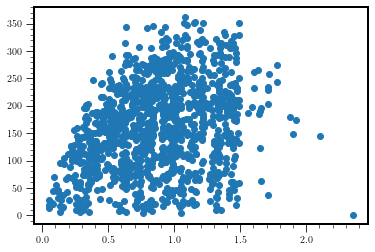

In [9]:
plt.scatter(Rok["Z"], Rok["B_KPC"])
#plt.ylim((5, 15))

In [10]:
np.min(Rok["Z"])

0.051

In [11]:
np.max(Rok["Z"])

2.3569999999999998

# column densities

In [12]:
G["NHI"], G["sigma_NHI"] = gid.Fukugita(G["REW_2796"], G["sig_REW_2796"], G["center_z"])
G["NHI_limit"], _ = gid.Fukugita(G["detection_limit"], 1, G["center_z"])

# Halo Mass from M*

In [13]:
G["Mhalo"] = gid.Behroozi(np.log10(G["Mstar"]), G["center_z"])

# Rvir of the closest galaxy

In [14]:
G["bmin_norm_kpc_2"] = 0
G["Rvir_closest"] = 0

In [15]:
#R["Rvir_subhalo"] = gid.get_Rvir(R["Msubhalo"], R["Z"])

for i, g in G.iterrows():
    r = R[R["group_id"] == g["group_id"]]
    bmin = r["B_KPC"].min()
    rmin = r[r["B_KPC"] == bmin]
    
    rvir_min = gid.get_Rvir(rmin["Msubhalo"], rmin["Z"])
    rvir_min = rvir_min.values[0]
    bmin = g["b_min_kpc"]
    #print(rvir_min)
    G.loc[i, "b_min_kpc_norm_2"] = bmin/rvir_min
    G.loc[i, "Rvir_closest"] = rvir_min

# Vlos min max & spread

In [16]:
for i, g in G.iterrows():
    grpid = g["group_id"]
    rr = R[R["group_id"] == grpid]
    rr = rr[rr["outlier"] == False]
    vmin = rr["vlos_to_gcenter"].min()
    vmax = rr["vlos_to_gcenter"].max()
    zmin = rr["Z"].min()
    zmax = rr["Z"].max()
    vspread = vmax-vmin
    G.loc[i, "vlos_min"] = vmin
    G.loc[i, "vlos_max"] = vmax
    G.loc[i, "z_min"] = zmin
    G.loc[i, "z_max"] = zmax
    G.loc[i, "vlos_spread"] = vspread

# Virial velocity

In [17]:
K = (1*u.kpc).to(u.m)
K.value

3.085677581491367e+19

In [18]:
G["Vvir_sigma2"] = (const.G.value*G["Mvir_sigma2"]*const.M_sun.value/G["Rvir_sigma2"]/K.value)**0.5
G["Vvir_sigma3"] = (const.G.value*G["Mvir_sigma3"]*const.M_sun.value/G["Rvir_sigma3"]/K.value)**0.5
G["Vvir_sigma2"] = G["Vvir_sigma2"]/1000 #back in km/s
G["Vvir_sigma3"] = G["Vvir_sigma3"]/1000 #back in km/s

# Groups selection

In [19]:
G["bool_abs_01"] = (G["REW_2796"] > 0.1)*1
G["bool_abs_03"] = (G["REW_2796"] > 0.3)*1
G["bool_abs_1"] = (G["REW_2796"] > 1)*1

In [20]:
len(G)
len(G[G["N_gal"]>=3])

130

In [21]:
#G = G.rename(columns = {"Rvir":"Rvir_vel_disp"})

Text(0.5, 0, 'M1/M2 ratio')

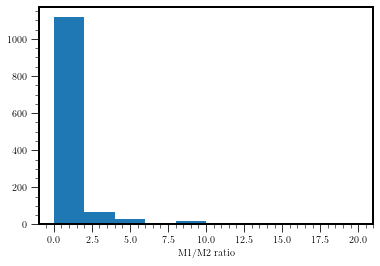

In [22]:
plt.hist(G["m1_m2_ratio"], range = (0,20));
plt.xlabel("M1/M2 ratio")

In [23]:
#f1 = G["N100"] <= 1
#f3 = G["N100_los"] <= 2
#f4 = G["N100_los"] <= 1
f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
f16 = R["N100_los"] <= 2
f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [24]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[f10 & f7 & f14 & f13]
G5_raw = G[f9]
G5 = G[f9 & f13 & f14]
#G5 = gid.create_id(G5, "N_gal")
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G3 = G[f99 & f13 & f14]
G3_abs = G3[G3["bool_absorption"] == 1]
G3_noabs = G3[G3["bool_absorption"] == 0]

R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
R_ilane2_abs = R[f22 & f17 & f18  & f23]
R_ilane2_noabs = R[f21 & f17 & f18  & f23]

The number of groups of more than 5 galaxies is originally:

In [25]:
qq = G[G["N_gal"]>= 5]
len(qq)

32

In [26]:
len(qq[qq["Mvir_sigma2"] >= 1e13])

7

But we have to remove the groups that are behind the QSO:

In [27]:
qqq = G[f9&f14]
len(G[f9&~f14])

4

In [28]:
qq[["center_z", "zqso_sdss", "QSO_is_behind"]]

center_z  zqso_sdss  QSO_is_behind
0   0.988650      1.532           True
1   0.937800      0.938          False
2   0.833650      1.927           True
3   0.744696      1.925           True
4   0.637407      1.222           True
5   0.900740      1.925           True
6   0.607540      1.798           True
7   1.330470      1.605           True
8   1.484000      1.484          False
9   1.099869      1.484           True
10  0.873060      0.875          False
11  1.431318      2.389           True
12  1.214990      1.669           True
13  0.940712      1.770           True
14  1.136588      1.798           True
15       NaN      1.618           True
16  0.824030      1.770           True
17  0.971720      2.238           True
18  1.356270      1.927           True
19  0.606010      1.294           True
20  0.986891      1.880           True
21  3.549020      1.925          False
22  0.807050      1.669           True
23  1.098480      1.222           True
24  1.295234      1.925           True
25  1.340270      1.595           True
26  1.221350      2.308           True
27  1.043970      1.669           True
28  0.533490      0.875           True
29  0.629700      0.875           True
30  0.464000      0.875           True
31  0.600017      1.294           True

In [29]:
qqq[["ID","MgII_2796_lim"]]

ID  MgII_2796_lim
0    1          10.90
2    3          10.71
3    4            NaN
4    5          10.72
5    6            NaN
6    7          11.01
7    8          10.52
9   10          10.65
11  12          10.86
12  13          10.61
13  14          10.77
14  15          11.00
15  16            inf
16  17          10.75
17  18          10.89
18  19          10.67
19  20            NaN
20  21          10.75
22  23          10.54
23  24          10.77
24  25          10.38
25  26          10.41
26  27          10.43
27  28          10.59
28  29          10.81
29  30            inf
30  31          10.81
31  32          10.61

Finally the number of groups of more than 5 galaxies is:

In [30]:
print("nb of groups of more than 5 gal: ", len(G5))
print("nb of groups of more than 3 gal: ", len(G3))

nb of groups of more than 5 gal:  26
nb of groups of more than 3 gal:  94


### exports the groups

In [31]:
#gid.plot_groups(R, G3, Nmin = 1, save = True,  filename = "FoF_G3_groups_caust.pdf")

# Mass of the groups

In [32]:
len(G5)

26

In [33]:
print(np.min(np.log10(G5["Mvir_sigma2"])))
print(np.max(np.log10(G5["Mvir_sigma2"])))
print(np.median(np.log10(G5["Mvir_sigma2"])))

10.839911523661355
13.719026815640289
12.298802610363925


In [34]:
print(np.min(G5["center_z"]))
print(np.max(G5["center_z"]))
print(np.median(G5["center_z"]))

0.46399999999999997
1.4313177399384789
0.9793055604718044


In [35]:
len(G[(G["N_gal"]>=5) & (G["QSO_is_behind"]==True) & (G["MgII_2796_lim"] != np.inf)])

26

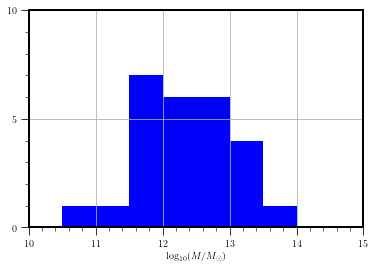

In [36]:
#plt.figure(figsize = (6,4))
plt.hist(np.log10(G5["Mvir_sigma2"]), bins = 10, range=(10, 15), color = "blue");
plt.xlabel("$\log_{10}(M/M_{\odot}$)")
plt.yticks([0,5,10]);
plt.xlim((10,15))
plt.grid()

# Phase space

In [218]:
r = np.linspace(0, 800,100)[1:]*u.kpc #0 has a singularity
z = 1
Mvir = 1e12
Rvir = gid.get_Rvir(1e12, z)
vesc = gid.NFW_escape_vel_from_Mvir(r, Mvir*u.solMass, z = z)
Vvir = (const.G*Mvir*const.M_sun/(Rvir*u.kpc))**0.5 #in km/s
Vvir = Vvir.to(u.km/u.s)
Vvir = Vvir.value
print(Rvir, Vvir)

156.28710893311342 165.88952578162505


(0.0, 2.5)

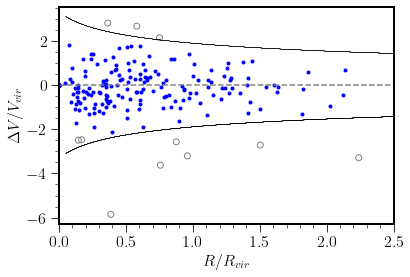

In [110]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    galaxies_out = galaxies[galaxies["outlier"] == True]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_clean["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                c = 'blue', marker = ".")
    plt.scatter(galaxies_out["r_to_gcenter"]/g["Rvir_sigma2"], galaxies_out["vlos_to_gcenter"]/g["Vvir_sigma2"], \
                marker = "o", facecolors = "none", edgecolors = "gray")
    plt.plot(r/Rvir, vesc/Vvir, c = "black", linestyle = "--", linewidth = 0.1)
    plt.plot(r/Rvir, -vesc/Vvir, c = "black", linewidth = 0.1)
plt.xlabel("$R/R_{vir}$")
plt.ylabel("$\Delta V/V_{vir}$")
plt.xlim((0,2.5))
#plt.ylim((-1550,1550))
#plt.yticks(np.arange(-3, 4)*500);

Text(0, 0.5, '$\\Delta v$ $(km/s)$')

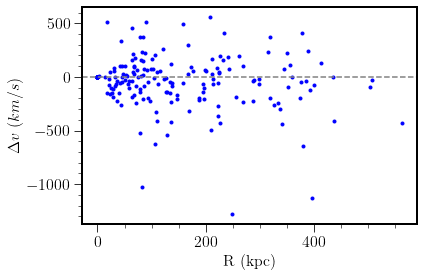

In [111]:
#plt.figure(figsize = (6,5))
plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["r_to_gcenter"], galaxies_clean["vlos_to_gcenter"], c = 'blue', marker = ".")
plt.xlabel("R (kpc)")
plt.ylabel("$\Delta v$ $(km/s)$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

(2.0, 22.0)

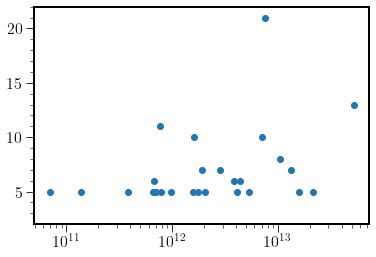

In [112]:
plt.scatter(G5["Mvir_sigma2"], G5["N_gal"])
plt.xscale("log")
plt.ylim((2, 22))

Ggood = G3[G3["ID"].isin(good_grp)]
Ggood_noabs = G_noabs[G_noabs["ID"].isin(good_grp)]
Ggood_abs = G_abs[G_abs["ID"].isin(good_grp)]
Ggood_noabs = G_noabs[G_noabs["ID"].isin(good_grp)]
len(Ggood_abs)+len(Ggood_noabs)
len(Ggood)

we have less good groups because some of them are behind QSO or in no UVES coverage zone

# Absorptions

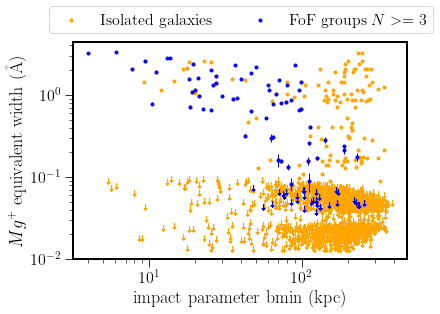

In [113]:
plt.rcParams['lines.linewidth']=1.0
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "orange", marker = ".", label = "Isolated galaxies", alpha = 1)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "$\downarrow$", c = "orange", alpha = 1)

plt.errorbar(G3_abs["b_min_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G3_abs["b_min_kpc"], G3_abs["REW_2796"], marker = ".", label = "FoF groups $N >= 3$", c = "blue")
plt.scatter(G3_noabs["b_min_kpc"], G3_noabs["detection_limit"], marker = "$\downarrow$", c = "blue")
#plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")
#plt.scatter(G_good_fof_abs["b_min_kpc"], G_good_fof_abs["REW_2796"], marker = "o", label = "Score $> 0.75$", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc"], G_good_fof_noabs["detection_limit"], marker = "v", c = "red")

plt.xlabel("impact parameter bmin (kpc)", size = 18)
plt.ylabel("$Mg^+$ equivalent width (\AA)", size = 18)
#plt.grid()
plt.legend(bbox_to_anchor=(1.1,1.2), ncol = 2)
plt.xscale("log")

plt.yscale("log")

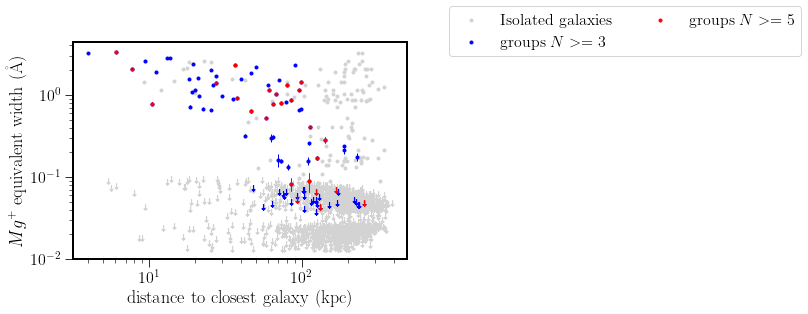

In [114]:
plt.rcParams['lines.linewidth']=1.0
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "lightgray", marker = ".", label = "Isolated galaxies", alpha = 1)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "$\downarrow$", c = "lightgray", alpha = 1)

plt.errorbar(G3_abs["b_min_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G3_abs["b_min_kpc"], G3_abs["REW_2796"], marker = ".", label = "groups $N >= 3$", c = "blue")
plt.scatter(G3_noabs["b_min_kpc"], G3_noabs["detection_limit"], marker = "$\downarrow$", c = "blue")
plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "red")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups $N >= 5$", c = "red")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", c = "red")
#plt.scatter(G_good_fof_abs["b_min_kpc"], G_good_fof_abs["REW_2796"], marker = "o", label = "Score $> 0.75$", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc"], G_good_fof_noabs["detection_limit"], marker = "v", c = "red")

plt.xlabel("distance to closest galaxy (kpc)", size = 18)
plt.ylabel("$Mg^+$ equivalent width (\AA)", size = 18)
#plt.grid()
plt.legend(bbox_to_anchor=(1.1,1.2), ncol = 2)
plt.xscale("log")

plt.yscale("log")

we can try to look at the interloper at the bottom left:

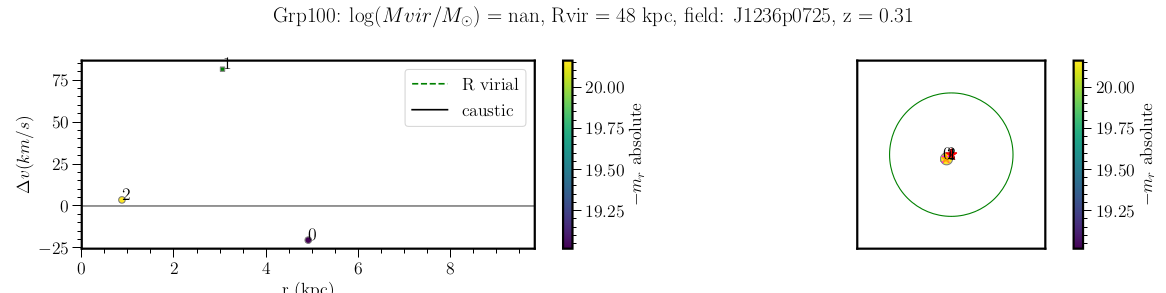

We have 3 galaxies very close. Is it a doublon? Or bad PSF substraction?

After investigation it is not a group. We have a bad match feline - white and sources to be splitted. In fact there is only 2 object at this redshift.

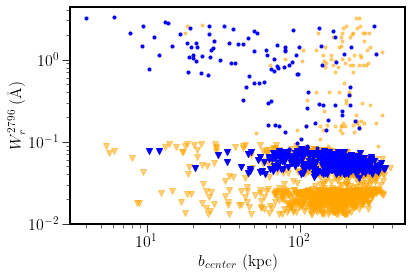

In [115]:
plt.scatter(R_ilane2_abs["B_KPC"], R_ilane2_abs["REW_2796"], c = "orange", marker = ".", label = "Isolated galaxies", alpha = 0.5)
plt.scatter(R_ilane2_noabs["B_KPC"], R_ilane2_noabs["detection_limit"], marker = "v", c = "orange", alpha = 0.5)


#plt.errorbar(G3_abs["b_center_kpc"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G_abs["b_min_kpc"], G_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G_noabs["b_min_kpc"], G_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(Ggood_abs["b_center_kpc"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")
plt.xlabel("$b_{center}$ (kpc)")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

In [116]:
len(G5_abs[G5_abs["REW_2796"]>=1])

9

# Normalized by Rvir

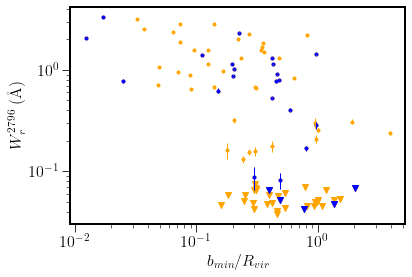

In [117]:
plt.errorbar(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], yerr = G3_abs["sig_REW_2796"], fmt = 'none',c = "orange")
plt.scatter(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "orange")
plt.scatter(G3_noabs["b_min_kpc_norm2"], G3_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "orange")

plt.errorbar(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_min_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")
#plt.scatter(G_good_fof_abs["b_min_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_min_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

#plt.scatter(Ggood_abs["b_min_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_min_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

plt.xlabel("$b_{min}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

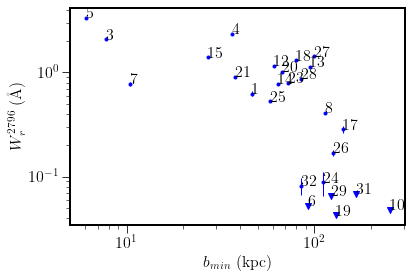

In [118]:

#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_center_kpc_norm"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(G_good_fof_abs["b_center_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_center_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")


#plt.scatter(Ggood_abs["b_center_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

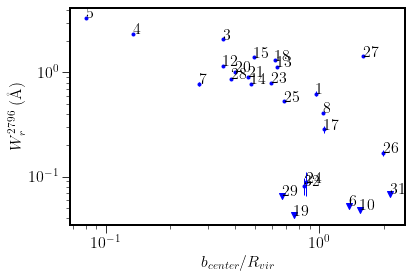

In [119]:

#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "blue")
#plt.scatter(G5_noabs["b_center_kpc_norm"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "blue")

#plt.scatter(G_good_fof_abs["b_center_kpc_norm"], G_good_fof_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(G_good_fof_noabs["b_center_kpc_norm"], G_good_fof_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")


#plt.scatter(Ggood_abs["b_center_kpc_norm"], Ggood_abs["REW_2796"], marker = "o", label = "groups N >= 5", c = "red")
#plt.scatter(Ggood_noabs["b_center_kpc_norm"], Ggood_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, '$W_r^{2796}$ (\\AA)')

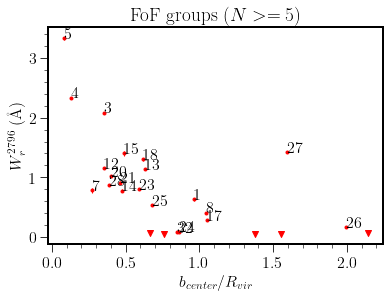

In [120]:

plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "red")
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = ".", label = "groups N >= 5", c = "red")
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", c = "red")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
#plt.xscale("log")
#plt.yscale("log")

In [121]:
g8 = G[G["ID"] == 9]
g8

index    field_id  group_id  N_gal    mean_z     mean_ra   mean_dec  \
8     10  J1358p1145       248      7  1.482316  209.538331  11.764584   

   b_min_kpc   Mvir_sigma2   Mvir_sigma3  ...    vlos_min   vlos_max    z_min  \
8        1.3  1.316459e+13  9.192843e+12  ... -608.274552  38.620607  1.47896   

     z_max  vlos_spread  Vvir_sigma2  Vvir_sigma3  bool_abs_01  bool_abs_03  \
8  1.48432   646.895159   431.937483   383.208457            0            0   

   bool_abs_1  
8           0  

[1 rows x 93 columns]

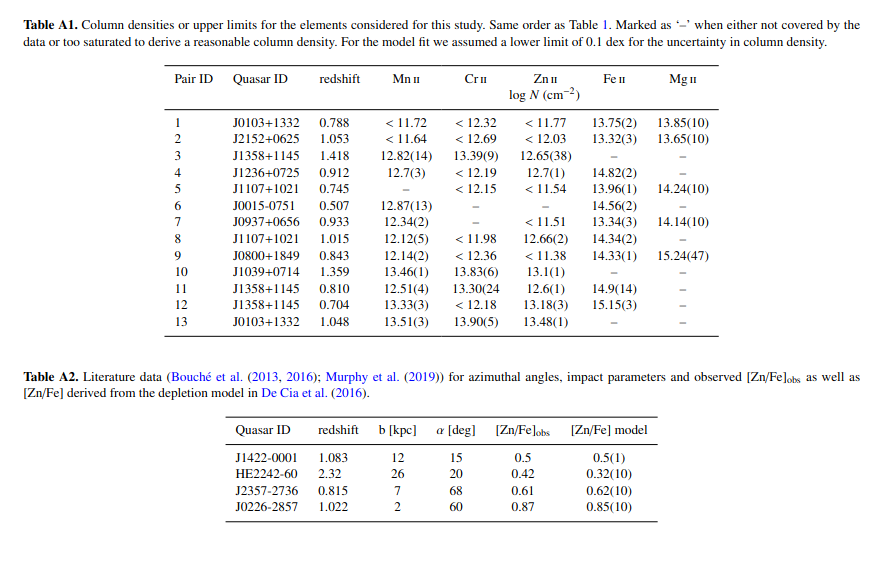

## Kinematics of the groups

In [122]:
def plot_groups_modif(R, G, Nmin = 5, save = False,  filename = "none"):
	if save == True:
		if filename == "none":
			from datetime import datetime
			d = datetime.now()
			name = str(d.year)+str(d.month)+str(d.day)+"_groups.pdf"
		else:
			name = filename
		pdf = matplotlib.backends.backend_pdf.PdfPages(name)

	G_filt = G[G["N_gal"]>= Nmin]

	for i, g in G_filt.iterrows():
		#try:
		df = R[R["group"] == g["group_id"]]	
		z_mean = g["mean_z"]
		ra_mean = g["mean_ra"]*u.degree
		dec_mean = g["mean_dec"]*u.degree

		if ~np.isnan(g["center_z"]):
			z_center = g["center_z"]
			ra_center =  g["center_ra"]*u.degree
			dec_center = g["center_dec"]*u.degree
		else: 
			z_center = g["mean_z"]
			ra_center =  g["mean_ra"]*u.degree
			dec_center = g["mean_dec"]*u.degree

		ra_qso = (df["ra_qso"].mean())*u.degree
		dec_qso = (df["dec_qso"].mean())*u.degree
		rho0, Rs = gid.get_nfw_param(g["Mvir"], z_mean)
		r = np.linspace(1,3000, num = 10000 )
		M = gid.nfw_cumsum(r, rho0, Rs)
		V = gid.get_esc_v(M, r)

		C = const.c.to('km/s').value
		deg_to_rad = 1*u.degree.to(u.radian)
		
		ra2 = df["RA"]*u.degree
		dec2 = df["DEC"]*u.degree
		c1 = SkyCoord(ra_center, dec_center)
		c2 = SkyCoord(ra2, dec2)
		sep = c1.separation(c2)
		df["r_to_gcenter"] = sep.radian*Distance(unit=u.kpc, z = z_center).value/((1+z_center)**2)
		df["vlos_to_gcenter"] = (df["Z"]-z_center)*C
		
		Rvir = g["Rvir_recomputed"]

		ra = df["RA"]
		dec = df["DEC"]
		vlos = df["vlos_to_gcenter"]
		rcenter = df["r_to_gcenter"]

		df_filt = df[df["outlier"] == False]
		df_out = df[df["outlier"] == True]


		ra = np.array(ra)
		dec = np.array(dec)
		vlos = np.array(vlos)
		rcenter = np.array(rcenter)
		
		fig = plt.figure(figsize = (15,4))
		title = "Grp"+str(g["ID"])\
				+":   log($Mvir/M_{\odot}$) = "\
				+str(round(np.log10(g["Mvir"]),1))\
				+",     Rvir = "+str(round(g["Rvir_recomputed"]))\
				+" kpc" \
				+", field: "+str(g["field_id"])\
				+", z = " +str(np.round(g["center_z"], 2))
		plt.suptitle(title, fontweight = "bold")
		plt.subplot(121)
		plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = "green", edgecolor = 'grey', marker = "s", s = 15)
		if "Psat" in df.columns:
			plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = df["Psat"], edgecolor = 'grey', vmin = 0, vmax = 1, s = df['mass10']/1e8 + 80)
			cbar = plt.colorbar(label =	 "Psat")
		else:
			plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
					c = -df["m_abs_r"], edgecolor = 'grey', s = df['mass10']/1e8 + 80)
			cbar = plt.colorbar(label =	 "$- m_r$ absolute")
		plt.scatter(df_out["r_to_gcenter"], df_out["vlos_to_gcenter"], s = df_out['mass10']/1e8 + 80, facecolors='none', edgecolors='r')
		plt.axvline(Rvir, ls = "--", c = "green", label = "R virial")
		plt.plot(r, V, c = "black", label = "caustic")
		plt.plot(r, -V, c = "black")
		try:
			plt.xlim((0,(np.max(df["r_to_gcenter"]))*2))
		except: 
			print("no center!")
		#plt.ylim((-1500,1500))
		plt.xlabel("r (kpc)")
		plt.ylabel("$\Delta v (km/s)$")
		plt.axhline(c = "grey")
		plt.legend()
		for i in range(len(df)):
			plt.annotate(str(i), (rcenter[i], vlos[i]))

		kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(z_mean)
		arcmin = 1/60
		plt.subplot(122)
		r100 = 100/kpc_per_arcmin.value/60
		plt.scatter(ra_qso.value, dec_qso.value, marker = "*", s = 100, c = "red")
		rectangle = plt.Rectangle((ra_qso.value - arcmin/2,dec_qso.value - arcmin/2), arcmin, arcmin, fc=None ,ec=None, lw = 0, fill = False)
		plt.gca().add_patch(rectangle)
		circle = plt.Circle((ra_qso.value,dec_qso.value),r100, fill = False,ec="green")
		plt.gca().add_patch(circle)
		plt.scatter(df["RA"],df["DEC"], \
					c = "green", edgecolor = 'grey', marker = "s", s = 15)
		plt.scatter(df["RA"],df["DEC"], \
			c = df["vlos_to_gcenter"], edgecolor = 'grey', s = 100, cmap = "seismic", vmin = -1000, vmax = 1000)
		plt.colorbar(label = "$- m_r$ absolute")
		plt.xticks([])
		plt.yticks([])
		plt.scatter(df_out["RA"], df_out["DEC"], s=150, facecolors='none', edgecolors='r')
		plt.scatter(ra_qso.value, dec_qso.value, marker = "*", s = 100, c = "red")
		plt.scatter(ra_mean.value, dec_mean.value, marker = "x", s = 40, c = "magenta")
		plt.scatter(ra_center.value, dec_center.value, marker = "*", s = 60, c = "orange")
		plt.gca().set_aspect('equal', adjustable='box')
		for i in range(len(df)):
			plt.annotate(str(i), (ra[i], dec[i]))
		fig.tight_layout()

		if save == True:
			pdf.savefig(fig)

		#except Exception as e:  
		#	print(e)

	if save == True:
		pdf.close()

	return


In [123]:
#plot_groups_modif(R, G5, Nmin = 3, save = False)

# Correlation with halo masses

Text(0.5, 0, '$M/M_{\\odot}$')

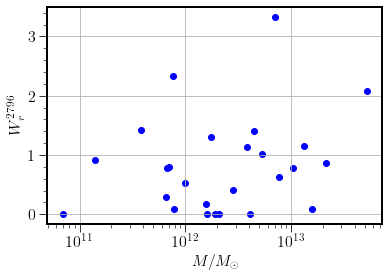

In [124]:
#plt.scatter(G3["Mvir_vel_disp"], G3["REW_2796"], marker = "o", c = "orange")
plt.scatter(G5["Mvir_sigma2"], G5["REW_2796"], marker = "o", c = "blue")
plt.xscale('log')
plt.grid()
plt.ylabel("$W^{2796}_r$")
plt.xlabel("$M/M_{\odot}$")

Text(0, 0.5, '$log(M/M_{\\odot})$')

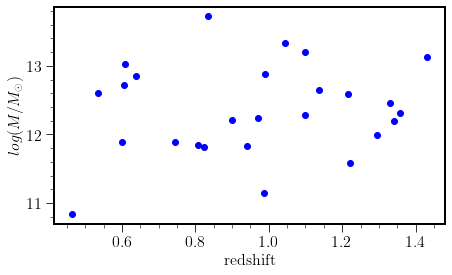

In [125]:
plt.figure(figsize = (7,4))
#plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none',c = "blue")
#plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
#           c = np.log10(G5_abs["Mvir_vel_disp"]), vmin = 11, vmax = 14)
#plt.colorbar(label = "log($M/M_{\odot}$)")
#plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
#           c = np.log10(G5_noabs["Mvir_vel_disp"]), vmin = 11, vmax = 14)

#plt.scatter(R["Z"], R["mass"])
#plt.scatter(G3["center_z"], np.log10(G3["Mvir_vel_disp"]), marker = ".")
plt.scatter(G5["center_z"], np.log10(G5["Mvir_sigma2"]), color = "blue")

#X = np.array(G5_abs["b_min_kpc"])
#Y = np.array(G5_abs["REW_2796"])
#txt = np.array(G5_abs["ID"])

#for i in range(len(G5_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
#X = np.array(G5_noabs["b_min_kpc"])
#Y = np.array(G5_noabs["detection_limit"])
#txt = np.array(G5_noabs["ID"])

#for i in range(len(G5_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))

#plt.ylim((5, 15))


plt.xlabel("redshift")
plt.ylabel("$log(M/M_{\odot})$")
#plt.grid()
#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, '$log(M*/M_{\\odot})$')

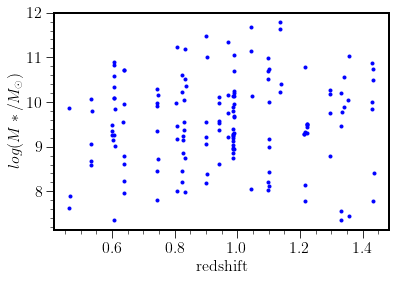

In [126]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["mass"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$log(M*/M_{\odot})$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

Text(0, 0.5, '$SDSS r$')

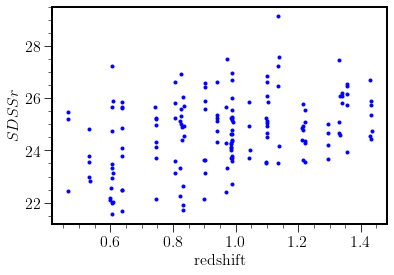

In [127]:
#plt.figure(figsize = (6,5))
#plt.axhline(color = "gray", linestyle = '--')
for i, g in G5.iterrows():
    grpid = g.group_id
    galaxies = R[R["group_id"] == grpid]
    galaxies_clean = galaxies[galaxies["outlier"] == False]
    #plt.scatter(galaxies["r_to_gcenter"], galaxies["vlos_to_gcenter"], c = "lightgray")
    plt.scatter(galaxies_clean["Z"], galaxies_clean["SDSS_r"], c = 'blue', marker = ".")
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")
#plt.xlim((0, 2))
#plt.ylim((-1500,1500))

Text(0, 0.5, '$SDSS r$')

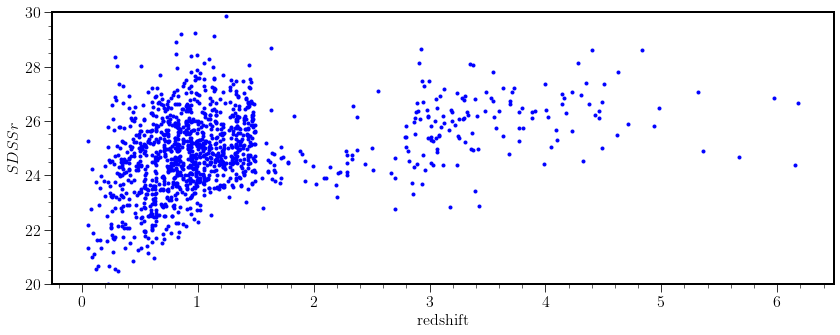

In [128]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["SDSS_r"], c = 'blue', marker = ".")
plt.ylim((20, 30))
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")

Text(0, 0.5, '$mass$')

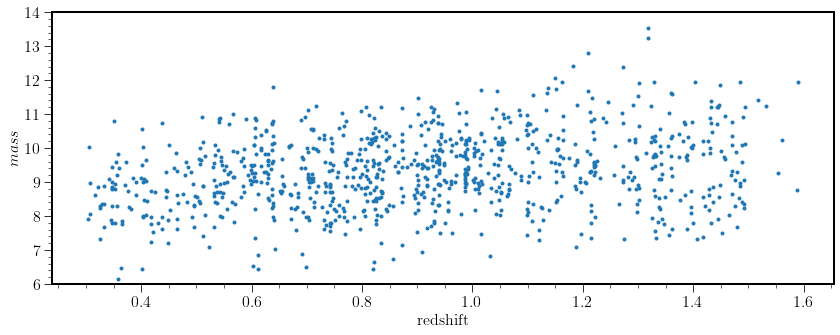

In [129]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["mass"], marker = ".")
plt.ylim((6, 14))
plt.xlabel("redshift")
plt.ylabel("$mass$")

In [130]:
d10 = 10*u.pc
d10 = d10.to(u.m)
R["m_abs_r"] = R["SDSS_r"] + 2.5*np.log10((R["dist_lum"]/d10.value)**2) 

Text(0, 0.5, '$SDSS r$')

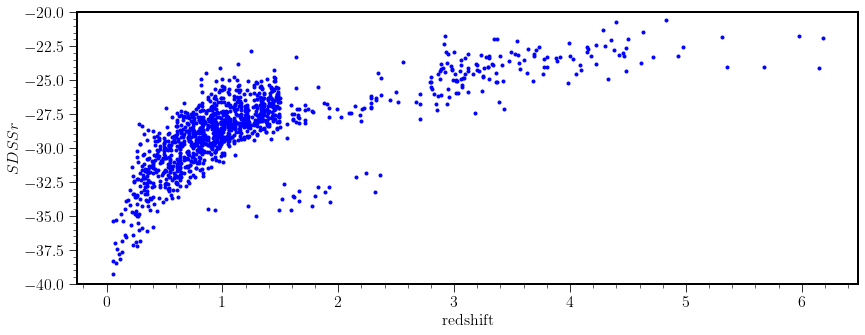

In [131]:
plt.figure(figsize=(14,5))
plt.scatter(R["Z"], R["m_abs_r"], c = 'blue', marker = ".")
plt.ylim((-40, -20))
plt.xlabel("redshift")
plt.ylabel("$SDSS r$")

In [132]:
Z = np.linspace(0.1, 6, 30)
Mlim_rel =  27 # at z = 1
mlim_abs = Mlim_rel + 2.5*np.log10((Distance(unit=u.m, z = Z).value/d10.value/((1+Z)**2))**2)
mlim_abs

array([64.97329696, 66.90166009, 67.58140683, 67.91768355, 68.0998223 ,
       68.19877127, 68.24817558, 68.26623151, 68.26364374, 68.24708954,
       68.22091783, 68.18805666, 68.15052968, 68.10976521, 68.06678865,
       68.02234629, 67.97698726, 67.93111904, 67.88504586, 67.83899569,
       67.79313965, 67.74760594, 67.70249024, 67.65786332, 67.61377677,
       67.5702674 , 67.5273605 , 67.48507246, 67.44341267, 67.40238513])

In [133]:
Z = np.linspace(0.1, 6, 30)
Mlim = mlim - 2.5*np.log10((Distance(unit=u.m, z = Z).value/d10.value)**2)

NameError: name 'mlim' is not defined

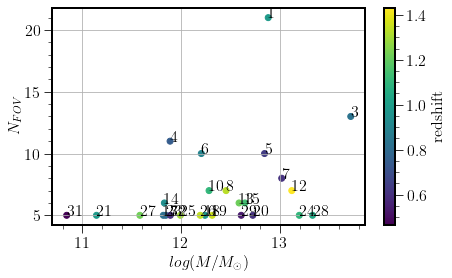

In [134]:
plt.figure(figsize = (7,4))
plt.scatter(np.log10(G5["Mvir_sigma2"]), G5["N_gal"], c = G5["center_z"])
plt.colorbar(label = "redshift")


X = np.array(np.log10(G5["Mvir_sigma2"]))
Y = np.array(G5["N_gal"],)
txt = np.array(G5["ID"])

for i in range(len(G5)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    

plt.xlabel("$log(M/M_{\odot})$")
plt.ylabel("$N_{FOV}$")
plt.grid()

In [135]:
G5.columns

Index(['index', 'field_id', 'group_id', 'N_gal', 'mean_z', 'mean_ra',
       'mean_dec', 'b_min_kpc', 'Mvir_sigma2', 'Mvir_sigma3', 'Rvir_sigma2',
       'Rvir_sigma3', 'Mstar', 'm1_m2_ratio', 'center_ra', 'center_dec',
       'center_z', 'center_ra_err', 'center_dec_err', 'center_z_err',
       'Mvir_sigma2_error', 'Rvir_sigma2_error', 'Mvir_sigma3_error',
       'Rvir_sigma3_error', 'Rmax', 'sigma_v', 'sigma_v_error', 'ID',
       'EXPTIME(s)', 'PSF_qso', 'Comments_qso', 'zqso_sdss', 'depth_qso',
       'ebv_sfd_qso', 'ebv_sandf_qso', 'ebv_planck_qso', 'HST_qso', 'rmag_qso',
       'ra_qso', 'dec_qso', 'N100', 'N200', 'N100_los', 'dist', 'b_center_kpc',
       'b_geomcenter_kpc', 'b_center_err', 'b_min_kpc_norm2',
       'b_center_kpc_norm2', 'b_geomcenter_kpc_norm2', 'b_min_kpc_norm2_err',
       'b_center_kpc_norm2_err', 'b_geomcenter_kpc_norm2_err',
       'b_min_kpc_norm3', 'b_center_kpc_norm3', 'b_geomcenter_kpc_norm3',
       'b_min_kpc_norm3_err', 'b_center_kpc_norm3_err',
   

# Bmin or Bcenter ?

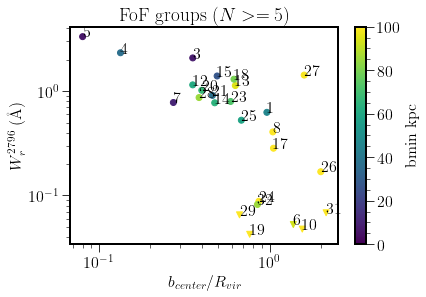

In [136]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

# Fit of the MgII decrease

In [137]:
from scipy.optimize import minimize
from scipy import integrate

The fit is performed using the method described in Hogg 2010 but also taking into accout the upper limit as in Dutta 2020 and Rubin 2018. The idea is to take into account the uncertainties along the 2 axis by taking the distance to the linear relation. 

First, when we look at the uncertainties we can see that there is a nan values:

In [138]:
G5_abs[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

b_min_kpc  b_center_kpc_norm2  REW_2796  sig_REW_2796
0       46.37            0.963220     0.627         0.030
2        7.77            0.354076     2.085         0.016
3       36.59            0.133495     2.336         0.010
4        6.04            0.080058     3.335         0.025
6       10.36            0.272635     0.779         0.037
7      113.48            1.044039     0.407         0.012
11      60.96            0.353980     1.150           NaN
12      95.16            0.629321     1.133         0.017
13      64.36            0.476293     0.774         0.022
14      27.24            0.492148     1.399         0.036
16     141.71            1.053020     0.284         0.022
17      79.59            0.617855     1.303         0.028
19      67.41            0.400024     1.020         0.013
20      37.77            0.462009     0.911         0.021
22      72.37            0.590455     0.797         0.015
23     111.71            0.864856     0.088         0.023
24      58.22            0.682625     0.527         0.009
25     125.53            1.994111     0.169         0.010
26      99.21            1.594393     1.427         0.009
27      84.85            0.385689     0.869         0.017
31      84.86            0.848259     0.082         0.015

In [139]:
G5_noabs[["b_center_kpc_norm2", "REW_2796", "sig_REW_2796", "detection_limit"]]

b_center_kpc_norm2  REW_2796  sig_REW_2796  detection_limit
5             1.376444       0.0           0.0         0.052611
9             1.553791       0.0           0.0         0.047622
18            0.763724       0.0           0.0         0.042440
28            0.665717       0.0           0.0         0.065211
30            2.143133       0.0           0.0         0.068306

we affect a value:

In [140]:
idx = G5_abs.index[G5_abs["sig_REW_2796"].isnull()].to_list()
G5_abs.loc[idx, "sig_REW_2796" ] = 0.05
G5_abs[["b_min_kpc","b_center_kpc_norm2", "REW_2796", "sig_REW_2796"]]

b_min_kpc  b_center_kpc_norm2  REW_2796  sig_REW_2796
0       46.37            0.963220     0.627         0.030
2        7.77            0.354076     2.085         0.016
3       36.59            0.133495     2.336         0.010
4        6.04            0.080058     3.335         0.025
6       10.36            0.272635     0.779         0.037
7      113.48            1.044039     0.407         0.012
11      60.96            0.353980     1.150         0.050
12      95.16            0.629321     1.133         0.017
13      64.36            0.476293     0.774         0.022
14      27.24            0.492148     1.399         0.036
16     141.71            1.053020     0.284         0.022
17      79.59            0.617855     1.303         0.028
19      67.41            0.400024     1.020         0.013
20      37.77            0.462009     0.911         0.021
22      72.37            0.590455     0.797         0.015
23     111.71            0.864856     0.088         0.023
24      58.22            0.682625     0.527         0.009
25     125.53            1.994111     0.169         0.010
26      99.21            1.594393     1.427         0.009
27      84.85            0.385689     0.869         0.017
31      84.86            0.848259     0.082         0.015

In [141]:
Abs = pd.read_csv("MgII_all_absorption")

The likelihood from Dutta is composed of 2 terms:

\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \int_{-\infty}^{W_i} \frac{dW'}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W' - W(R_i)}{\sigma_i}\right]^2\right)
\end{equation}

The first one is the classic one for points that have MgII detection. The second term is there to take into account the points that have an upper detection limit. To compute this second term we can use the erf function, defined as:

\begin{equation}
    erf(z) = \frac{2}{\pi}\int_0^{z} e^{-t^2}dt
\end{equation}

For that we Pose, for each subterm i: 
\begin{equation}
    x = \frac{W'-W(R_i)}{\sqrt{2}\sigma_i}
\end{equation}

hence we have:
\begin{equation}
    dx = \frac{dW'}{\sqrt{2}\sigma_i}
\end{equation}

And for $W' = Wi$ we have 
\begin{equation}
    x = \frac{W_i-W(R_i)}{\sqrt{2}\sigma_i}\equiv{}X
\end{equation}

In consequence:
\begin{equation}
    I = \frac{\sqrt{2}\sigma_i}{\sqrt{2\pi\sigma_i^2}}\int_{-\infty}^{X} e^{-x^2}dx
\end{equation}

So: 
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\int_{-\infty}^{0} e^{-x^2}dx + \int_{0}^{X} e^{-x^2}dx\right]
\end{equation}
\begin{equation}
    I = \frac{1}{\sqrt{\pi}}\left[\frac{\sqrt{\pi}}{2}+ \frac{\sqrt{\pi}}{2} erf(X)\right]
\end{equation}
\begin{equation}
    I = \frac{1}{2}\left[1+ erf(X)\right]
\end{equation}


So Finally, the total likelihood is: 
\begin{equation}
    L(W) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2}\left[\frac{W_i - W(R_i)}{\sigma_i}\right]^2\right)
\times \prod_{i=1}^m \frac{1}{2}\left[1+ erf(X_i)\right]
\end{equation}



We also have to take into accout an intrisic scatter $\sigma_c$. For that we use the method described in Chen 2010. We first assume a value and then we iter to refine the intrisic scatter.
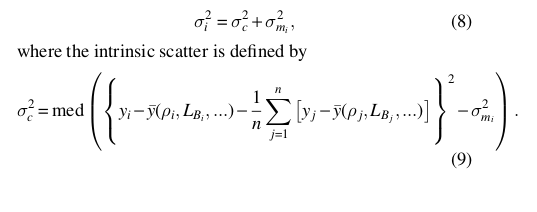

In [142]:
def calc_sigma_intrisic(yi, modeled_yi, sigma_mi):
    """
    compute the intrisic scatter from the comparison between data and model.
    It must be used iteratively until convergence to an intrisic scatter value.
    """

    
    mean_residual = np.mean(yi-modeled_yi)
    
    intrisic_i = (yi - modeled_yi - mean_residual)**2 - sigma_mi**2
    sigma_intri = np.median(intrisic_i)
    
    print("yi = ", yi)
    print("modeled_yi = ", modeled_yi)
    print("sigma_mi = ", sigma_mi)
    print("mean_residual = ", mean_residual)
    print("sigma_intrisic = ", sigma_intri**0.5)
    
    return sigma_intri**0.5

### for bcenter/Rvir

We define the input data:

In [143]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

the y-uncertainties for the point with no detection are not defined in the catalog but we must affect a value. When we look at the plots above we can see that the uncertainty increase when the REW decrease (which is logical). if we plot the uncertainty as a function of the REW (see below) we can assume that a value of ~ 0.3 is of the good order of magnitude.

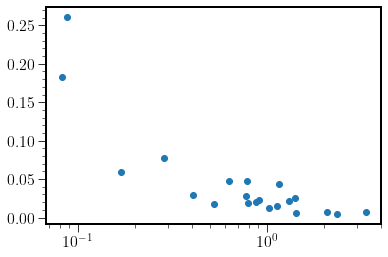

In [144]:
plt.scatter(G5_abs["REW_2796"], G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
plt.xscale("log")
#plt.yscale("log")

With the method from **David Hogg 2010**:

In [145]:
 def model(param, x):
    # y = ax +b
    return param[0] + param[1]*x

def logL_Hogg_only_abs(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N = len(x1)
    LL = 0
    
    for i in range(N):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL

def logL_Hogg_all(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    N2 = len(x2)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL


def logL_Hogg_with_lim(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sigi = sig_y2[i]
        X = (yi - model(param, xi))/sigi/((2**0.5))
        #X = (yi - model(param, xi))
        I = 0.5*(1 + math.erf(X))
        #print(param, " xi: ", xi, " yi: ", yi, ", model yi = ", model(param, xi), "yi - ymodel = ",yi - model(param, xi) )
        #print("I = ", I)
        #LL2i.append(np.log(I))
        LL += np.log(I)
    
    return -LL


def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    #print("theta = ", theta)

    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)
        print(" X = ", X, "----  I = ", I, "--- log(I) = ", np.log(I))
        LL2i.append(np.log(I))
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 1.5, 50)
    plt.figure()
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")    
    return -LL

param =  1.0 -3.0
theta =  -1.2490457723982544
param =  1.0000000149011612 -3.0
theta =  -1.2490457723982544
param =  1.0 -2.999999985098839
theta =  -1.2490457709081384
param =  2.0042700120217742 -2.892567495822795
theta =  -1.237945194387349
param =  2.0042700269229354 -2.892567495822795
theta =  -1.237945194387349
param =  2.0042700120217742 -2.8925674809216337
theta =  -1.237945192796525
param =  1.3562082119510315 -2.9618943712743717
theta =  -1.245191163711923
param =  1.3562082268521927 -2.9618943712743717
theta =  -1.245191163711923
param =  1.3562082119510315 -2.9618943563732105
theta =  -1.2451911621871674
param =  2.1151777960961153 -6.536316036999757
theta =  -1.4189821173634343
param =  2.1151778109972765 -6.536316036999757
theta =  -1.4189821173634343
param =  2.1151777960961153 -6.536316022098596
theta =  -1.4189821170226293
param =  1.5621330135081999 -3.931711986594565
theta =  -1.321735147091101
param =  1.562133028409361 -3.931711986594565
theta =  -1.32173514709110

param =  2.009677338167596 -2.9744721173851256
 X =  -0.8675085404145775 ----  I =  0.10994092623041679 --- log(I) =  -2.207812091713211
 X =  -0.302331662973002 ----  I =  0.33448518660669535 --- log(I) =  -1.0951626855762493
 X =  -3.430690741046592 ----  I =  6.11947766404608e-07 --- log(I) =  -14.306618907088598
 X =  -3.6072048976783657 ----  I =  1.6861241514121161e-07 --- log(I) =  -15.595663157427712
 X =  -0.8033070217065177 ----  I =  0.1279683039779525 --- log(I) =  -2.055972670898941
LL =  -127.56586614620076
LL1 terms:  [-0.8177405033716224, -1.2196392569116823, -2.9539587172226076, -11.250569940864498, -46.970889085426705, -0.05666037930649206, -4.784137923777827, -0.0005652682928744773, -0.31504828165493876, -0.12354840952960262, -0.01810045472666946, -0.02459492936530702, -4.363931179165271, -0.4676314788773868, -0.7219005184823948, -4.2502630850585765, -0.5820008576571123, -1.261509086773552, -0.2914494107548413, -7.351792025934898, -4.478705840341167]
LL2 terms:  [-2.

param =  1.732438501047762 -4.326276548245455
 X =  -0.9318607780222744 ----  I =  0.09377690793896887 --- log(I) =  -2.3668366372977396
 X =  -0.9575288215220524 ----  I =  0.08784422434544564 --- log(I) =  -2.432190211012906
 X =  -1.388310979426437 ----  I =  0.024801702118714297 --- log(I) =  -3.6968429943472683
 X =  -1.5537289535498227 ----  I =  0.01399935116412132 --- log(I) =  -4.268744295860766
 X =  -1.6126598035714088 ----  I =  0.011284720261119596 --- log(I) =  -4.484305657578179
LL =  -51.95286022892584
LL1 terms:  [-10.045204874277767, -3.3513835054532124, -0.2246075731612227, -0.5466155352079403, -7.202122941078495, -2.4604617103350312, -0.012898273386560478, -1.9950407933524914, -0.0010696622107041383, -0.711665896615449, -1.1345660854322566, -1.9644562933260892, -0.00104311085300875, -0.01248554353839691, -0.5245776988551596, -0.11205179315592736, -0.24123382751566008, -3.4002377551209864, -0.4402689373928399, -0.14458137982762506, -0.1773672427321602]
LL2 terms:  [-

param =  1.7793211418407031 -4.261226010401493
 X =  -0.8438228892720665 ----  I =  0.11636699122119931 --- log(I) =  -2.151006364475263
 X =  -0.897601108706015 ----  I =  0.10214927842492438 --- log(I) =  -2.2813200216208473
 X =  -1.4920584122389553 ----  I =  0.017425334857993968 --- log(I) =  -4.0498301054186765
 X =  -1.6629153825653769 ----  I =  0.009343480876734755 --- log(I) =  -4.673076411295903
 X =  -1.573979995092949 ----  I =  0.013008971150084536 --- log(I) =  -4.342116071054117
LL =  -51.60880851184709
LL1 terms:  [-9.230243992600943, -2.6092511922968216, -0.32308342796555517, -0.9329374409815273, -8.653614873801164, -2.2366370712639587, -0.06093040976464149, -1.7452107023419487, -7.449921413514494e-06, -0.5840134963915108, -1.0031558327997312, -1.7428112932626838, -0.010033861611057765, -0.003972878190415473, -0.3968230767091559, -0.17850876292022644, -0.1765659450124577, -3.266995181880636, -0.42939311350479137, -0.27253771343450856, -0.2547318213271297]
LL2 terms:  

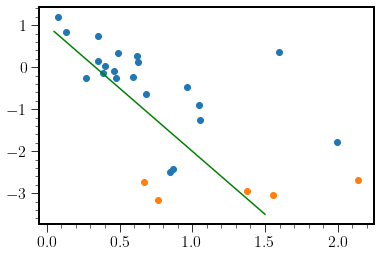

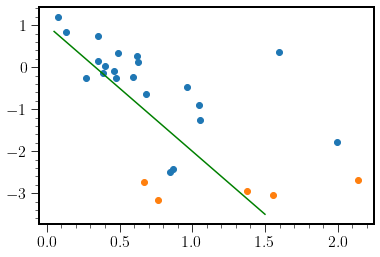

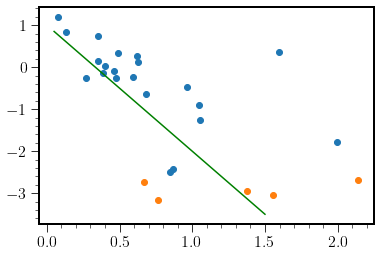

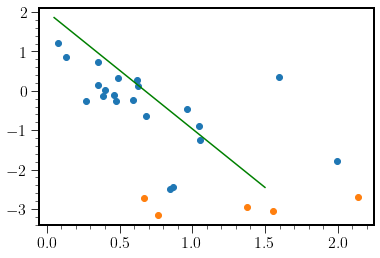

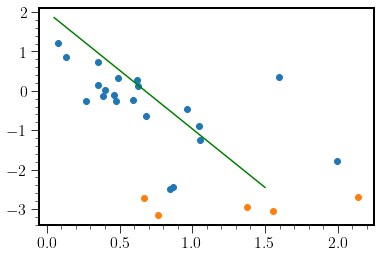

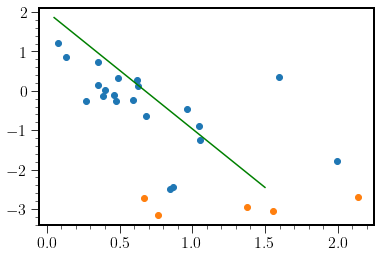

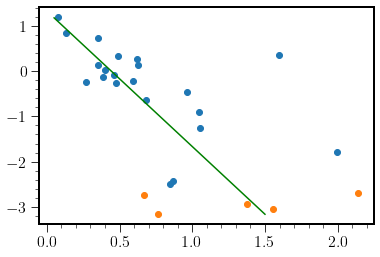

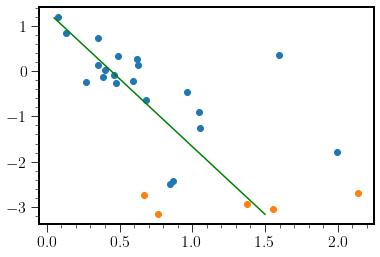

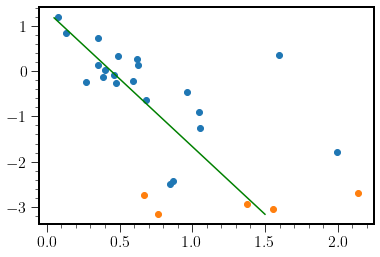

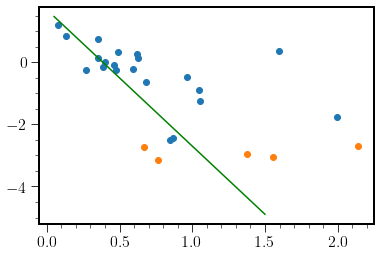

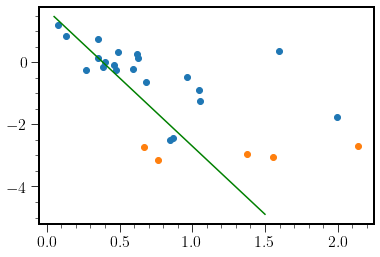

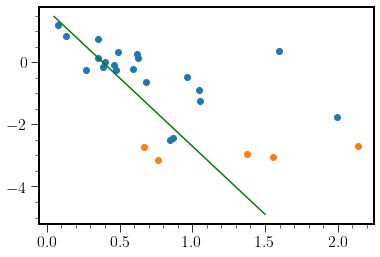

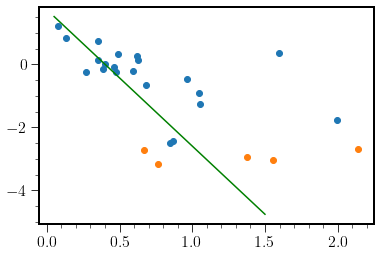

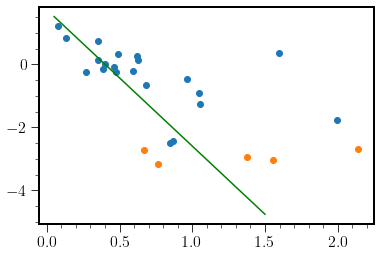

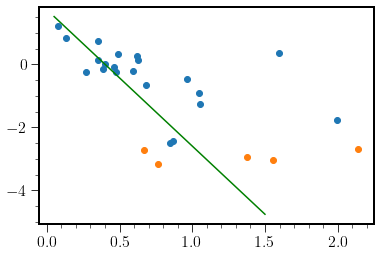

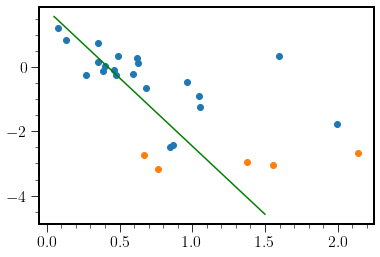

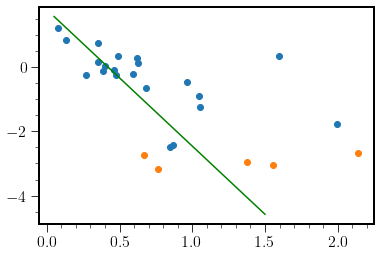

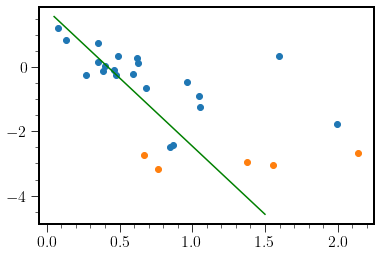

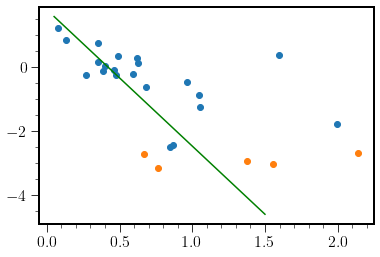

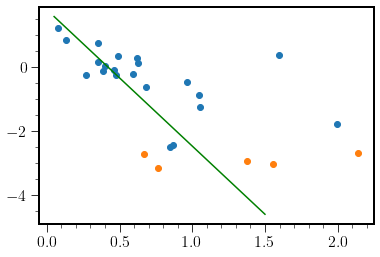

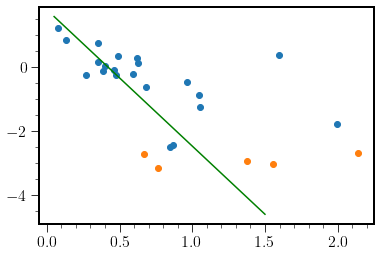

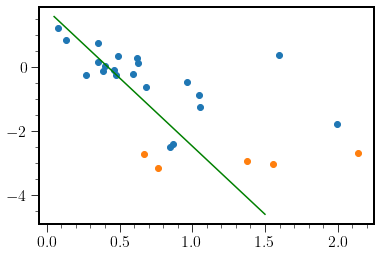

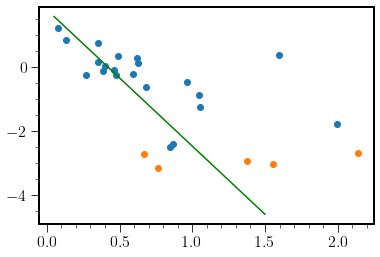

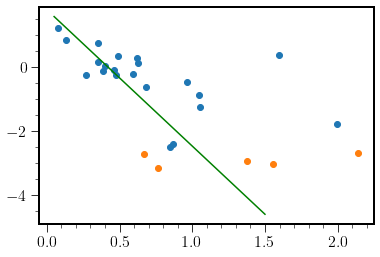

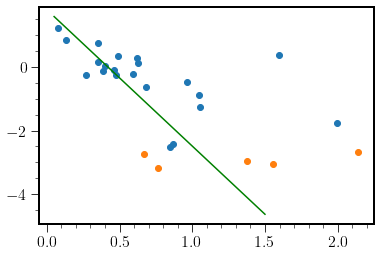

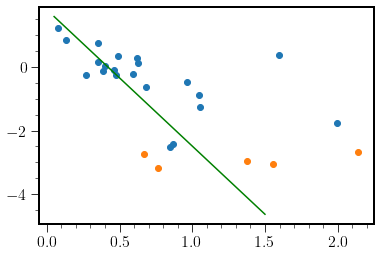

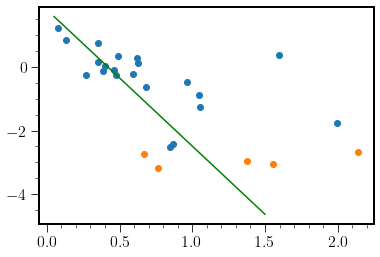

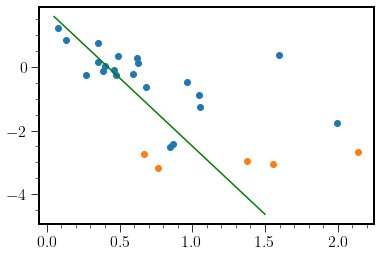

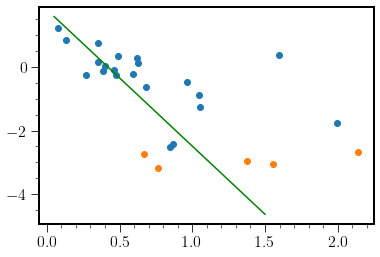

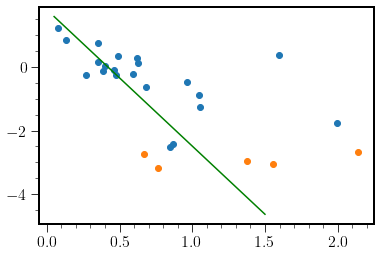

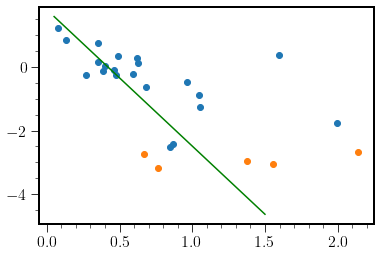

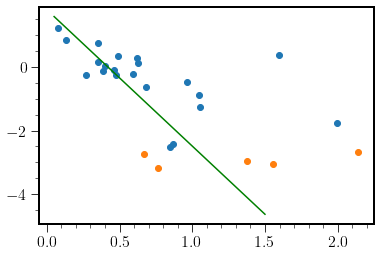

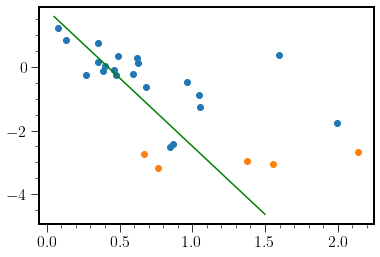

In [146]:
#LL_model_Hogg_only_abs = minimize(logL_Hogg_only_abs, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_all = minimize(logL_Hogg_all, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_with_lim = minimize(logL_Hogg_with_lim, np.array([1,-3]), method='L-BFGS-B')
#LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1,-3]), method='L-BFGS-B')

LL_model_Hogg_only_abs = minimize(logL_Hogg_only_abs, np.array([1,-3]), method='BFGS')
LL_model_Hogg_all = minimize(logL_Hogg_all, np.array([1,-3]), method='BFGS')
LL_model_Hogg_with_lim = minimize(logL_Hogg_with_lim, np.array([1,-3]), method='BFGS')
LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1,-3]), method='BFGS')

In [147]:
calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1)

yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341  0.3357577  -1.25878104  0.2646693
  0.01980263 -0.09321238 -0.2269006  -2.43041846 -0.64055473 -1.77785656
  0.35557434 -0.14041215 -2.50103603]
modeled_yi =  [-2.33000235  0.27153354  1.21359054  1.44180928  0.61934946 -2.67516371
  0.27194022 -0.9039858  -0.25043028 -0.31814526 -2.71352065 -0.8550151
  0.07529668 -0.18942993 -0.73799762 -1.90990878 -1.1316345  -6.73272989
 -5.02561728  0.13651781 -1.83902573]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02948403
 0.04347826 0.01500441 0.02842377 0.02573267 0.07746479 0.02148887
 0.0127451  0.02305159 0.01882058 0.26136364 0.0170778  0.0591716
 0.00630694 0.01956272 0.18292683]
mean_residual =  0.7938016855219975
sigma_intrisic =  0.924958667363819


0.924958667363819

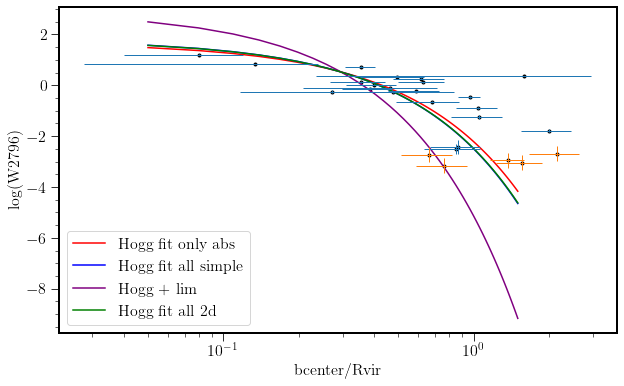

In [148]:
plt.figure(figsize = (10,6))
X = np.linspace(0.05, 1.5, 50)

plt.plot(X, model(LL_model_Hogg_only_abs['x'], X), linewidth = 1.5, c = "red", label = "Hogg fit only abs")
plt.plot(X, model(LL_model_Hogg_all['x'], X), linewidth = 1.5, c = "blue", label = "Hogg fit all simple")
plt.plot(X, model(LL_model_Hogg_with_lim['x'], X), linewidth = 1.5, c = "purple", label = "Hogg + lim")
plt.plot(X, model(LL_model_Hogg_total['x'], X), linewidth = 1.5, c = "green", label = "Hogg fit all 2d")

plt.errorbar(x1,y1,xerr =sig_x1, yerr=sig_y1, fmt = " ")
plt.errorbar(x2,y2,xerr =sig_x2, yerr=sig_y2, fmt = " ")

x = np.array(G5_noabs["b_center_kpc_norm2"])
y = np.array(np.log(G5_noabs["detection_limit"])) 
plt.scatter(x, y, c = "black", marker = ".")

x = np.array(G5_abs["b_center_kpc_norm2"])
y = np.array(np.log(G5_abs["REW_2796"]))
plt.scatter(x, y, c = "black", marker = ".")

plt.xscale("log")
#plt.yscale("log")
plt.xlabel("bcenter/Rvir")
plt.ylabel("log(W2796)")
plt.legend()

Final plot for the MgII EW:

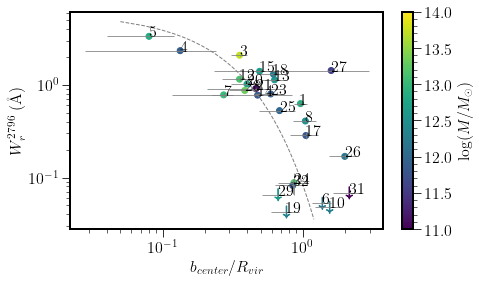

In [149]:
plt.figure(figsize = (7,4))
X = np.linspace(0.05, 1.2, 50)
plt.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [150]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [151]:
def logL_Hogg_total(param):
    theta = np.arctan(param[1])
    #print(sig_y1[0])
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)    
    return -LL

In [152]:
N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]
for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([1.5,-4]), method='BFGS')
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

N =  0
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341  0.3357577  -1.25878104  0.2646693
  0.01980263 -0.09321238 -0.2269006  -2.43041846 -0.64055473 -1.77785656
  0.35557434 -0.14041215 -2.50103603]
modeled_yi =  [-2.33000253  0.27153351  1.21359057  1.44180932  0.61934945 -2.6751639
  0.2719402  -0.90398589 -0.25043033 -0.31814531 -2.71352084 -0.85501519
  0.07529664 -0.18942998 -0.73799771 -1.90990892 -1.1316346  -6.73273031
 -5.0256176   0.13651777 -1.83902588]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02948403
 0.04347826 0.01500441 0.02842377 0.02573267 0.07746479 0.02148887
 0.0127451  0.02305159 0.01882058 0.26136364 0.0170778  0.0591716
 0.00630694 0.01956272 0.18292683]
mean_residual =  0.7938017889865824
sigma_intrisic =  0.9249587461184933
0.9249587461184933
N =  1
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341

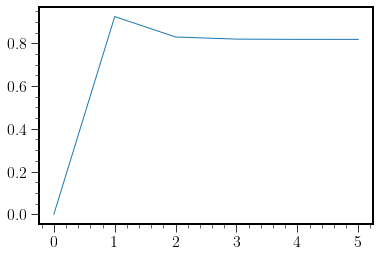

In [153]:
plt.plot(sigma_intrisic_list)

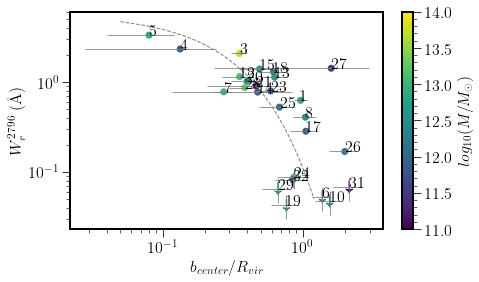

In [154]:
plt.figure(figsize = (7,4))
X = np.linspace(0.05, 1.2, 50)
plt.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$log_{10}(M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = (np.ones(len(G5_noabs["sig_REW_2796"]))*0.3*G5_noabs["detection_limit"]),\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [155]:
LL_model_Hogg_total

      fun: 26.65812286490924
 hess_inv: array([[ 0.17904898, -0.21501901],
       [-0.21501901,  0.33272378]])
      jac: array([4.76837158e-07, 7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 1.74709122, -3.94425887])

In [156]:
sig_y2

array([0.3, 0.3, 0.3, 0.3, 0.3])

In [157]:
0.17904898**0.5

0.4231417965646977

In [158]:
0.33272378**0.5

0.5768221389648632

The 0.1 A EW is reached for: 

In [159]:
np.exp(model(LL_model_Hogg_total['x'], 1.026))

0.10028708290700312

## Now for the plot with bmin

In [160]:
x1 = np.array(G5_abs["b_min_kpc"])
x2 = np.array(G5_noabs["b_min_kpc"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [161]:
 def model(param, x):
    # y = ax +b
    return param[0] + param[1]*x

def logL_Hogg_only_abs(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N = len(x1)
    LL = 0
    
    for i in range(N):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL

def logL_Hogg_all(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    N2 = len(x2)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
    
    return -LL


def logL_Hogg_with_lim(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)

    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sigi = sig_y2[i]
        X = (yi - model(param, xi))/sigi/((2**0.5))
        #X = (yi - model(param, xi))
        I = 0.5*(1 + math.erf(X))
        #print(param, " xi: ", xi, " yi: ", yi, ", model yi = ", model(param, xi), "yi - ymodel = ",yi - model(param, xi) )
        #print("I = ", I)
        #LL2i.append(np.log(I))
        LL += np.log(I)
    
    return -LL


def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    #print("theta = ", theta)

    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
    
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)
        print(" X = ", X, "----  I = ", I, "--- log(I) = ", np.log(I))
        LL2i.append(np.log(I))
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 150, 50)
    plt.figure()
    plt.errorbar(x1,y1, xerr = sig_x1, yerr = sig_y1, fmt = " ")
    plt.errorbar(x2,y2, xerr = sig_x2, yerr = sig_y2, fmt = " ")
    plt.scatter(x2,y2)
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")    
    return -LL

param =  0.0 -0.015
 X =  -3.6526269635095603 ----  I =  1.198378905553632e-07 --- log(I) =  -15.937125919507295
 X =  -1.7860105874696655 ----  I =  0.005771752327627833 --- log(I) =  -5.154779548272529
 X =  -2.8094883378992925 ----  I =  3.545426992873635e-05 --- log(I) =  -10.24726686290992
 X =  -2.099002348274025 ----  I =  0.0014965894007532565 --- log(I) =  -6.504566492560617
 X =  -0.4082540127874276 ----  I =  0.2818486979863888 --- log(I) =  -1.2663848839919614
LL =  -132561.09305028227
LL1 terms:  [-11.427509761123648, -6153.56315791481, -53270.75149927879, -14923.474465711079, -1.9727506210438897, -371.11315453673325, -293.9275824989481, -5351.3818337363, -311.28940678051475, -418.37314262652365, -62.61353546163516, -2303.3881734088995, -3271.606502502788, -210.81922437219356, -1040.7247201213886, -4.169722654739613, -92.86839538218828, -1.5772284268314554, -42729.21449703003, -1675.1887993311, -22.537624417339618]
LL2 terms:  [-15.937125919507295, -5.154779548272529, -10.

param =  0.004857792474260028 0.23745326666984723
 X =  -59.00856647716943 ----  I =  0.0 --- log(I) =  -inf
 X =  -149.0556857698062 ----  I =  0.0 --- log(I) =  -inf
 X =  -80.878030448436 ----  I =  0.0 --- log(I) =  -inf
 X =  -75.0859194607146 ----  I =  0.0 --- log(I) =  -inf
 X =  -100.0112233693543 ----  I =  0.0 --- log(I) =  -inf
LL =  -inf
LL1 terms:  [-28795.590692402562, -10557.726988349592, -1679125.1234812513, -489.7204139510302, -1633.2733596810515, -446114.7917308366, -54392.48981957561, -1121945.18320122, -149522.3340609507, -28441.923888838446, -101563.85430588057, -376177.1134847251, -787185.7964575704, -77350.78938991264, -428167.29791700834, -6139.20594804212, -358954.8114808878, -142511.13361986974, -6769736.44148519, -538036.7163043004, -7669.878574306429]
LL2 terms:  [-inf, -inf, -inf, -inf, -inf]
param =  0.002428896237130014 0.11122663333492362
 X =  -31.330596720339496 ----  I =  0.0 --- log(I) =  -inf
 X =  -73.63483759116826 ----  I =  0.0 --- log(I) =  -i

param =  2.4635657525943624 -0.04171078210670534
 X =  -3.603591250413558 ----  I =  1.7322595363689075e-07 --- log(I) =  -15.568669004256082
 X =  -11.93790327281931 ----  I =  0.0 --- log(I) =  -inf
 X =  -0.35734892547680047 ----  I =  0.30665030149067707 --- log(I) =  -1.1820472637354211
 X =  -0.18452354869534437 ----  I =  0.3970633330667889 --- log(I) =  -0.9236594818828775
 X =  -4.322332422915796 ----  I =  4.897935945713527e-10 --- log(I) =  -21.437037049137167
LL =  -inf
LL1 terms:  [-216.76808628030437, -16753.743816005383, -215.77165625779188, -9025.651450976273, -1153.3549251090355, -1080.8479741791807, -12.672419207720228, -5904.379395351868, -0.7687015650630605, -742.4702083572939, -399.07058454215155, -1360.3452728399936, -416.76045910216914, -906.2051997983635, -151.99534259692632, -0.4024059773910441, -782.7771763189779, -141.2476000390771, -51806.33721910979, -1142.6256034602168, -30.34310675305758]
LL2 terms:  [-15.568669004256082, -inf, -1.1820472637354211, -0.923

param =  1.103256178993146 -0.01397350902744461
 X =  -6.478060915505267 ----  I =  0.0 --- log(I) =  -inf
 X =  -1.42767449987686 ----  I =  0.02174170568090561 --- log(I) =  -3.828522942183425
 X =  -5.727273170659882 ----  I =  2.7755575615628914e-16 --- log(I) =  -35.820509837802945
 X =  -4.996124971924525 ----  I =  7.996936446375003e-13 --- log(I) =  -27.85454768478774
 X =  -3.4135991907112633 ----  I =  6.910862609399437e-07 --- log(I) =  -14.185001186035178
LL =  -inf
LL1 terms:  [-185.70823063827694, -573.5861969681189, -1794.7515627532582, -306.55951356078367, -323.5520785986617, -99.76861667072318, -3.298313352089352, -274.13671524810786, -131.01457357705198, -113.00777011128673, -12.14925838683304, -81.0331822843905, -61.630015381442604, -420.74279631066764, -143.5478316999308, -28.483877013779743, -1483.6356082459263, -181.38661561587253, -5126.624988516387, -4.3975283977393405, -87.39920026777014]
LL2 terms:  [-inf, -3.828522942183425, -35.820509837802945, -27.854547684

param =  1.0512176435262768 -0.00971175389383995
 X =  -7.289695307630774 ----  I =  0.0 --- log(I) =  -inf
 X =  -3.8512385761866055 ----  I =  2.568907969680012e-08 --- log(I) =  -17.47719984986839
 X =  -6.92232724275867 ----  I =  0.0 --- log(I) =  -inf
 X =  -6.1053942898453775 ----  I =  0.0 --- log(I) =  -inf
 X =  -4.9721837374821245 ----  I =  1.0199618927231313e-12 --- log(I) =  -27.611255849405634
LL =  -inf
LL1 terms:  [-248.97448442334525, -493.09960236636175, -635.1631070458149, -399.57755219878635, -319.34189260503507, -413.6753420818705, -26.98792045804622, -0.010536877083362277, -288.1537163668381, -153.52658107326062, -72.6471980977812, -0.1999734270590839, -436.89816424343655, -568.9836039423496, -467.15455573254116, -42.045556422935505, -2174.9840441100214, -370.1454088443994, -901.8784466949487, -176.5359401657097, -111.20909227106623]
LL2 terms:  [-inf, -17.47719984986839, -inf, -inf, -27.611255849405634]
param =  1.051217658427438 -0.00971175389383995
 X =  -7.28

param =  1.1530149964364158 -0.018007093368291698
 X =  -5.711074300101207 ----  I =  3.3306690738754696e-16 --- log(I) =  -35.63818828100899
 X =  -0.8649404373901636 ----  I =  0.11062510089980432 --- log(I) =  -2.201608263565833
 X =  -4.59739484312577 ----  I =  3.970918038831428e-11 --- log(I) =  -23.949438710930043
 X =  -3.947438554832925 ----  I =  1.1852839154613548e-08 --- log(I) =  -18.25069840695601
 X =  -1.9396535049904453 ----  I =  0.0030432529609968895 --- log(I) =  -5.794828282703091
LL =  -20146.680206750152
LL1 terms:  [-134.52998593557805, -657.7568775638445, -3425.068798412845, -228.4115045973203, -327.83519118922794, -0.04167477747450368, -1.8867798294199452, -1043.3537345423388, -38.76108666478661, -80.61500407874749, -1.6328645577320433, -321.42446432880377, -20.019217420428067, -301.54605597305994, -8.313294778454459, -18.084561694825613, -952.0244920928598, -64.1896063475541, -12295.985568599053, -71.82965396625522, -67.53502745437719]
LL2 terms:  [-35.638188

param =  1.1453973523227698 -0.01736938184729494
 X =  -5.83292271543181 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.5018894896720398 ----  I =  0.23892062063395225 --- log(I) =  -1.4316239134571154
 X =  -4.776616603388335 ----  I =  7.134071111636331e-12 --- log(I) =  -25.666139061052135
 X =  -4.113823837083466 ----  I =  2.9809051893536775e-09 --- log(I) =  -19.63103882773658
 X =  -2.1732724712547817 ----  I =  0.0010579198252822497 --- log(I) =  -6.8514507279238215
LL =  -18412.547957523166
LL1 terms:  [-142.1612651521697, -645.232343600696, -3127.950107706144, -239.2749820556262, -327.29040155014, -3.0871220403944513, -0.748657791098205, -888.0471952917081, -49.80655234826954, -85.49970561810642, -0.27296729976368267, -272.5415916443638, -6.309666692530259, -319.3461543736688, -18.757732146655265, -19.57813435755232, -1028.918102051277, -78.8089212941433, -10951.216002751753, -46.16860564691766, -70.52154582977893]
LL2 terms:  [-37.42994775023705, 

param =  1.1415885228153662 -0.017050518636215966
 X =  -5.893848538901915 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.3203595819645183 ----  I =  0.3252538971740686 --- log(I) =  -1.1231491795734712
 X =  -4.866229769634922 ----  I =  2.9531932455029164e-12 --- log(I) =  -26.54813407490731
 X =  -4.197018614351505 ----  I =  1.4649294555191261e-09 --- log(I) =  -20.34145874886605
 X =  -2.2900848760416075 ----  I =  0.000600444067045125 --- log(I) =  -7.417841064753887
LL =  -17596.89428200441
LL1 terms:  [-146.05596842041075, -639.0154580536833, -2984.4404181656387, -244.801249517607, -327.01821416865147, -6.418517215689865, -0.3734033800780459, -815.08278541986, -55.84804918619356, -87.99603290577181, -0.020957361156992767, -249.61074089734532, -2.343005850155577, -328.43791133978993, -25.552118919287523, -20.347160789119872, -1068.4857658869828, -86.68072918553418, -10308.010342598958, -35.45584579871188, -72.03907612544515]
LL2 terms:  [-37.429947750

param =  1.1399836809669195 -0.016921054680100925
 X =  -5.918447842683399 ----  I =  5.551115123125783e-17 --- log(I) =  -37.42994775023705
 X =  -0.24679294257798534 ----  I =  0.36353792571012267 --- log(I) =  -1.0118716526226648
 X =  -4.902476628722973 ----  I =  2.057853887293959e-12 --- log(I) =  -26.909357478464745
 X =  -4.230659496957553 ----  I =  1.0949469109178267e-09 --- log(I) =  -20.63255995803336
 X =  -2.3373750944837233 ----  I =  0.00047395507768044354 --- log(I) =  -7.654398013586494
LL =  -17277.80422912574
LL1 terms:  [-147.63133711629604, -636.2284272696699, -2928.178633981993, -247.23619840946853, -326.8762995353371, -8.107313215021971, -0.2588921893898167, -786.504962063636, -58.37748858536136, -88.98956243749001, -6.482769834014696e-05, -240.64760928524254, -1.2894434659690592, -332.1004597118202, -28.58643754748986, -20.6621910031261, -1084.6047471436734, -89.97051821440905, -10053.726485307472, -31.533040365185038, -72.65598259704745]
LL2 terms:  [-37.42994

param =  1.1397580021774574 -0.016902865807909236
 X =  -5.921903398600587 ----  I =  0.0 --- log(I) =  -inf
 X =  -0.23645778375343462 ----  I =  0.36903818887746787 --- log(I) =  -0.996855147403763
 X =  -4.90756859295931 ----  I =  1.9556578578772132e-12 --- log(I) =  -26.960294478901762
 X =  -4.2353853378759565 ----  I =  1.0508877656967286e-09 --- log(I) =  -20.67363053886353
 X =  -2.3440185813050767 ----  I =  0.0004583092821844881 --- log(I) =  -7.68796631314243
LL =  -inf
LL1 terms:  [-147.85326856931235, -635.8363856027478, -2920.3208229243564, -247.57987802230184, -326.8562516004927, -8.360333189595272, -0.2444827748204, -782.531364044151, -58.737267439649784, -89.12948569763572, -0.0008714096822591581, -239.40168760623274, -1.1664689666302541, -332.6164183611586, -29.02629148302269, -20.706639518828556, -1086.8784612740455, -90.43757430339433, -10018.260307925948, -31.00041455071287, -72.74285104541373]
LL2 terms:  [-inf, -0.996855147403763, -26.960294478901762, -20.673630

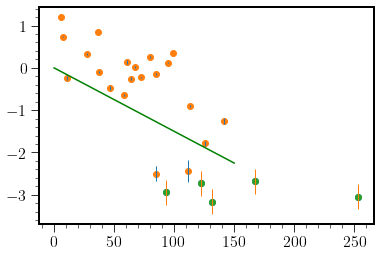

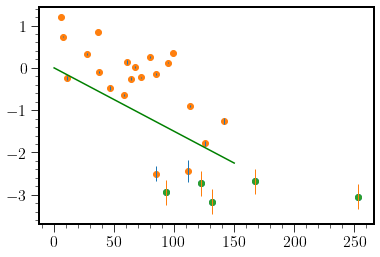

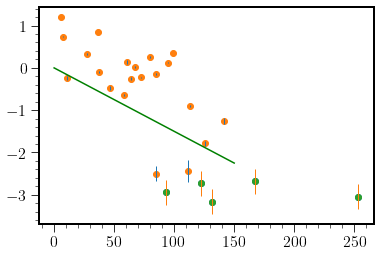

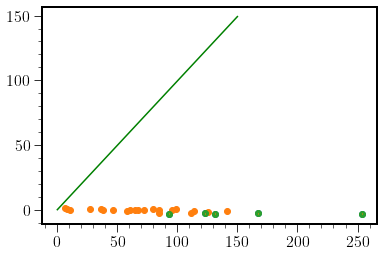

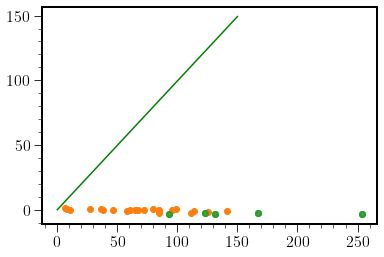

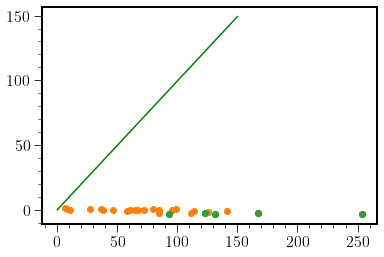

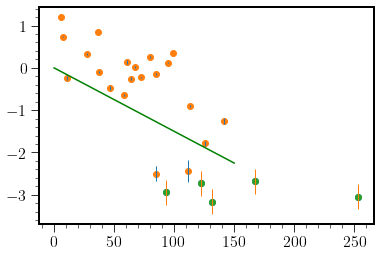

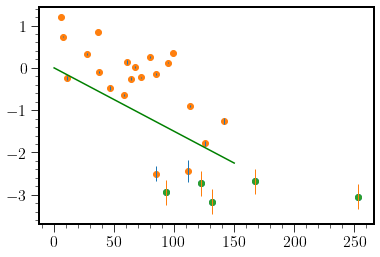

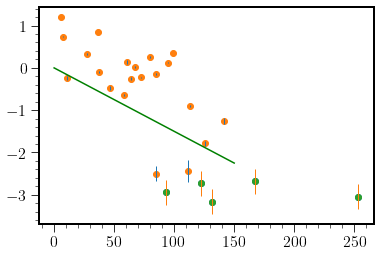

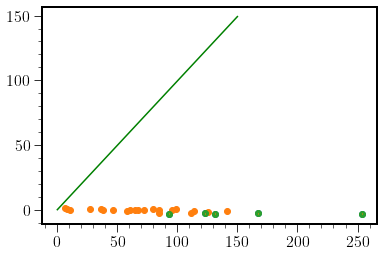

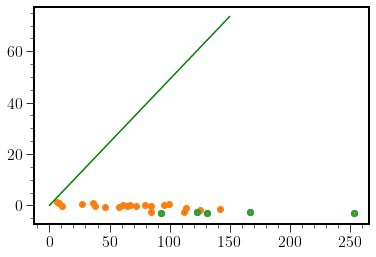

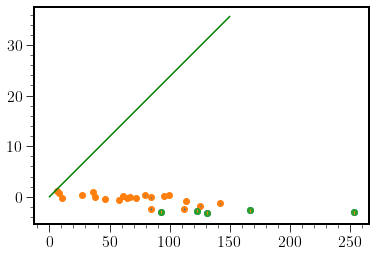

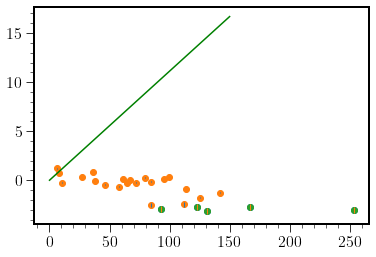

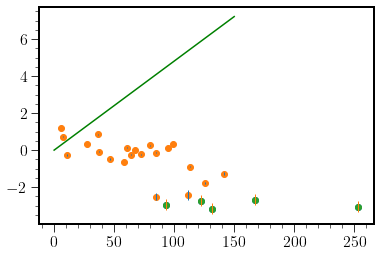

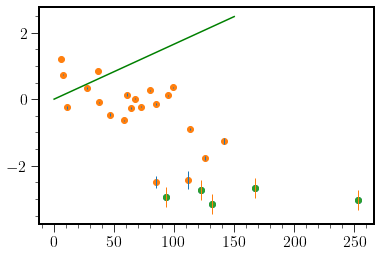

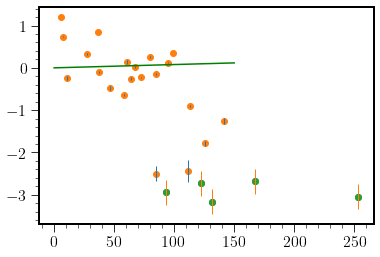

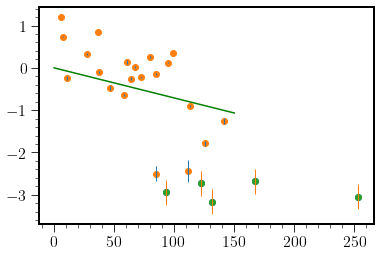

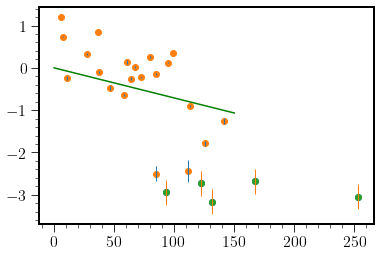

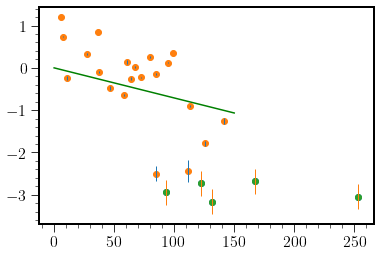

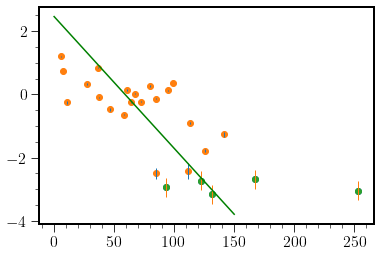

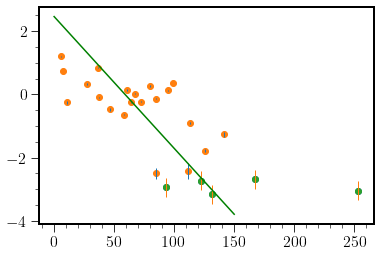

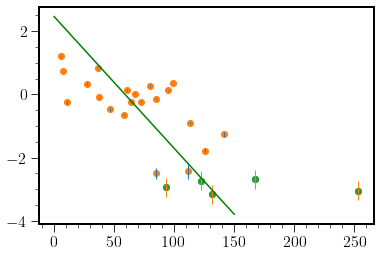

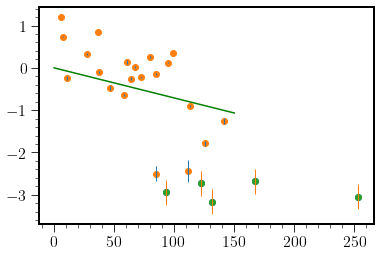

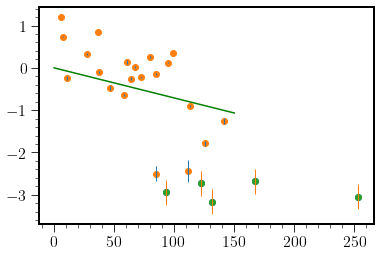

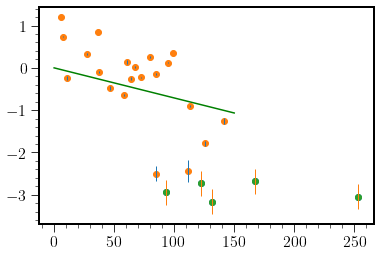

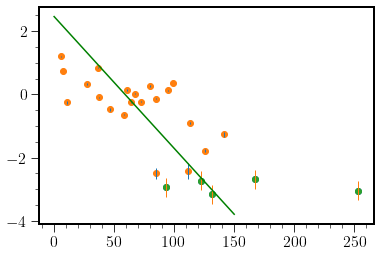

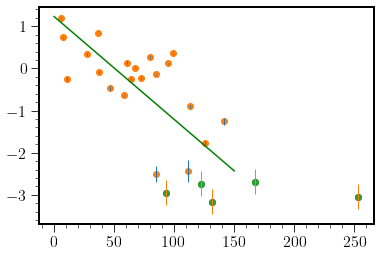

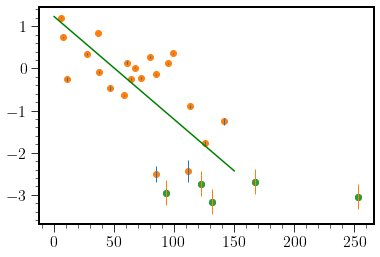

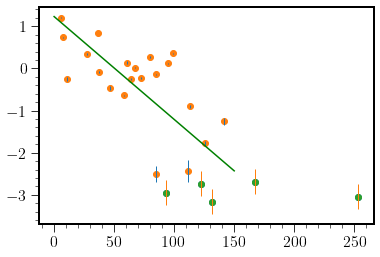

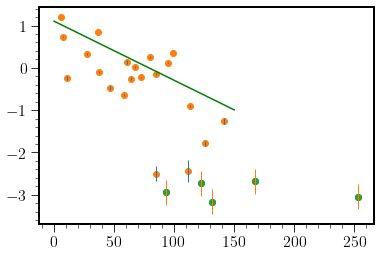

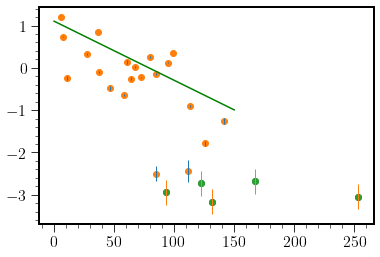

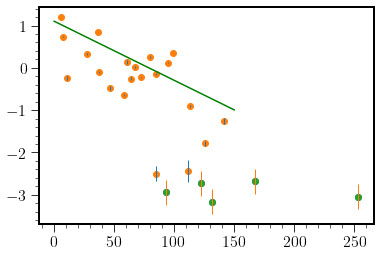

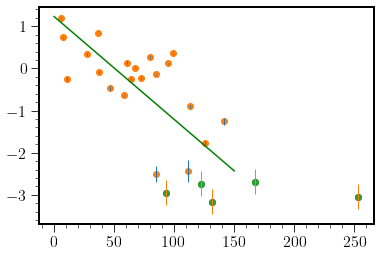

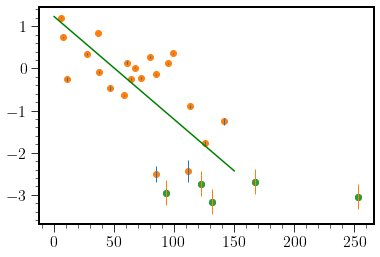

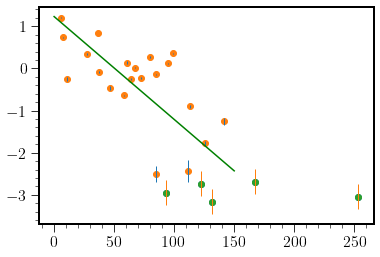

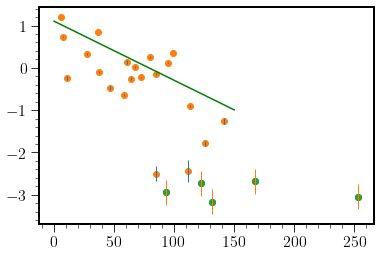

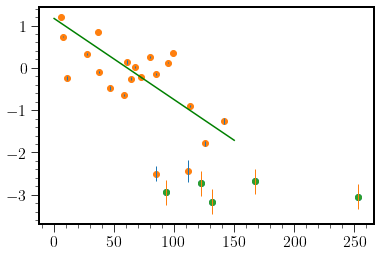

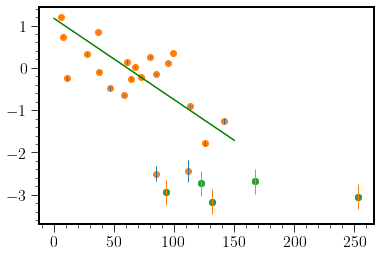

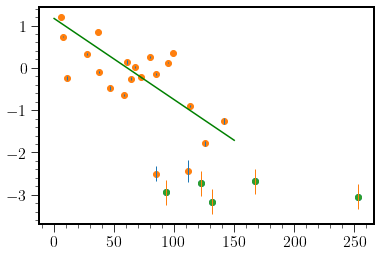

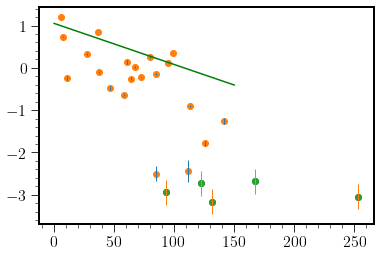

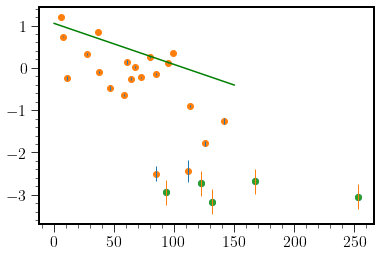

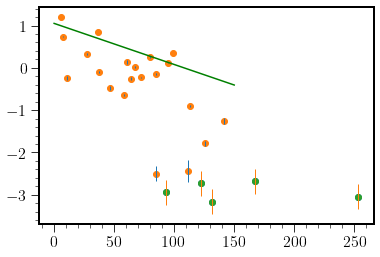

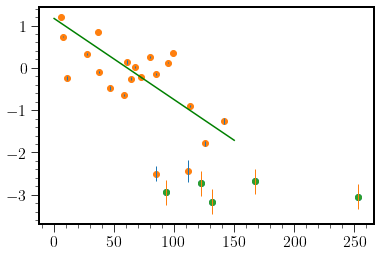

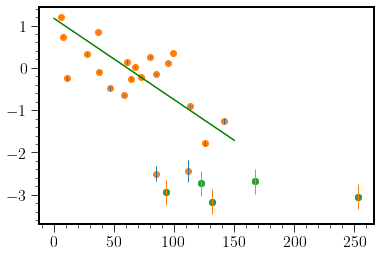

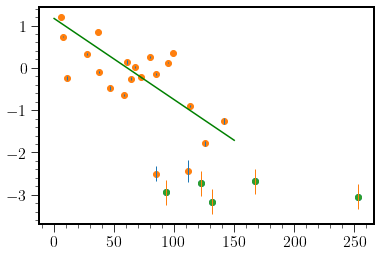

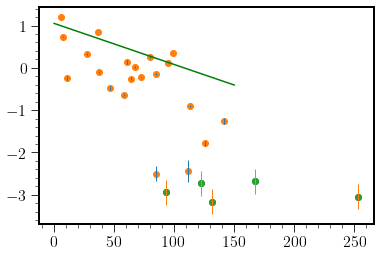

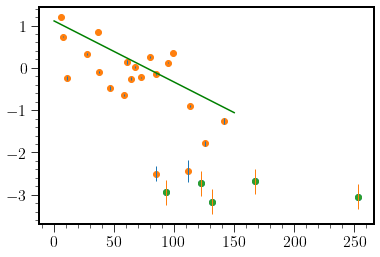

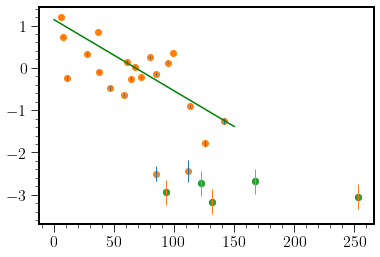

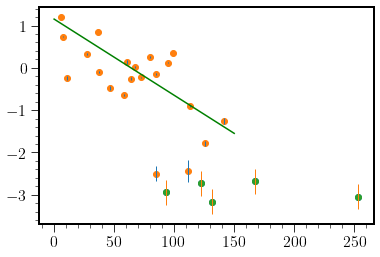

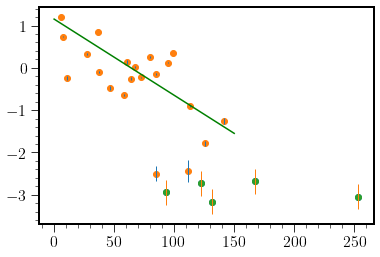

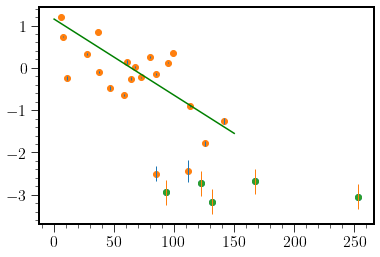

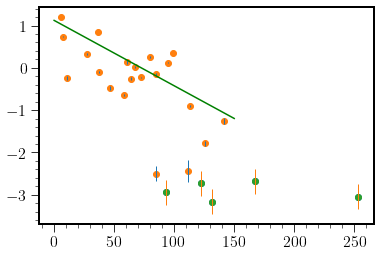

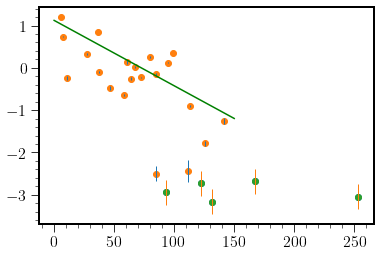

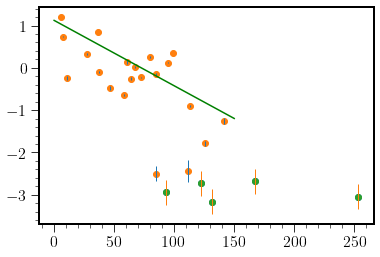

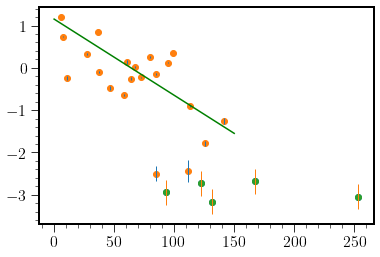

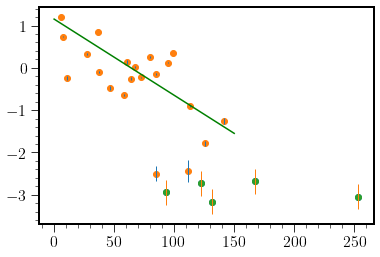

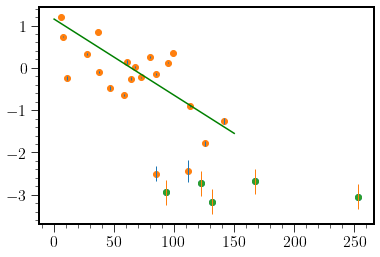

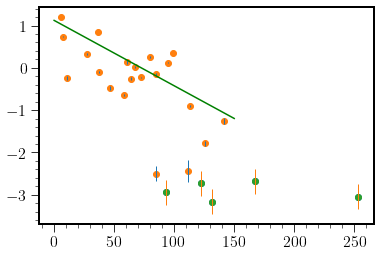

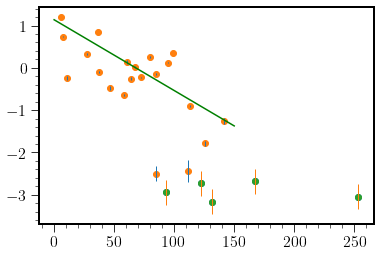

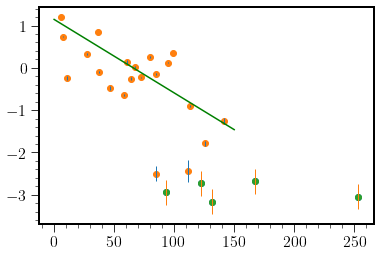

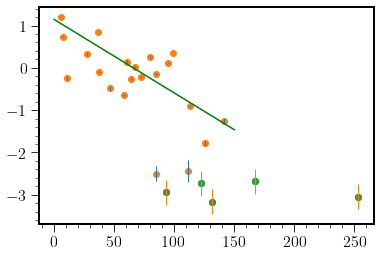

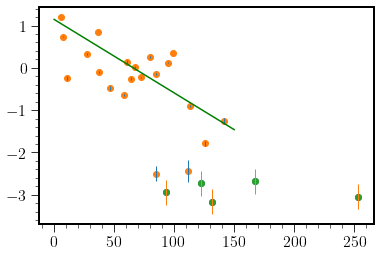

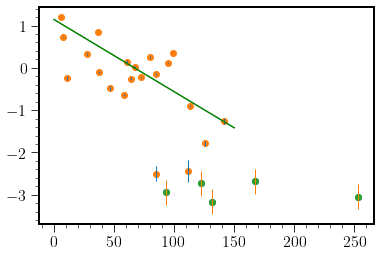

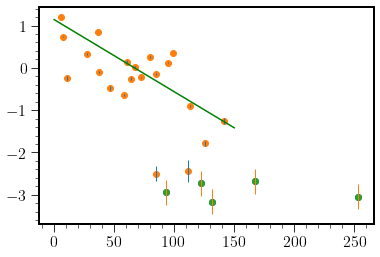

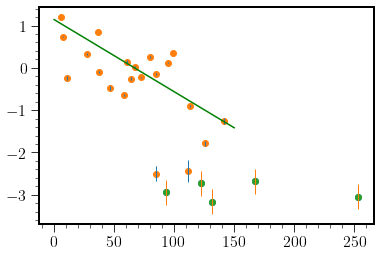

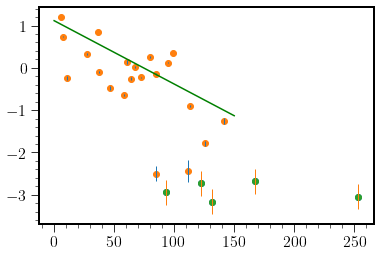

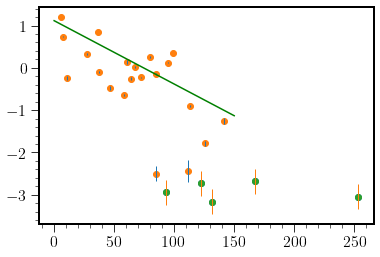

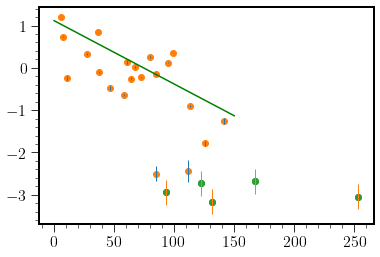

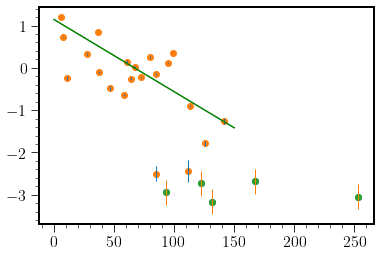

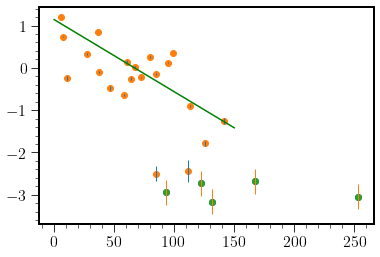

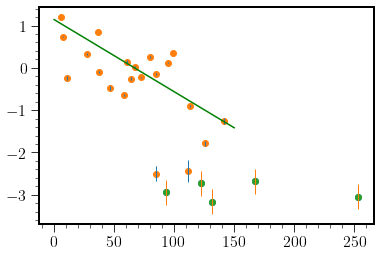

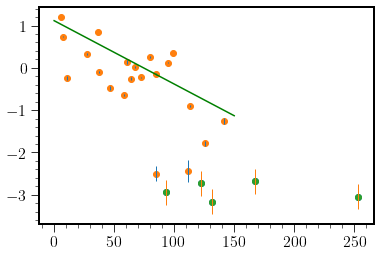

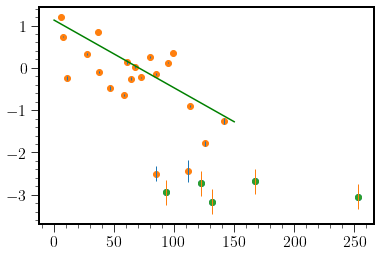

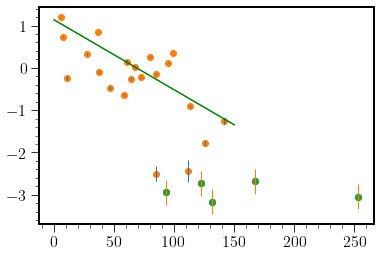

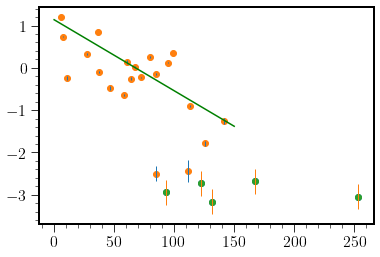

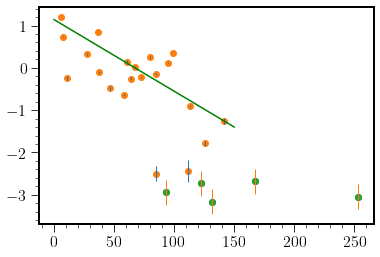

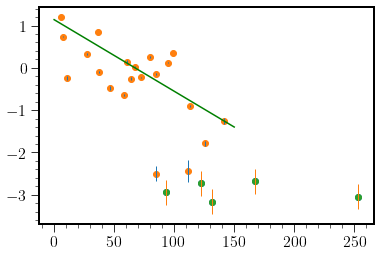

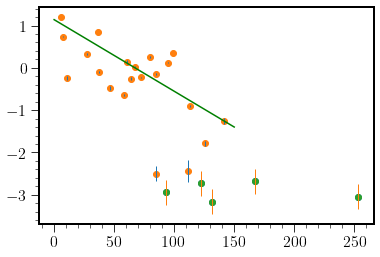

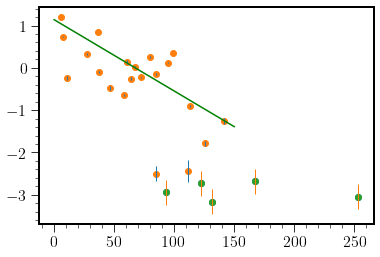

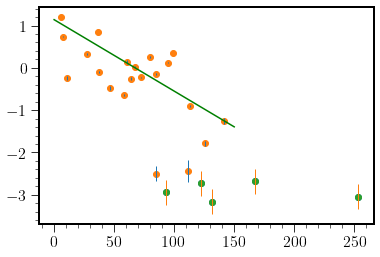

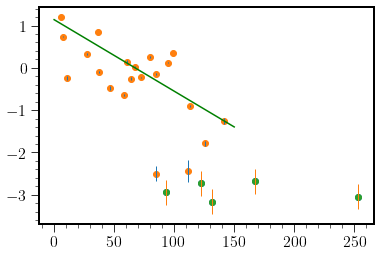

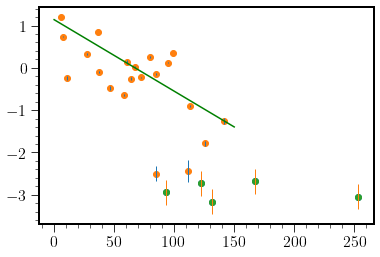

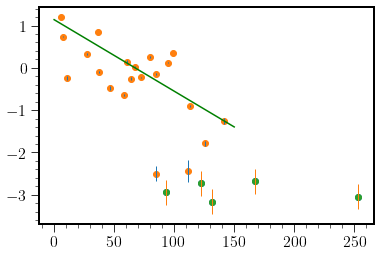

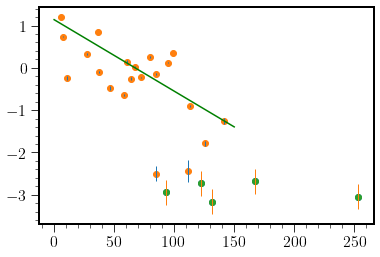

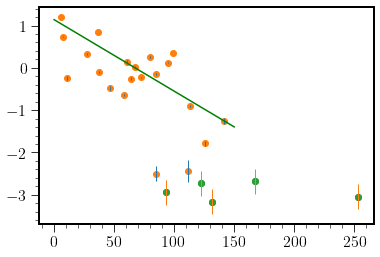

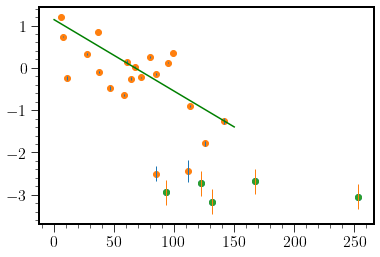

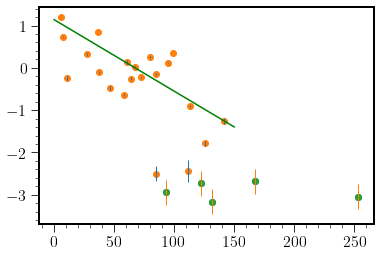

In [162]:
#LL_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='L-BFGS-B')
#LL_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='CG')
LL_Hogg_total_bmin = minimize(logL_Hogg_total, np.array([0,-0.015]), method='BFGS')

In [163]:
LL_Hogg_total_bmin

      fun: 17596.89483358717
 hess_inv: array([[ 2.07785533e-05, -2.92068271e-07],
       [-2.92068271e-07,  6.16777322e-09]])
      jac: array([  -37016.09228516, -2945723.27050781])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 5
     njev: 21
   status: 2
  success: False
        x: array([ 1.14158851, -0.01705052])

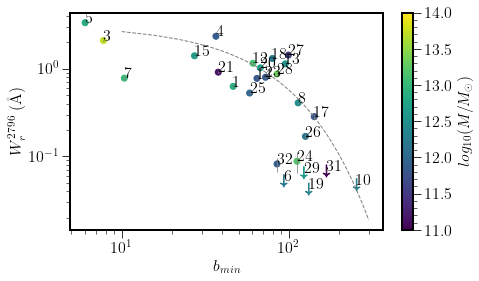

In [164]:
plt.figure(figsize = (7,4))
X = np.linspace(10, 300, 50)
plt.plot(X, np.exp(model(LL_Hogg_total_bmin['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "$log_{10}(M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

## now with the intrisic scatter computation

In [165]:
x1 = np.array(G5_abs["b_min_kpc"])
x2 = np.array(G5_noabs["b_min_kpc"])
y1 = np.array(np.log(G5_abs["REW_2796"]))
y2 = np.array(np.log(G5_noabs["detection_limit"]))
#sig_x1 = np.ones(len(x1))*10
#sig_x2 = np.ones(len(x2))*10
sig_x1 = np.zeros(len(x1))
sig_x2 = np.zeros(len(x2))
sig_y1 = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
sig_y2 = np.array(np.ones(len(x2))*0.3)

In [166]:
def logL_Hogg_total(param):
    theta = np.arctan(param[1])
    #print(sig_y1[0])
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I)    
    return -LL

In [167]:
N = 15
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]
for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(G5_abs["sig_REW_2796"]/G5_abs["REW_2796"])
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([0,-0.015]), method='BFGS')
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

N =  0
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341  0.3357577  -1.25878104  0.2646693
  0.01980263 -0.09321238 -0.2269006  -2.43041846 -0.64055473 -1.77785656
  0.35557434 -0.14041215 -2.50103603]
modeled_yi =  [ 0.35095596  1.00910598  0.51771003  1.03860338  0.96494513 -0.79330435
  0.10218889 -0.48093885  0.04421713  0.67713238 -1.27464049 -0.21546227
 -0.00778695  0.49759042 -0.09235753 -0.76312493  0.14890731 -0.9987631
 -0.54999345 -0.305148   -0.3053185 ]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02948403
 0.04347826 0.01500441 0.02842377 0.02573267 0.07746479 0.02148887
 0.0127451  0.02305159 0.01882058 0.26136364 0.0170778  0.0591716
 0.00630694 0.01956272 0.18292683]
mean_residual =  -0.30844057910860334
sigma_intrisic =  0.4727718563480047
0.4727718563480047
N =  1
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.256183

yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341  0.3357577  -1.25878104  0.2646693
  0.01980263 -0.09321238 -0.2269006  -2.43041846 -0.64055473 -1.77785656
  0.35557434 -0.14041215 -2.50103603]
modeled_yi =  [-0.26578328  0.43469504 -0.08830457  0.46608954  0.38769404 -1.48363561
 -0.53054957 -1.15118062 -0.59224973  0.08137087 -1.99592843 -0.86863016
 -0.6475984  -0.10971816 -0.73760805 -1.45151523 -0.48082649 -1.70230825
 -1.2246764  -0.96408394 -0.96426542]
sigma_mi =  [0.04784689 0.00767386 0.00428082 0.00749625 0.04749679 0.02948403
 0.04347826 0.01500441 0.02842377 0.02573267 0.07746479 0.02148887
 0.0127451  0.02305159 0.01882058 0.26136364 0.0170778  0.0591716
 0.00630694 0.01956272 0.18292683]
mean_residual =  0.33220375588988577
sigma_intrisic =  0.406110207544941
0.406110207544941
N =  12
yi =  [-0.46680874  0.73476886  0.84844006  1.20447268 -0.24974423 -0.89894209
  0.13976194  0.12486898 -0.25618341  0.33

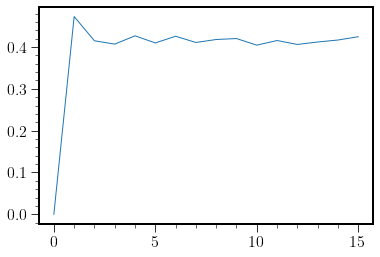

In [168]:
plt.plot(sigma_intrisic_list)

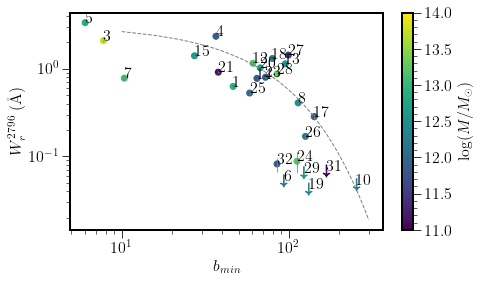

In [169]:
plt.figure(figsize = (7,4))
X = np.linspace(10, 300, 50)
plt.plot(X, np.exp(model(LL_Hogg_total_bmin['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

plt.errorbar(G5_abs["b_min_kpc"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"],\
             yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_min_kpc"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")

plt.errorbar(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], xerr = G5_noabs["b_center_kpc_norm2_err"], \
             yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_min_kpc"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_min_kpc"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [170]:
LL_Hogg_total_bmin['x']

array([ 1.14158851, -0.01705052])

In [171]:
LL_Hogg_total_bmin

      fun: 17596.89483358717
 hess_inv: array([[ 2.07785533e-05, -2.92068271e-07],
       [-2.92068271e-07,  6.16777322e-09]])
      jac: array([  -37016.09228516, -2945723.27050781])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 87
      nit: 5
     njev: 21
   status: 2
  success: False
        x: array([ 1.14158851, -0.01705052])

In [172]:
(2.07785533e-05)**0.5

0.004558349843967661

In [173]:
(6.16777322e-09)**0.5

7.853517186585893e-05

# Normalized by the Rvir of the closest galaxy

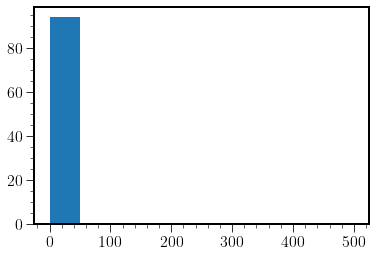

In [174]:
plt.hist(G3["Rvir_closest"], range = (0,  500));

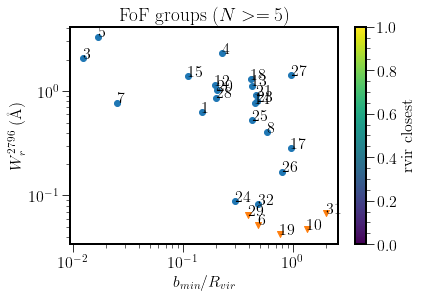

In [175]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_min_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5")
plt.scatter(G5_noabs["b_min_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5")
plt.colorbar(label = "rvir closest")

X = np.array(G5_abs["b_min_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_min_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

(0.01, 5)

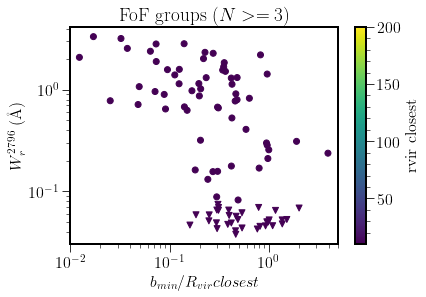

In [176]:
plt.title("FoF groups ($N >= 3$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G3_abs["b_min_kpc_norm2"], G3_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c=G3_abs["Rvir_closest"], vmin = 10, vmax = 200)
plt.scatter(G3_noabs["b_min_kpc_norm2"], G3_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
           c=G3_noabs["Rvir_closest"], vmin = 10, vmax = 200)
plt.colorbar(label = "rvir closest")

X = np.array(G3_abs["b_min_kpc_norm2"])
Y = np.array(G3_abs["REW_2796"])
txt = np.array(G3_abs["ID"])

#for i in range(len(G3_abs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G3_noabs["b_min_kpc_norm2"])
Y = np.array(G3_noabs["detection_limit"])
txt = np.array(G3_noabs["ID"])

#for i in range(len(G3_noabs)):
#    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{min}/R_{vir} closest$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlim((0.01, 5))

# Investigation other parameters

### Group mass

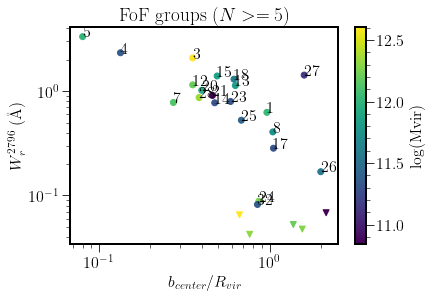

In [177]:
plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]))
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = np.log10(G5_noabs["Mvir_sigma2"]))
plt.colorbar(label = "log(Mvir)")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

In [178]:
G[["ID", "N_gal", "mean_z", "zqso_sdss", "QSO_is_behind", "MgII_2796_lim", "REW_2796"]].head(30)

ID  N_gal    mean_z  zqso_sdss  QSO_is_behind  MgII_2796_lim  REW_2796
0    1     21  0.987775      1.532           True          10.90     0.627
1    2     21  0.937542      0.938          False          10.52     0.118
2    3     13  0.831174      1.927           True          10.71     2.085
3    4     11  0.744963      1.925           True            NaN     2.336
4    5     10  0.637529      1.222           True          10.72     3.335
5    6     10  0.901378      1.925           True            NaN     0.000
6    7      8  0.606026      1.798           True          11.01     0.779
7    8      7  1.331220      1.605           True          10.52     0.407
8    9      7  1.482316      1.484          False          10.42     0.000
9   10      7  1.099736      1.484           True          10.65     0.000
10  11      7  0.872727      0.875          False          10.63     0.000
11  12      7  1.432120      2.389           True          10.86     1.150
12  13      6  1.214250      1.669           True          10.61     1.133
13  14      6  0.940495      1.770           True          10.77     0.774
14  15      6  1.137177      1.798           True          11.00     1.399
15  16      6  0.260037      1.618           True            inf       NaN
16  17      5  0.823512      1.770           True          10.75     0.284
17  18      5  0.970740      2.238           True          10.89     1.303
18  19      5  1.356080      1.927           True          10.67     0.000
19  20      5  0.607382      1.294           True            NaN     1.020
20  21      5  0.987006      1.880           True          10.75     0.911
21  22      5  3.547924      1.925          False            inf     0.000
22  23      5  0.806336      1.669           True          10.54     0.797
23  24      5  1.100206      1.222           True          10.77     0.088
24  25      5  1.295142      1.925           True          10.38     0.527
25  26      5  1.339878      1.595           True          10.41     0.169
26  27      5  1.221390      2.308           True          10.43     1.427
27  28      5  1.043106      1.669           True          10.59     0.869
28  29      5  0.533110      0.875           True          10.81     0.000
29  30      5  0.630146      0.875           True            inf     0.000

Text(0, 0.5, 'M from M*')

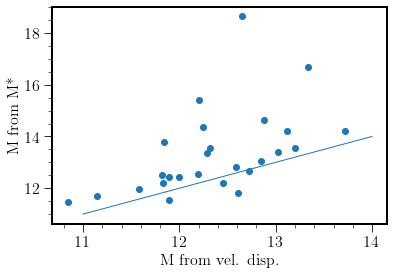

In [179]:
plt.scatter(np.log10(G5["Mvir_sigma2"]), G5["Mhalo"])
plt.plot([11, 14], [11, 14])
plt.xlabel("M from vel. disp.")
plt.ylabel("M from M*")

# Column density

In [180]:
G5_abs["NHI"], G5_abs["sigma_NHI"] = gid.Fukugita(G5_abs["REW_2796"], G5_abs["sig_REW_2796"], G5_abs["center_z"])
G5_abs["NHI_limit"], _ = gid.Fukugita(G5_abs["detection_limit"], 1, G5_abs["center_z"])
G5_noabs["NHI"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["REW_2796"], G5_noabs["sig_REW_2796"], G5_noabs["center_z"])
G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"] = gid.Fukugita(G5_noabs["detection_limit"], \
                        0.2*G5_noabs["detection_limit"], G5_noabs["center_z"])

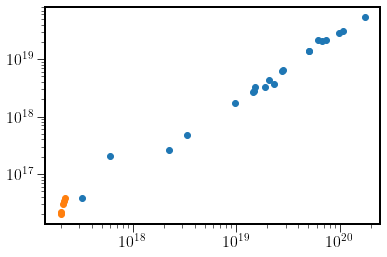

In [181]:
plt.scatter(G5_abs["NHI"], G5_abs["sigma_NHI"])
plt.scatter(G5_noabs["NHI_limit"], G5_noabs["sigma_NHI"])
plt.xscale("log")
plt.yscale("log")

In [182]:
G5_noabs["sigma_NHI"]

5     2.975192e+16
9     3.373818e+16
18    3.852419e+16
28    2.162482e+16
30    1.994972e+16
Name: sigma_NHI, dtype: float64

We cannot make a single plot with just 2 different y axis (1 for W2796 and 1 for NHI) because the NHI conversion depends on the redshift...

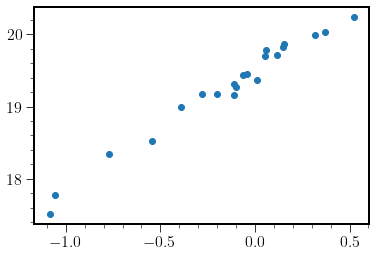

In [183]:
plt.scatter(np.log10(G5["REW_2796"]), np.log10(G5["NHI"]))

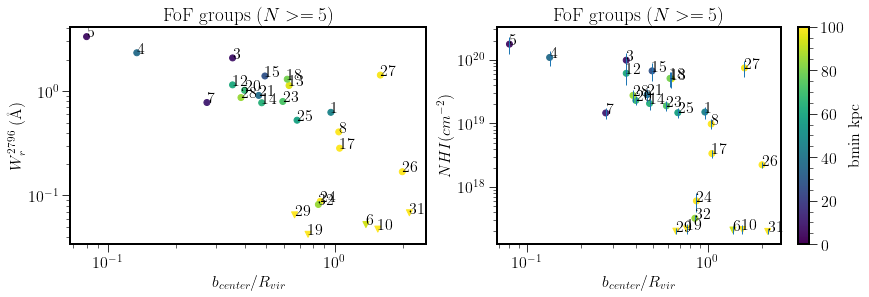

In [184]:
plt.figure(figsize = (14,4))
plt.subplot(121)
plt.title("FoF groups ($N >= 5$)")
##plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

plt.subplot(122)
plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"], yerr = G5_noabs["sigma_NHI"], fmt = 'none')
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$NHI (cm^{-2})$")
#plt.grid()
plt.xscale("log")
plt.yscale("log")

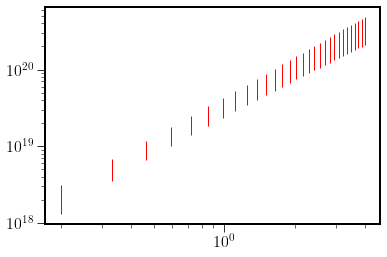

In [185]:
W = np.linspace(0.2, 4, 30)
N, sig = gid.Fukugita(W, 0.05, 1)
#plt.errorbar(G5_abs["REW_2796"], G5_abs["NHI"], yerr = G5_abs["sigma_NHI"], fmt = 'none')
#plt.scatter(G5_abs["REW_2796"], G5_abs["NHI"], c = G5_abs["center_z"])
plt.errorbar(W, N, yerr = sig, fmt = 'none', c = "r")
#plt.scatter(W, N)
#plt.colorbar()
plt.yscale("log")
plt.xscale("log")

In [186]:
G5[["REW_2796", "sig_REW_2796", "NHI", "sigma_NHI"]]

REW_2796  sig_REW_2796           NHI     sigma_NHI
0      0.627         0.030  1.508940e+19  3.312701e+18
2      2.085         0.016  9.870159e+19  2.806266e+19
3      2.336         0.010  1.089312e+20  3.038530e+19
4      3.335         0.025  1.764600e+20  5.510017e+19
5      0.000         0.000  0.000000e+00           NaN
6      0.779         0.037  1.459763e+19  2.707384e+18
7      0.407         0.012  9.795088e+18  1.746717e+18
9      0.000         0.000  0.000000e+00           NaN
11     1.150           NaN  6.137080e+19           NaN
12     1.133         0.017  5.022818e+19  1.367273e+19
13     0.774         0.022  2.057496e+19  4.259393e+18
14     1.399         0.036  6.703586e+19  2.060064e+19
16     0.284         0.022  3.363939e+18  4.762597e+17
17     1.303         0.028  5.111697e+19  1.367921e+19
18     0.000         0.000  0.000000e+00           NaN
19     1.020         0.013  2.297952e+19  3.711236e+18
20     0.911         0.021  2.832392e+19  6.399654e+18
22     0.797         0.015  1.890464e+19  3.287545e+18
23     0.088         0.023  6.044450e+17  2.059356e+17
24     0.527         0.009  1.473041e+19  2.747685e+18
25     0.169         0.010  2.235366e+18  2.580861e+17
26     1.427         0.009  7.457895e+19  2.150385e+19
27     0.869         0.017  2.758262e+19  6.126835e+18
28     0.000         0.000  0.000000e+00           NaN
30     0.000         0.000  0.000000e+00           NaN
31     0.082         0.015  3.221807e+17  3.876342e+16

# With DM profile

On the NHI vs b plot, we can add the standard NFW DM profile. But we must care about the fact that the NHI is a column density, ie a density integrated along the LOS. In order to compare things consistently, it is necessary to convert NFW density into a column density (a cut is necessary or it will diverge) or alternatively to convert the column density into a density (with a strong assumption of a spherical distribution of NHI?)...

In [187]:
from scipy import integrate

Text(0, 0.5, 'log10(rho)')

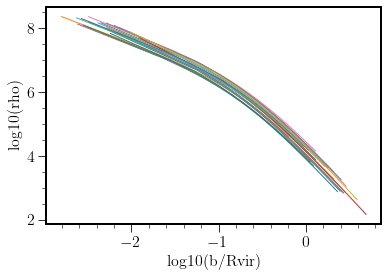

In [188]:
b = np.linspace(1, 400)
rho = gid.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Mvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    plt.plot(np.log10(b/r), np.log10(rho))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

In [189]:
def nfw_rho_2(theta, b, rhoO, rs):
    K = b/np.cos(theta)/rs
    D = K*(1+K)**2
    rho = rho0*b/D/((np.cos(theta))**2)
    return rho

Text(0, 0.5, 'rho')

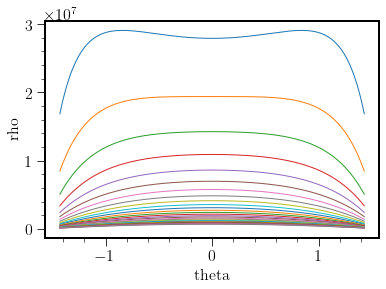

In [190]:
t = np.linspace(-np.pi/2.2, np.pi/2.2, num = 200)
for b in range(2, 30):
    plt.plot(t, nfw_rho_2(t, 10*b, 2e6, 30))
plt.xlabel("theta")
plt.ylabel("rho")

In [191]:
integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (100, 2e6, 30))

(9235034.66791061, 5.879383096963667e-07)

336.71036909029146


(0.0, 0.1)

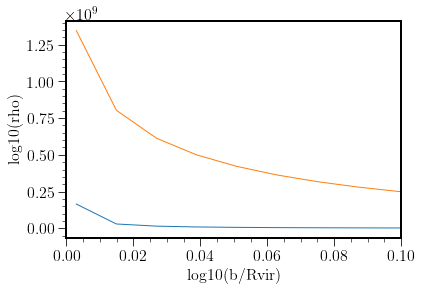

In [192]:
b = np.linspace(1, 400, 100)
mvir = 1e13
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
plt.plot(b/rvir, rho)
plt.plot(b/rvir, rho_column)
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")
plt.xlim((0, 0.1))

Text(0, 0.5, 'log10(rho)')

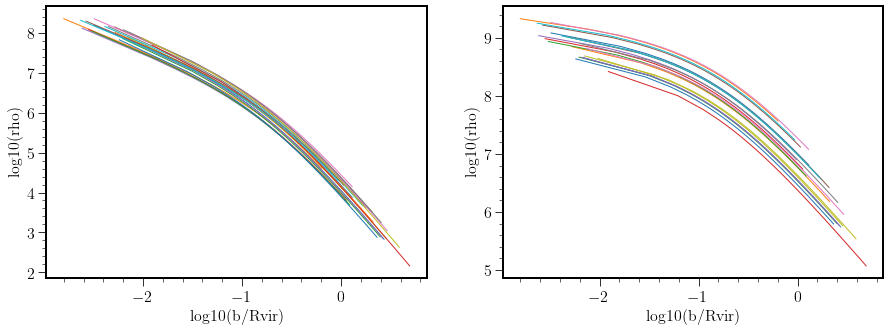

In [193]:
b = np.linspace(1, 400, 100)
rho = gid.nfw_rho(b, 2e6, 30)
rvir = G5_abs["Rvir_sigma2"]
mvir = G5_abs["Mvir_sigma2"]

plt.figure(figsize = (15,5))
plt.subplot(121)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    plt.plot(np.log10(b/r), np.log10(rho))
    #plt.plot(np.log10(b/r), np.log10(rho_column))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

plt.subplot(122)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    #plt.plot(np.log10(b/r), np.log10(rho))
    plt.plot(np.log10(b/r), np.log10(rho_column))
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")

# Combining the plots

2451039.540172016 64.31044864619497
1572590.0608097627 145.4110942753752
2893501.0045016375 26.93384550657308
1859361.2816502939 66.96258419938738
1690064.0235447513 79.4252279418357
3602344.057755505 40.93204187731664
3118414.038078073 73.7624578108404
3197565.975258299 47.02097741386066
3398519.870424323 24.688593082553272
2968205.674676644 50.32317454540034
3140880.1781265303 24.94313077010848
3024895.118742087 35.76243581934028
1894945.2551854965 60.32247666181128
4369352.225942886 13.147172710305126
3075677.71832415 25.602580275560346
2387094.9467194686 84.17183457424436
4066483.7019539736 27.089154312084435
3931957.099539828 32.253144822848924
4406126.591726363 18.906154477417893
2179566.553367164 96.41373613341474
2585908.684990156 27.74789147064919


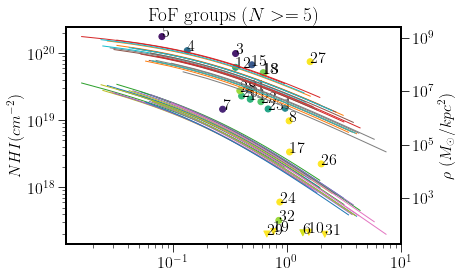

In [194]:
fig, ax1 = plt.subplots()

plt.title("FoF groups ($N >= 5$)")
#plt.errorbar(G5_abs["b_center_kpc_norm"], G5_abs["REW_2796"], yerr = G5_abs["sig_REW_2796"], fmt = 'none')
ax1.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["NHI"], marker = "o", label = "groups N >= 5", \
            c = G5_abs["b_min_kpc"], vmin = 0, vmax = 100)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["NHI_limit"],\
            marker = "v", label = "groups N >= 5", \
             c = G5_noabs["b_min_kpc"], vmin = 0, vmax = 100)
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))

plt.xscale("log")
plt.yscale("log")
plt.ylabel("$NHI (cm^{-2})$")
    
# -----------------------------------------------------------------------

ax2 = ax1.twinx()
b = np.linspace(10, 600, 100)
for i, g in G5_abs.iterrows():
    r = g["Rvir_sigma2"]
    m = g["Mvir_sigma2"]
    z = g["center_z"]
    rho0, rs = gid.get_nfw_param(m, z)
    rho = gid.nfw_rho(b, rho0, rs)
    print(rho0, rs)
    rho_column = []
    for bb in b:
        #print(bb)
        #print(bb, rho0, rs)
        I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
        #print(float(I[0]))
        rho_column.append(float(I[0]))
    #print(rho_column)
    plt.plot(b/r, rho)
    plt.plot(b/r, rho_column)
plt.xlabel("log10(b/Rvir)")
plt.ylabel("log10(rho)")
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\\rho$ $(M_{\odot}/kpc^2)$")
plt.xscale("log")
plt.yscale("log")

## Now with the equation from Bartelmann 1996:

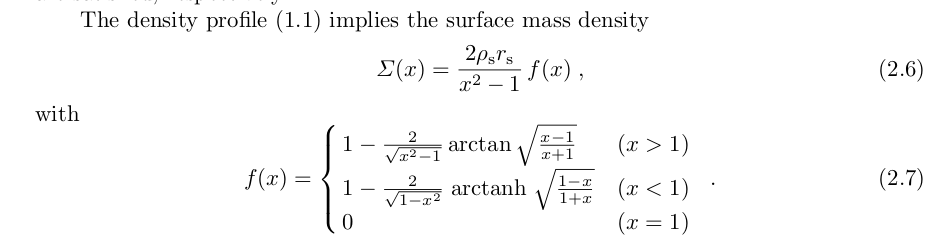

In [195]:
def calc_sigma_DM(r, rhos, rs):
    x = r/rs
    Sigma = 2* rhos*rs*ff(x)/(x**2-1)
    return Sigma

def ff(x):
    if x> 1: return (1-2*np.arctan(((x-1)/(x+1))**0.5)/((x**2-1)**0.5))
    elif x<1: return (1-2*np.arctanh(((1-x)/(x+1))**0.5)/((1-x**2)**0.5))
    elif x == 1: return 0
        

In [225]:
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
rvir

156.28710893311342

In [234]:
print(np.arccos(0/rvir))

1.5707963267948966


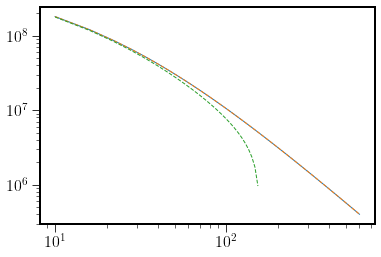

In [235]:
sig_dm = []
rho_column = []
rho_trunc = []
for bb in b:
    sig_dm.append(calc_sigma_DM(bb, rho0, rs))
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
sig_dm = np.array(sig_dm)
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

plt.loglog(b, sig_dm)
plt.loglog(b, rho_column, linestyle = "--")
plt.loglog(b, rho_trunc, linestyle = "--")

#### for a truncated NFW profile:

In [198]:
K= (1.66054e-27*u.kg/(u.cm**2)).to(u.kg/(u.kpc**2))
print(K)
K = K/const.M_sun
K

1.5810675746598502e+16 kg / kpc2


<Quantity 7.95141685e-15 1 / kpc2>

In [199]:
convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value
convert1

2.0883573729600368e-13

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

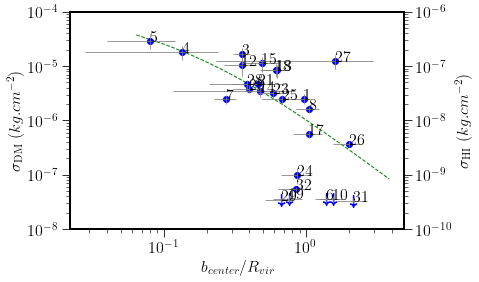

In [200]:

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "--", color = "green", linewidth = 1)
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"], yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")
#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

In [201]:
G5_abs["NHI"], NHI_abs

(0     1.508940e+19
 2     9.870159e+19
 3     1.089312e+20
 4     1.764600e+20
 6     1.459763e+19
 7     9.795088e+18
 11    6.137080e+19
 12    5.022818e+19
 13    2.057496e+19
 14    6.703586e+19
 16    3.363939e+18
 17    5.111697e+19
 19    2.297952e+19
 20    2.832392e+19
 22    1.890464e+19
 23    6.044450e+17
 24    1.473041e+19
 25    2.235366e+18
 26    7.457895e+19
 27    2.758262e+19
 31    3.221807e+17
 Name: NHI, dtype: float64,
 0     2.525297e-08
 2     1.651828e-07
 3     1.823027e-07
 4     2.953159e-07
 6     2.442998e-08
 7     1.639264e-08
 11    1.027076e-07
 12    8.405976e-08
 13    3.443339e-08
 14    1.121884e-07
 16    5.629746e-09
 17    8.554719e-08
 19    3.845755e-08
 20    4.740170e-08
 22    3.163801e-08
 23    1.011574e-09
 24    2.465219e-08
 25    3.741013e-09
 26    1.248122e-07
 27    4.616110e-08
 31    5.391880e-10
 Name: NHI, dtype: float64)

In [202]:
x1 = np.array(G5_abs["b_center_kpc_norm2"])
x2 = np.array(G5_noabs["b_center_kpc_norm2"])
y1 = np.array(np.log(NHI_abs))
y2 = np.array(np.log(NHI_noabs))
sig_x1 = np.array(G5_abs["b_center_kpc_norm2_err"])
sig_x2 = np.array(G5_noabs["b_center_kpc_norm2_err"])
sig_y1 = np.array(NHI_abs_sigma/NHI_abs)
sig_y2 = np.array(NHI_noabs_sigma/NHI_noabs)

In [203]:
G5_noabs["sigma_NHI"]

5     2.975192e+16
9     3.373818e+16
18    3.852419e+16
28    2.162482e+16
30    1.994972e+16
Name: sigma_NHI, dtype: float64

In [204]:
def logL_Hogg_total(param):
    print("param = ", param[0], param[1])
    theta = np.arctan(param[1])
    print("theta = ", theta)
    
    LL1i = []
    LL2i = []
    
    N1 = len(x1)
    LL = 0
    
    for i in range(N1):
        xi = x1[i]
        yi = y1[i]
        sig_xi = sig_x1[i]
        sig_yi = sig_y1[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        LL += -Deltai_2/Sigmai_2/2
        LL1i.append(-Deltai_2/Sigmai_2/2)
        
    N2 = len(x2)
    for i in range(N2):
        xi = x2[i]
        yi = y2[i]
        sig_xi = sig_x2[i]
        sig_yi = sig_y2[i]
        Deltai_2 = (-np.sin(theta)*xi + np.cos(theta)*yi - np.cos(theta)*param[0])**2
        Sigmai_2 = (np.sin(theta))**2*sig_xi**2 + (np.cos(theta))**2*sig_yi**2
        X = -(Deltai_2/Sigmai_2/2)**0.5
        I = 0.5*(1 + math.erf(X))
        LL += np.log(I) 
        LL2i.append(np.log(I))
        
        
    print("LL = ", LL)
    print("LL1 terms: ", LL1i)
    print("LL2 terms: ", LL2i)
    
    X = np.linspace(0.05, 1.5, 50)
    plt.figure()
    plt.scatter(x1,y1)
    plt.scatter(x2,y2)
    plt.plot(X, model(param, X), linewidth = 1.5, c = "green")  
        
    return -LL

In [205]:
NHI_noabs_sigma

5     4.979154e-11
9     5.646278e-11
18    6.447245e-11
28    3.619039e-11
30    3.338700e-11
Name: sigma_NHI, dtype: float64

In [206]:
print(y1)

[-17.49432197 -15.61621314 -15.51759735 -15.03522006 -17.52745476
 -17.92643312 -16.09138006 -16.29173791 -17.18423924 -16.00308649
 -18.9952016  -16.27419764 -17.07371073 -16.86460765 -17.26890665
 -20.71175877 -17.51840025 -19.40390945 -15.89645588 -16.89112835
 -21.34095683]


N =  0
param =  -15.0 -4.0
theta =  -1.3258176636680326
LL =  -88.15388619674437
LL1 terms:  [-4.373173584782186, -2.7315393274802897, -0.0005231011162519754, -0.32955206440432366, -14.600443720369885, -1.2039992408866609, -0.21517607998161173, -2.206928118325803, -0.018447539026780577, -1.1201197622475452, -0.025101073347915143, -1.8505374974163749, -0.7080387895327672, -0.00012750135200096776, -0.013551736654396143, -3.4530090716920556, -0.03564297816286017, -1.9329255380689092, -0.5062017034492607, -0.35208794350598516, -5.78164337242397]
LL2 terms:  [-2.6289556989048584, -1.073403394454814, -15.720656185745149, -25.579971644524953, -1.692129528886755]
param =  -14.999999985098839 -4.0
theta =  -1.3258176636680326
LL =  -88.15388637749616
LL1 terms:  [-4.373173488849153, -2.731539225733925, -0.0005231001646240498, -0.3295520299445949, -14.600444023190525, -1.2039992121747378, -0.21517606022222796, -2.2069280646586926, -0.018447540996828358, -1.120119727672715, -0.025101069898681088,

param =  -13.978282425840463 -6.95566044285664
theta =  -1.428006942110353
LL =  -55.54713123102156
LL1 terms:  [-9.376046201908416, -1.7839126613024596, -0.30171349444205187, -0.7131132057383616, -9.47281292340304, -2.894627839729156, -0.12354158050505133, -2.4230150521396263, -0.0009087461873314171, -0.916259810221185, -0.9533565810438787, -1.952343141508738, -0.11493164832995122, -0.016986031092310765, -0.36945778170413074, -0.12970756605589356, -0.3970042088878034, -3.5813975899313935, -0.4696355534524392, -0.062849803881409, -0.47673099413311953]
LL2 terms:  [-2.16051722071535, -2.4095961624165643, -3.7736968643098043, -6.685155426249117, -3.9878131417329814]
param =  -13.978282440741625 -6.955660427955479
theta =  -1.4280069418085952
LL =  -55.547131260779196
LL1 terms:  [-9.376046241727256, -1.7839127073359822, -0.3017134828153745, -0.7131131679992146, -9.47281283006912, -2.8946278507771592, -0.12354158771732994, -2.423015074615454, -0.0009087463237884127, -0.9162598237163909, -

param =  -13.738511095702915 -7.435981742129076
theta =  -1.437117114647031
LL =  -55.289427766709686
LL1 terms:  [-9.498613456679378, -1.3814591965586611, -0.4446694979555288, -1.319162823265895, -9.705350381622194, -2.9547796503158428, -0.0714243373847329, -2.274428685728522, -0.0006405908280839329, -0.8067649269426974, -1.0385195139909893, -1.822843850655231, -0.13452861650586084, -0.013311616383427982, -0.3604294669973211, -0.06522493567814673, -0.40084213063384955, -3.689840773792278, -0.45946538577421653, -0.085384906016817, -0.32723411667807256]
LL2 terms:  [-2.492373374838318, -2.6380879357508364, -3.2649431587241082, -5.844211736917024, -4.194892700091651]
param =  -13.738511080801754 -7.435981742129076
theta =  -1.437117114647031
LL =  -55.28942776678696
LL1 terms:  [-9.498613373583545, -1.3814591420422675, -0.44466951480678835, -1.3191628793168089, -9.705350545811907, -2.9547796256875545, -0.07142432976413514, -2.2744286538514435, -0.0006405906291653349, -0.8067649097075709,

param =  -15.510037560542381 -4.871757805606392
theta =  -1.3683436997076546
LL =  -31.51122969396533
LL1 terms:  [-1.0520878476297493, -0.39336621592822046, -0.05837552362416222, -0.1122435059995803, -0.07231233218108887, -0.8603268655683692, -0.18667870556695867, -0.7117963537428672, -0.03310424221400231, -0.4813788178908645, -0.2956201664541444, -0.6750530895688797, -0.021696571549687845, -0.08421985628020692, -0.17093914930063286, -0.11547451913906231, -0.21080150931257283, -2.094934732147078, -0.5774340327490612, -0.03615871508652224, -0.3351099444995775]
LL2 terms:  [-1.0957934230007322, -1.6037335269386526, -6.248255834620426, -10.788028000319919, -3.196306212652313]
param =  -15.510037575443542 -4.871757790705231
theta =  -1.3683436991051985
LL =  -31.511229752490262
LL1 terms:  [-1.0520878485015044, -0.3933662206449107, -0.058375525996110386, -0.11224350956569706, -0.07231232991394305, -0.8603268663077498, -0.18667870877035614, -0.7117963576544368, -0.03310424311209901, -0.481

param =  -13.443874508729726 -7.4758663216191925
theta =  -1.4378219085524981
LL =  -27.1929859475622
LL1 terms:  [-1.30149377626063, -0.033098101956647565, -0.14842854755578955, -0.1456664501898929, -0.6230572370910381, -1.0254966132549252, -1.905144207072964e-07, -0.41046565643928107, -0.0015426344763271186, -0.14209209685563987, -0.4195881742215346, -0.3660301753217426, -0.055465697832070095, -8.06319574644485e-05, -0.04099330079319404, -0.05881443933976822, -0.09957219348337018, -2.7240744348120813, -0.42019543713786595, -0.04326023678989193, -0.20914864027365604]
LL2 terms:  [-2.212879665732002, -2.4451956635393524, -3.699221093146428, -6.544097119697589, -4.023027738889597]
param =  -13.438527637984853 -7.487588531231255
theta =  -1.4380276472152693
LL =  -27.192892315957213
LL1 terms:  [-1.3057983664213788, -0.032927627592709514, -0.14939897304671296, -0.146950638822183, -0.6242943504198444, -1.028463142528157, -7.634351186313283e-07, -0.4110780856185148, -0.0015352521283434047,

param =  -15.0 -3.999999985098839
theta =  -1.3258176627914935
LL =  -51.34905335242077
LL1 terms:  [-0.2664322315422364, -0.09498086108581566, -3.8238311443968145e-05, -0.012031004588734745, -0.3106351377098499, -0.20016674942763796, -0.015057846938216506, -0.20901498252272285, -0.007260121423559854, -0.1270444189625259, -0.005613499430641925, -0.19688983916487754, -0.03287963879250262, -3.170942580224733e-05, -0.0012087299584168034, -0.6361526697612786, -0.005791575738247868, -0.9736574419637339, -0.45619720245683204, -0.017716987560908934, -1.0851357762380693]
LL2 terms:  [-2.6289557542010806, -1.0734034150686618, -15.720656365558337, -25.579971644524953, -1.6921295100636815]
param =  -15.510368237580604 -4.871564261583084
theta =  -1.3683358743978353
LL =  -31.409534534023322
LL1 terms:  [-1.0354065777892205, -0.38692433246900293, -0.05751215646113044, -0.11045056750449803, -0.07103097674719781, -0.848836690273173, -0.18379531813801447, -0.7011135111130807, -0.03283548786175538, -0

param =  -13.442229442094865 -7.4815698256953524
theta =  -1.4379220909211274
LL =  -27.115799041471515
LL1 terms:  [-1.2853187670722055, -0.0326067102150696, -0.14651104465105438, -0.1436091159948999, -0.6127545823782964, -1.0168525946774, -8.859166222357459e-08, -0.4057251710540193, -0.0015145067729256596, -0.14053190218165004, -0.41717303053835547, -0.36197584893068263, -0.05450816171663451, -8.474471904493099e-05, -0.04067519804249032, -0.05770234068878831, -0.09889614456106882, -2.716306273190547, -0.4200127667377227, -0.04251334191020825, -0.20613570755986346]
LL2 terms:  [-2.2179288866466513, -2.4487146946626783, -3.690940114388754, -6.530574427447153, -4.026232876141692]
param =  -13.442229427193704 -7.4815698256953524
theta =  -1.4379220909211274
LL =  -27.115799041792485
LL1 terms:  [-1.2853187549283418, -0.0326067081695195, -0.14651104870669351, -0.14360912030048054, -0.6127545913060102, -1.0168525855683084, -8.85948781842308e-08, -0.4057251645489977, -0.0015145070256543274,

param =  -14.999999985098839 -4.0
theta =  -1.3258176636680326
LL =  -51.34245678477397
LL1 terms:  [-0.26593341828705075, -0.09479809350358796, -3.8167588148124606e-05, -0.012007894517096596, -0.31002906658092877, -0.19983396075944893, -0.015029926152437837, -0.20863771649211513, -0.007251338184401862, -0.12681983791103943, -0.005604808049629854, -0.1965390383774956, -0.032817135142281136, -3.166194304443507e-05, -0.0012065348216263698, -0.6351178010106623, -0.005781903262963759, -0.972693251254096, -0.4561072062481965, -0.017683444982606485, -1.083377982719845]
LL2 terms:  [-2.6289557317538685, -1.0734034066875815, -15.720656296169842, -25.579971644524953, -1.692129517849028]
param =  -15.0 -3.999999985098839
theta =  -1.3258176627914935
LL =  -51.34245687773493
LL1 terms:  [-0.2659334185945792, -0.09479809579201832, -3.816764832816845e-05, -0.012007895672865965, -0.31002906192904395, -0.1998339607845813, -0.015029927047984884, -0.20863771848772994, -0.007251337799656836, -0.12681983

param =  -13.501272902530802 -7.3817666826336
theta =  -1.43614709531138
LL =  -27.11322873414789
LL1 terms:  [-1.2580655042205258, -0.03590962164761262, -0.1346745247051603, -0.1290822037043398, -0.5932865557074672, -0.998738687759236, -6.898041933692036e-05, -0.40581620131541624, -0.0013493521740229786, -0.1437810204674728, -0.4057282428229248, -0.3627823653241287, -0.051372649208205064, -0.000163115553869261, -0.04088365249318993, -0.0622807706863456, -0.09805106694003445, -2.686343239200064, -0.4219948752398176, -0.039520118992623816, -0.21527170818944993]
LL2 terms:  [-2.1616914229962148, -2.4094866709787874, -3.7835387289800244, -6.683122698410292, -3.990224756011321]
param =  -13.501272917431963 -7.381766667732439
theta =  -1.4361470950428445
LL =  -27.113228735199876
LL1 terms:  [-1.2580655053922232, -0.03590962303874248, -0.13467452141544722, -0.12908219996463471, -0.5932865494073548, -0.998738688930771, -6.89804773769077e-05, -0.4058162040824385, -0.0013493520516872752, -0.14

[-13.4368231   -7.49465609]
yi =  [-17.49432197 -15.61621314 -15.51759735 -15.03522006 -17.52745476
 -17.92643312 -16.09138006 -16.29173791 -17.18423924 -16.00308649
 -18.9952016  -16.27419764 -17.07371073 -16.86460765 -17.26890665
 -20.71175877 -17.51840025 -19.40390945 -15.89645588 -16.89112835
 -21.34095683]
modeled_yi =  [-20.65582838 -16.09049869 -14.4373211  -14.0368293  -15.48013065
 -21.26153803 -16.08978501 -18.15336984 -17.00647179 -17.12530206
 -21.32884905 -18.06743314 -16.43486678 -16.89942476 -17.86208393
 -19.91862321 -18.55286129 -28.38199614 -25.38625354 -16.32743231
 -19.79423344]
sigma_mi =  [0.21953835 0.28431825 0.27894016 0.31225307 0.18546729 0.17832583
 0.349293   0.27221231 0.20701826 0.30730772 0.14157798 0.26760602
 0.16150188 0.22594522 0.17390144 0.34070199 0.18653151 0.11545588
 0.28833671 0.22212667 0.12031576]
mean_residual =  1.2554387878856077
sigma_intrisic =  1.8055224285554794
1.8055224285554794
N =  4
param =  -15.0 -4.0
theta =  -1.325817663668032

param =  -13.442033890334182 -7.4822811011011225
theta =  -1.4379345739903784
LL =  -27.106057169723883
LL1 terms:  [-1.2832838425151125, -0.032546190436240456, -0.1462665941884168, -0.14334708715461542, -0.6114558885498027, -1.0157605261853668, -7.67251379060109e-08, -0.40513021427806045, -0.0015108435247606464, -0.1403369757239876, -0.41686714329899294, -0.361466998711589, -0.05438656660088953, -8.530791051822957e-05, -0.04063580138217879, -0.0575622228380534, -0.09881149370141101, -2.7153160848054956, -0.4199901864465686, -0.04241832273762126, -0.20575559286599707]
LL2 terms:  [-2.2185688208348866, -2.4491605826770515, -3.6898919208446683, -6.528863053253703, -4.026638831532757]
param =  -13.44203387543302 -7.4822811011011225
theta =  -1.4379345739903784
LL =  -27.106057170048242
LL1 terms:  [-1.2832838303923573, -0.032546188394729086, -0.1462665982369106, -0.1433470914517406, -0.6114558974585872, -1.0157605170875548, -7.672812787221352e-08, -0.4051302077834591, -0.00151084377708034

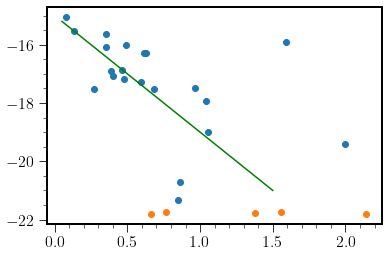

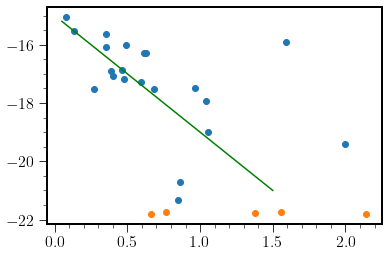

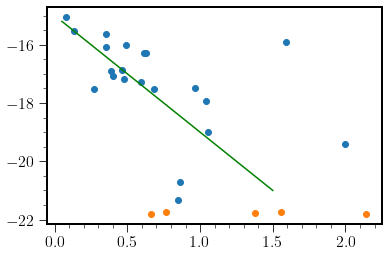

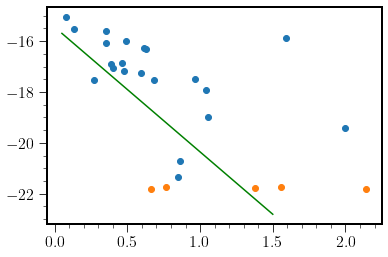

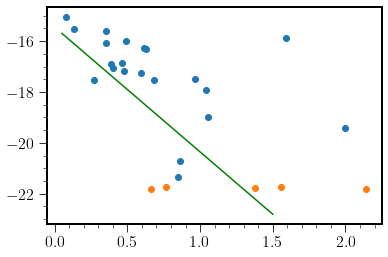

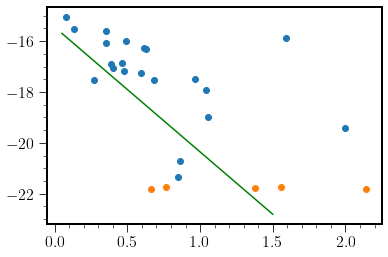

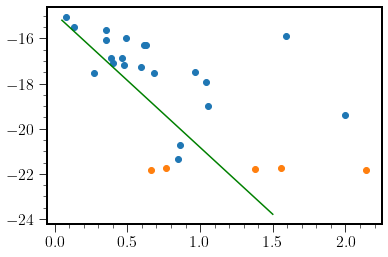

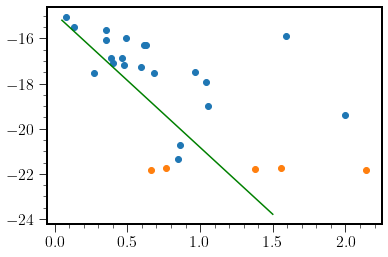

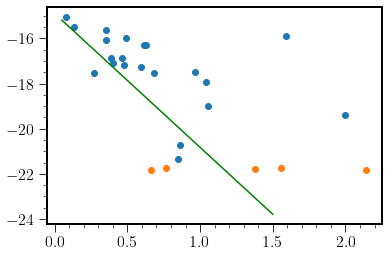

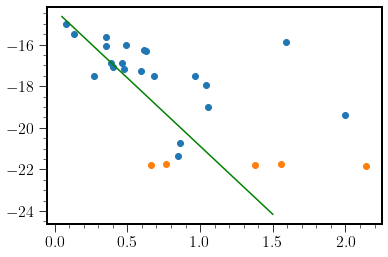

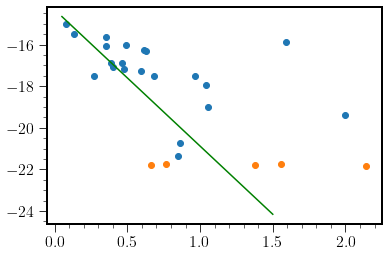

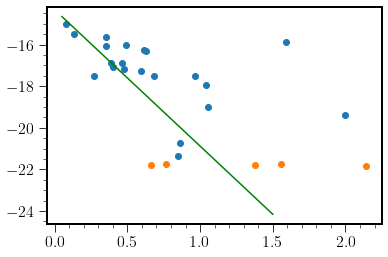

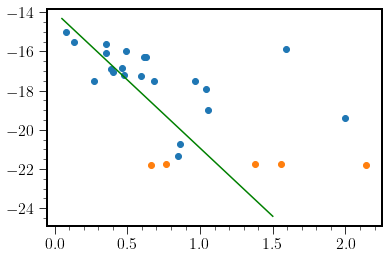

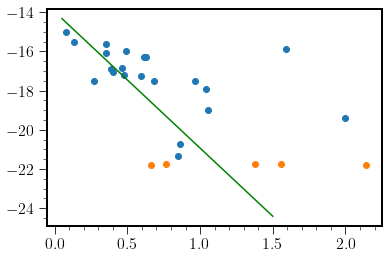

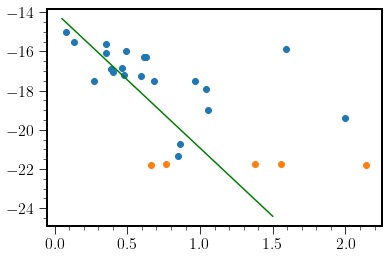

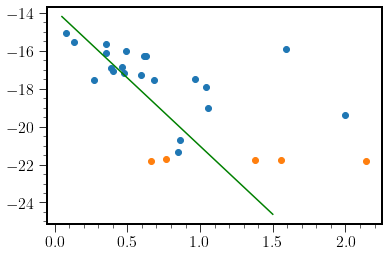

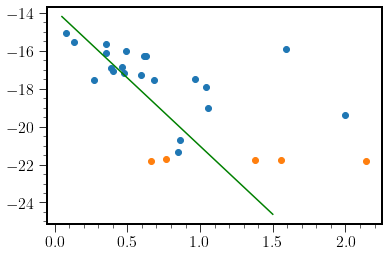

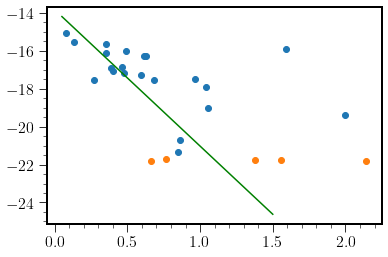

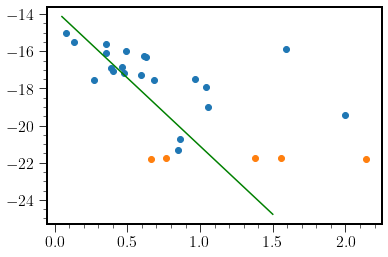

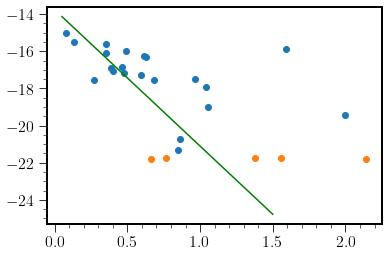

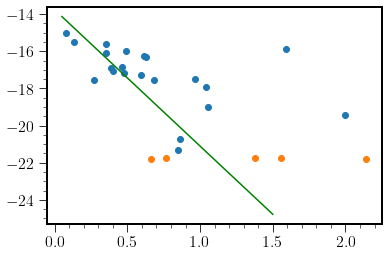

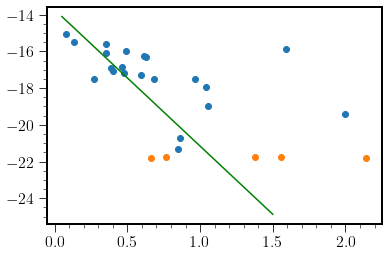

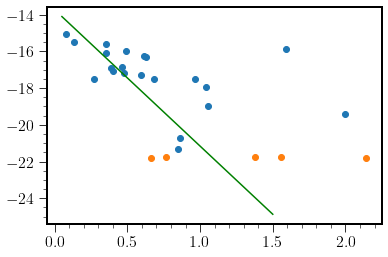

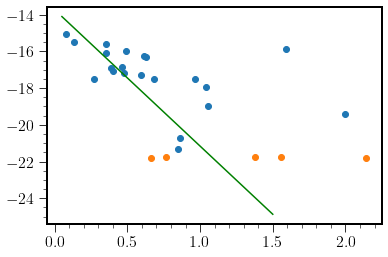

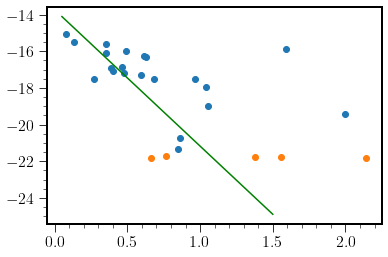

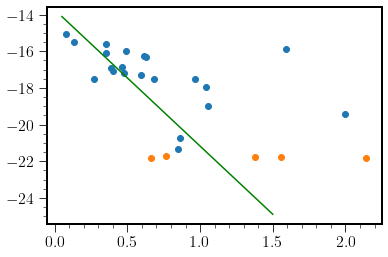

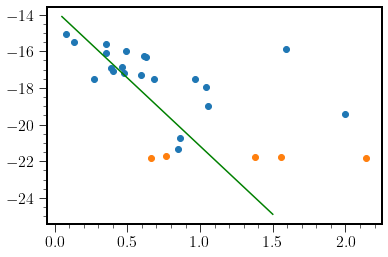

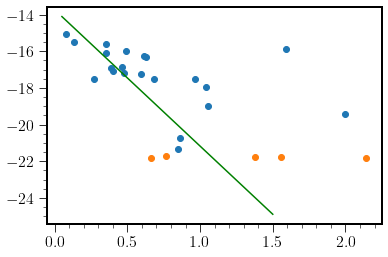

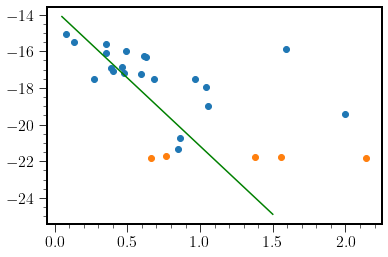

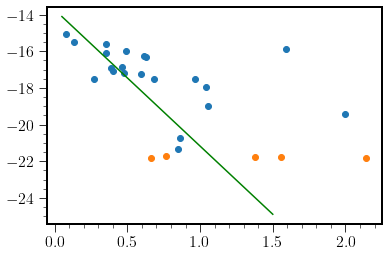

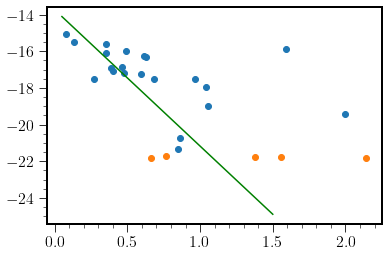

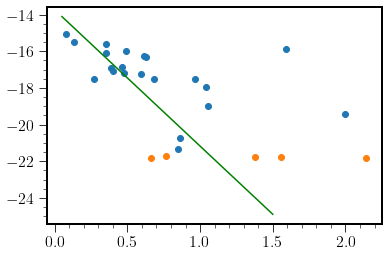

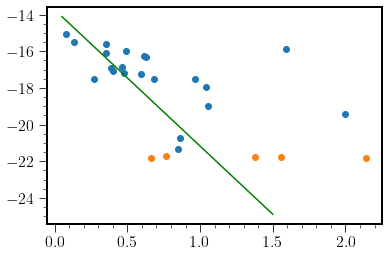

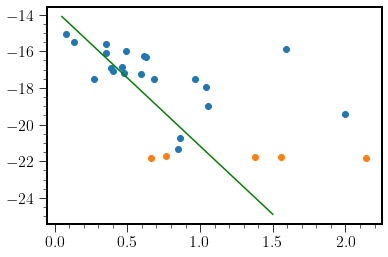

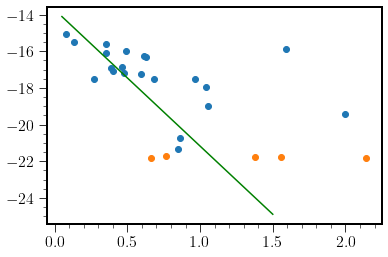

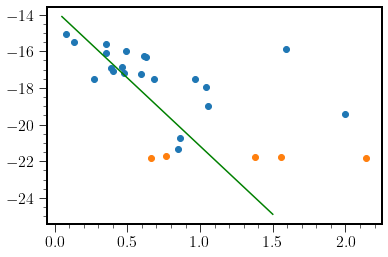

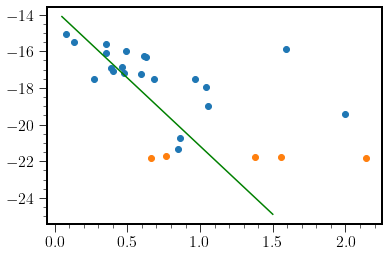

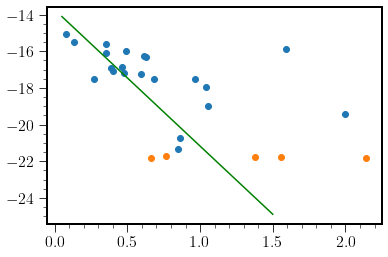

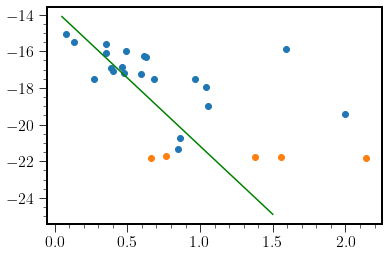

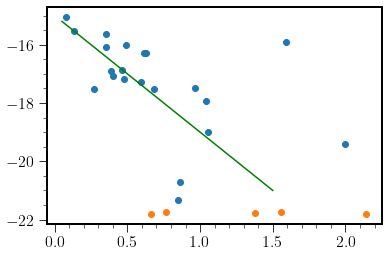

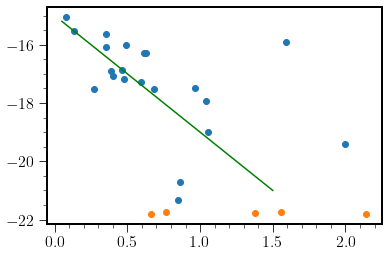

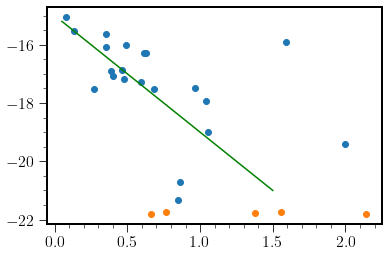

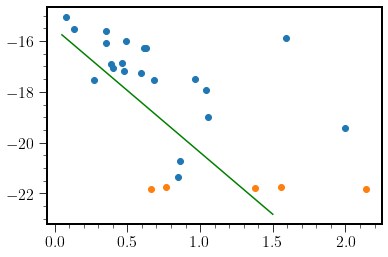

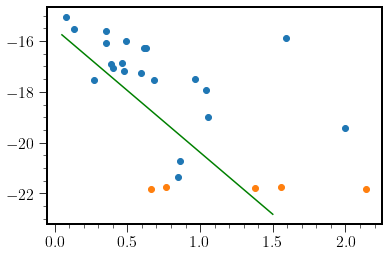

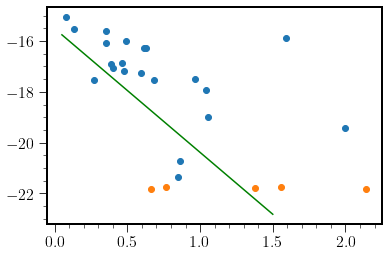

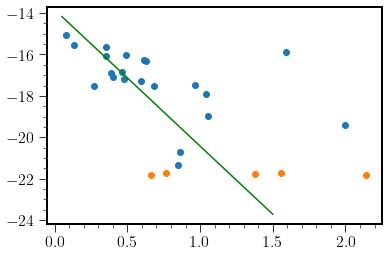

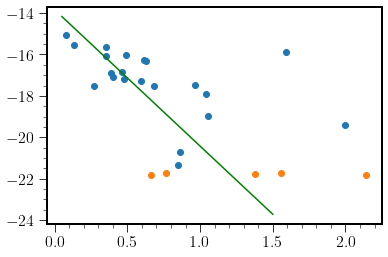

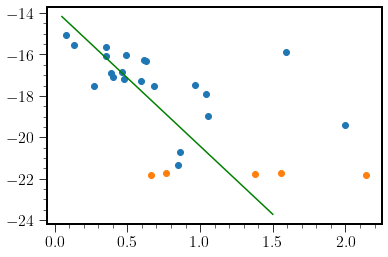

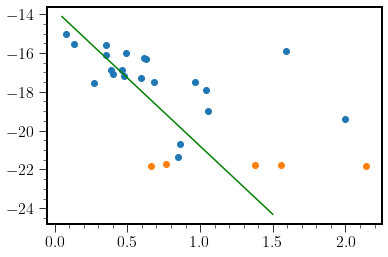

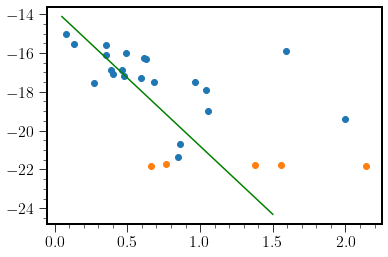

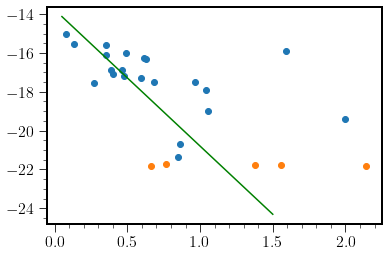

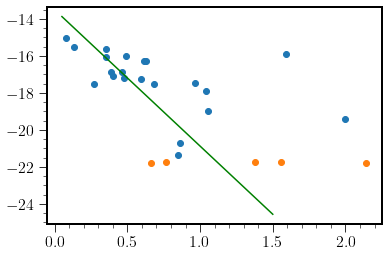

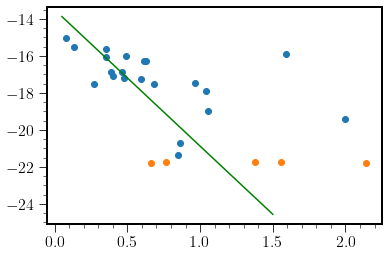

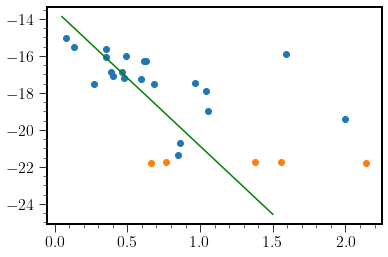

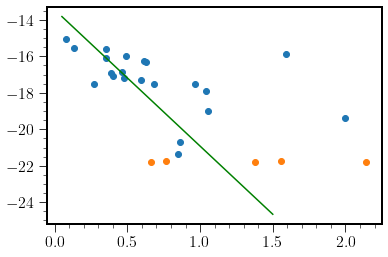

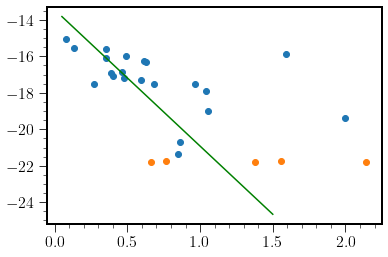

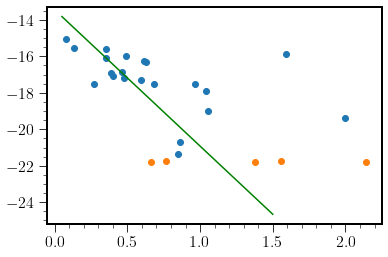

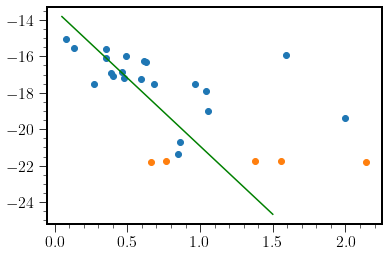

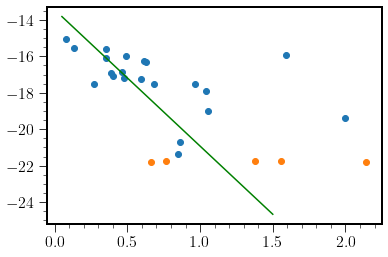

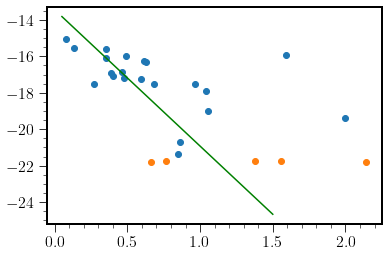

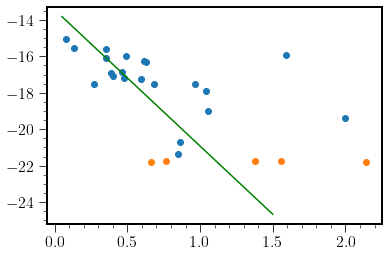

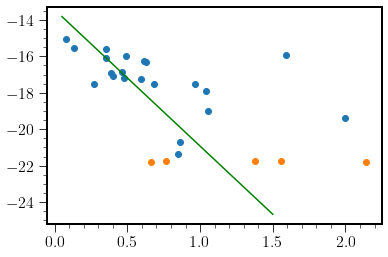

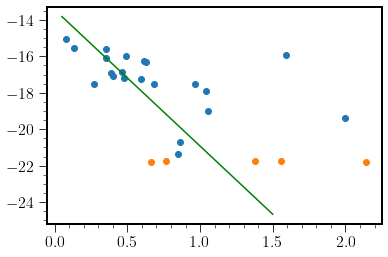

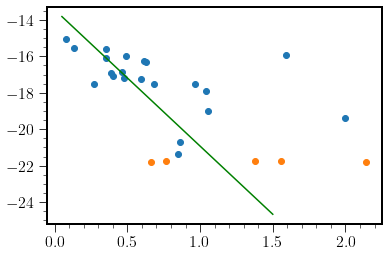

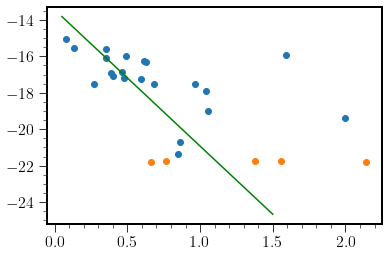

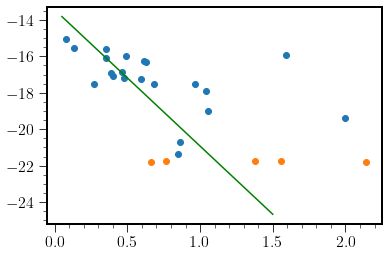

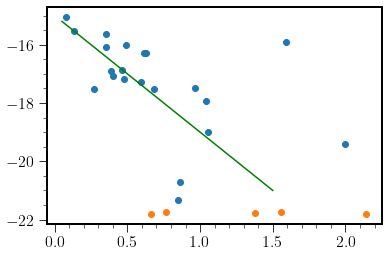

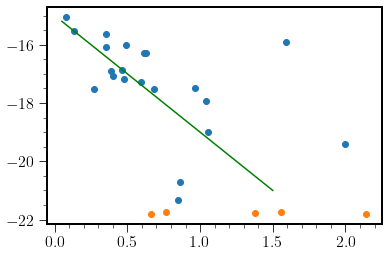

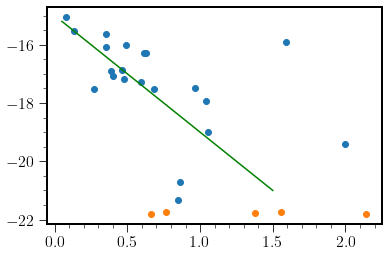

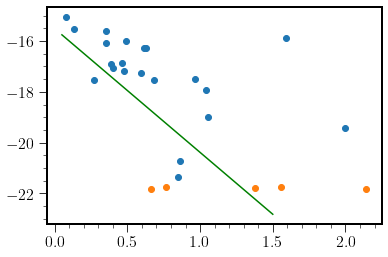

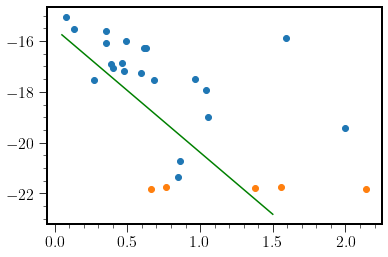

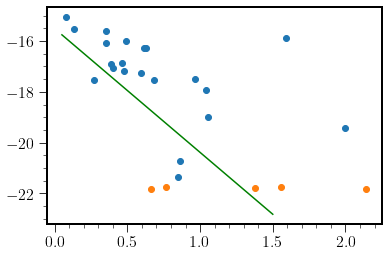

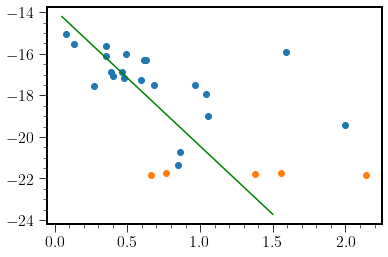

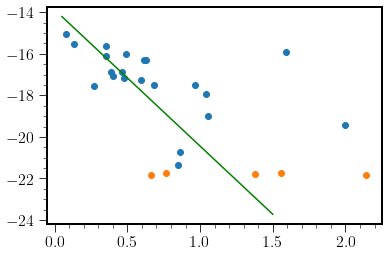

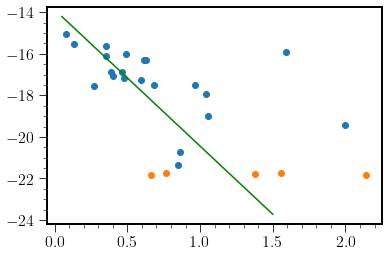

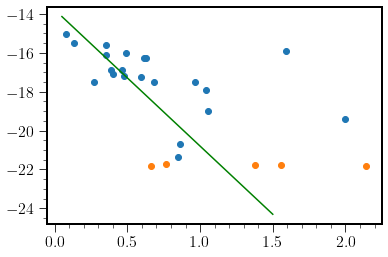

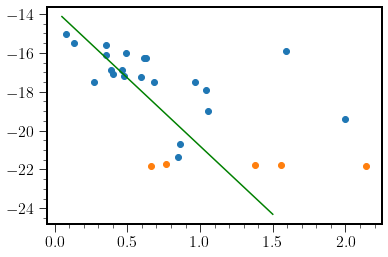

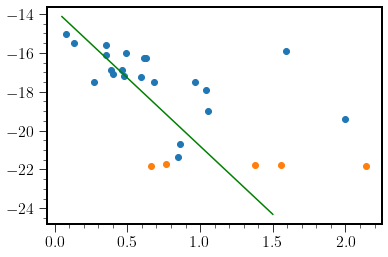

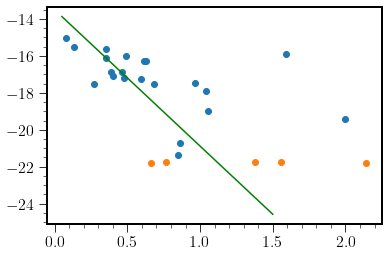

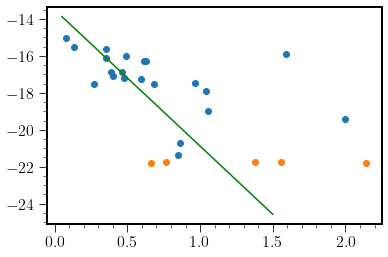

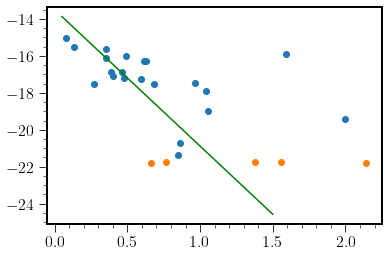

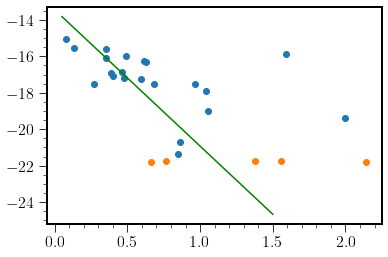

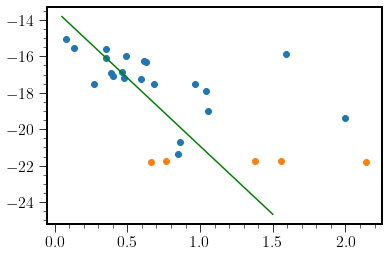

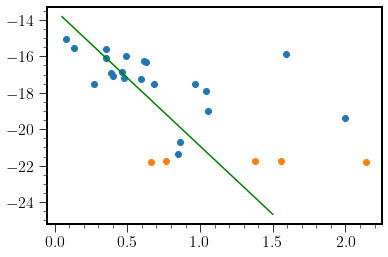

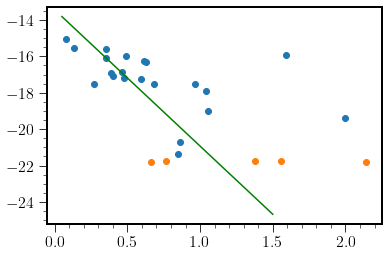

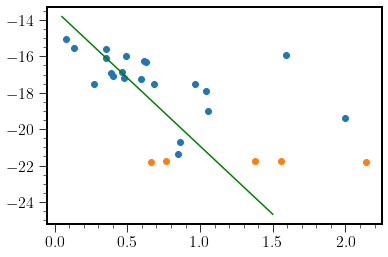

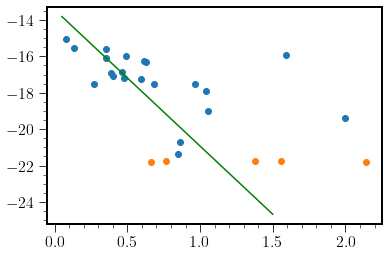

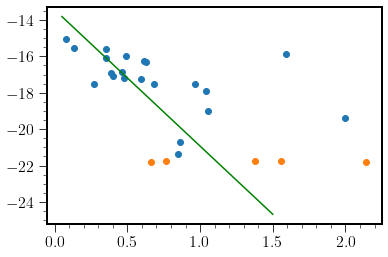

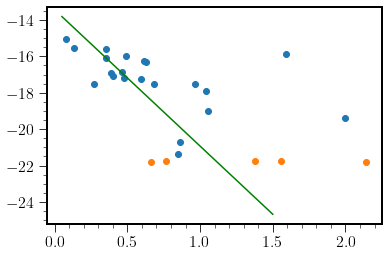

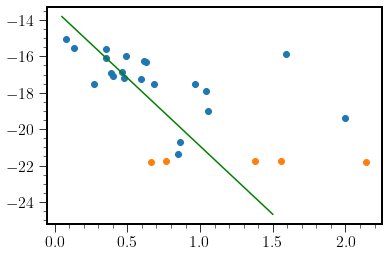

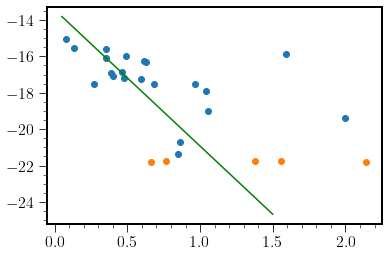

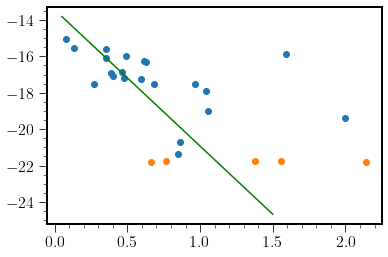

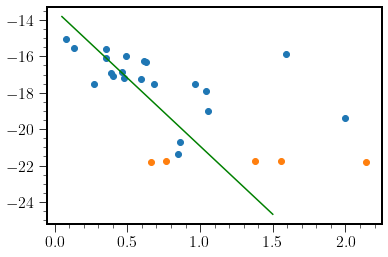

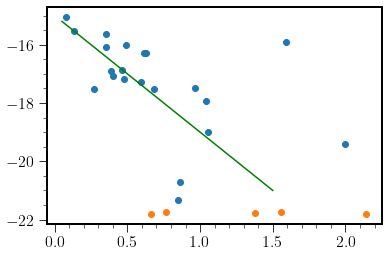

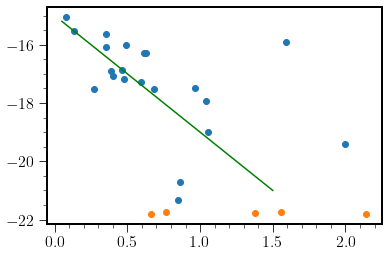

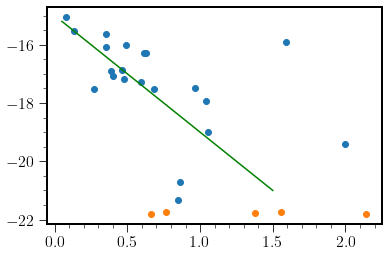

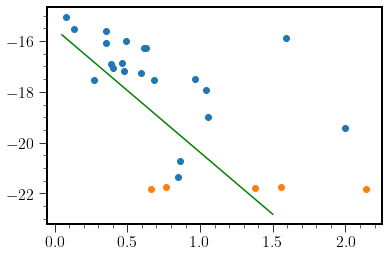

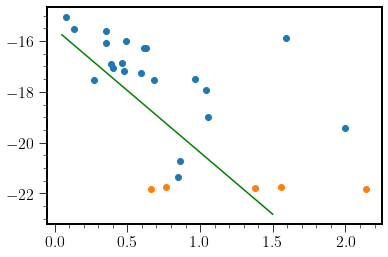

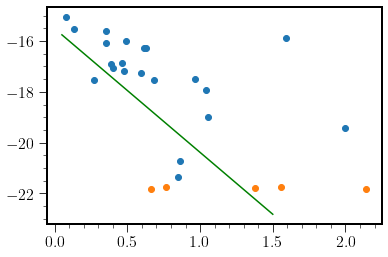

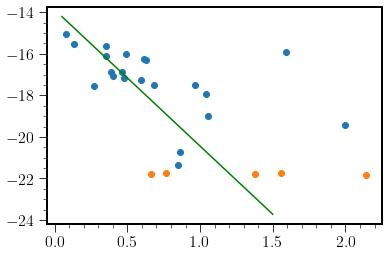

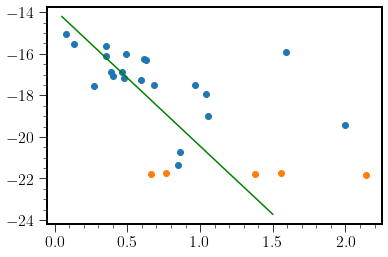

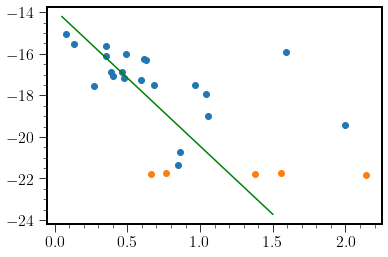

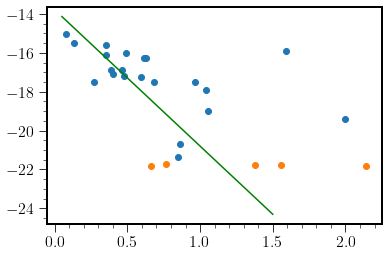

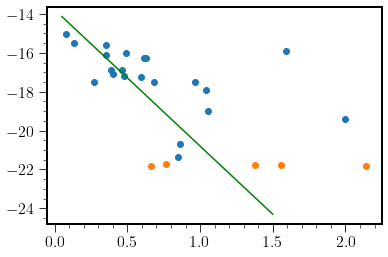

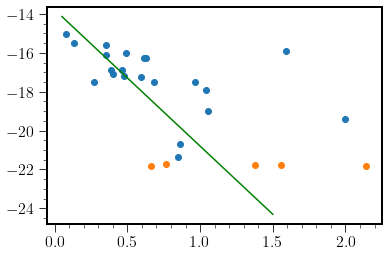

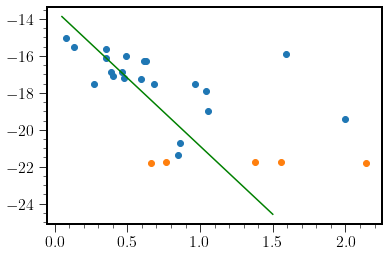

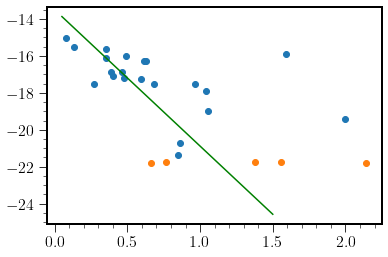

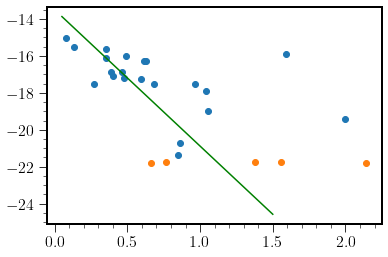

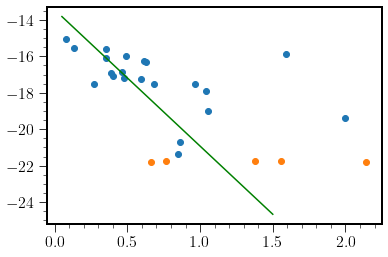

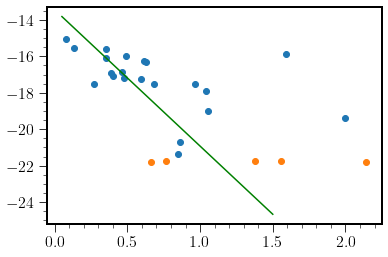

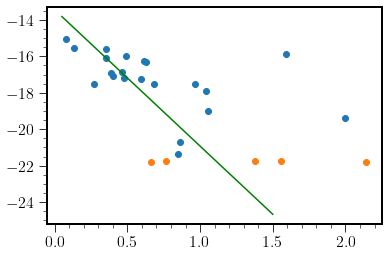

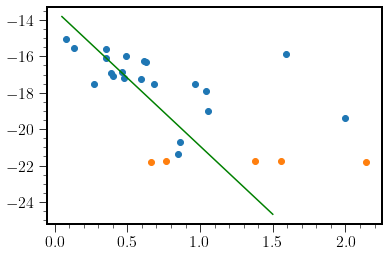

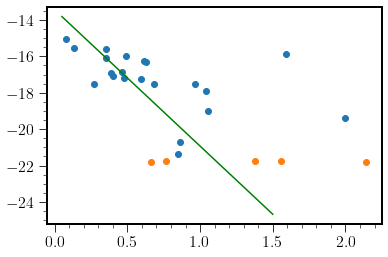

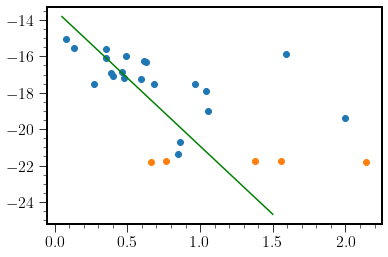

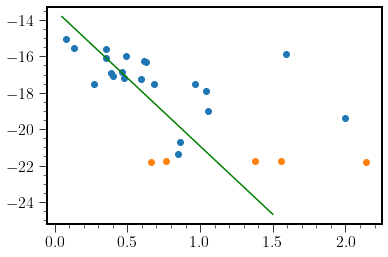

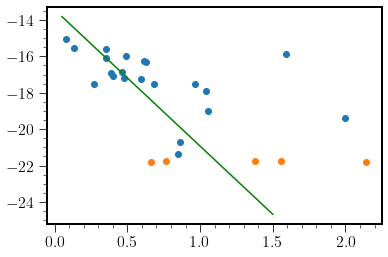

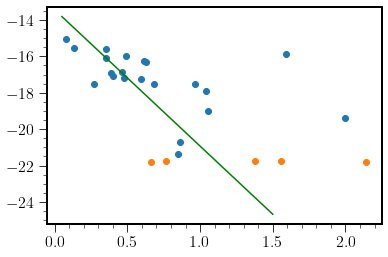

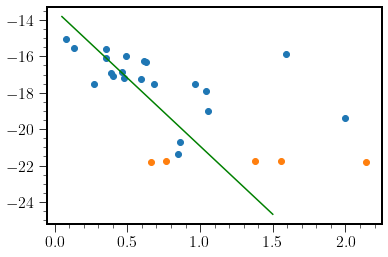

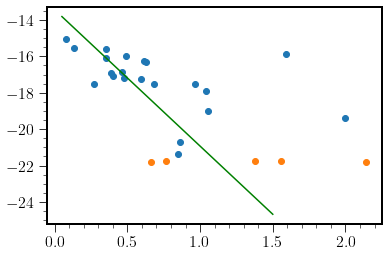

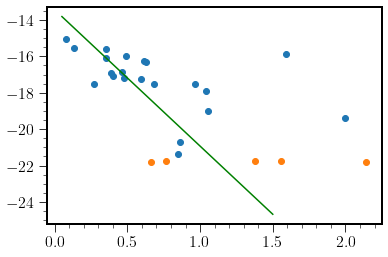

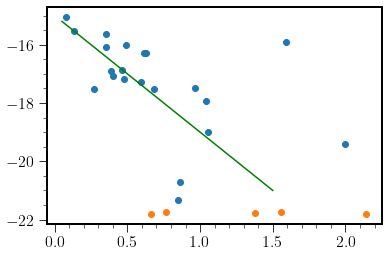

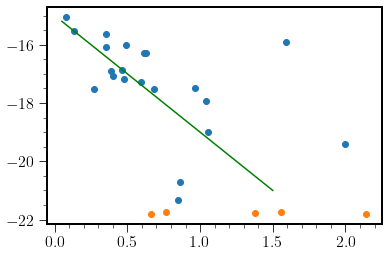

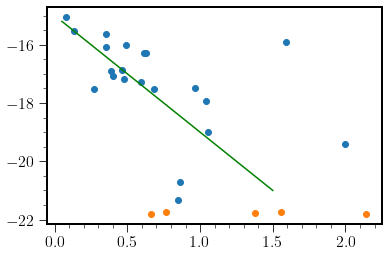

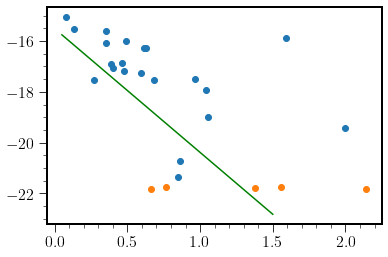

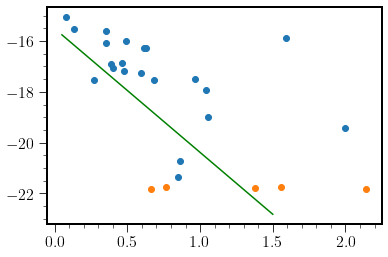

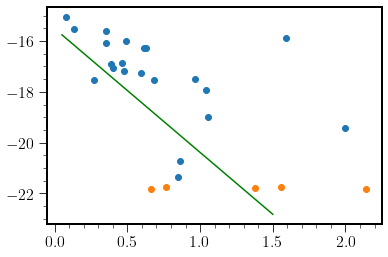

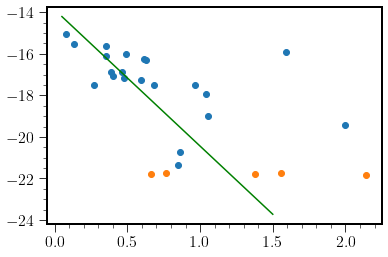

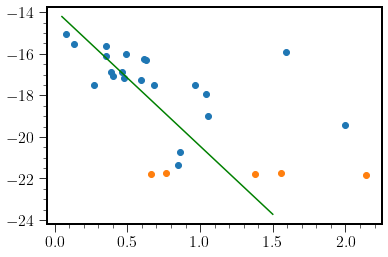

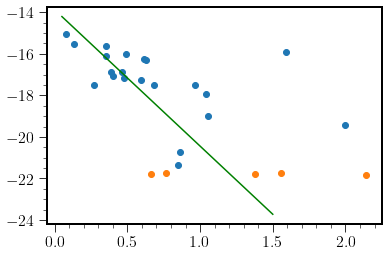

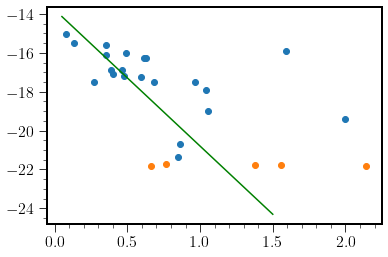

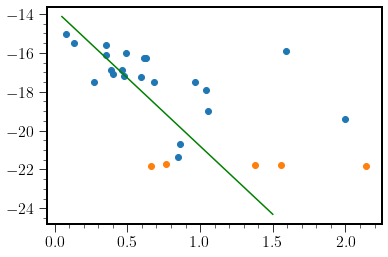

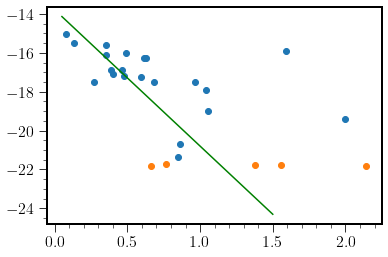

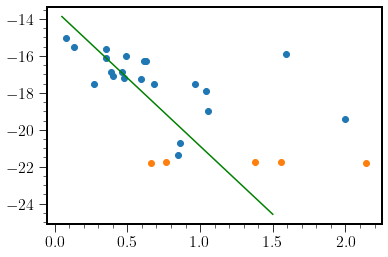

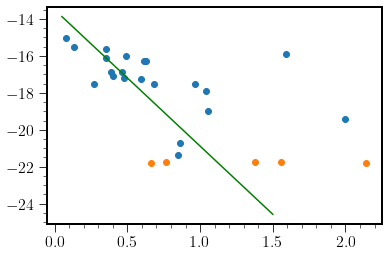

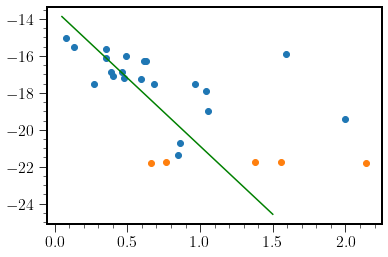

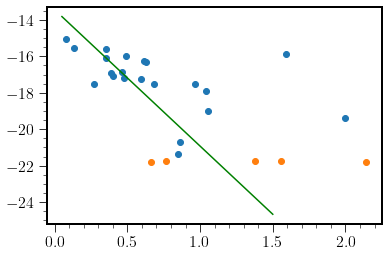

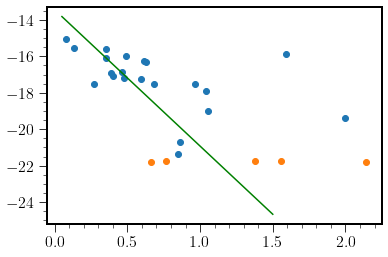

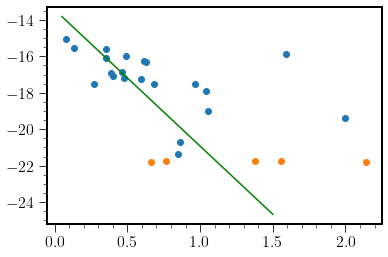

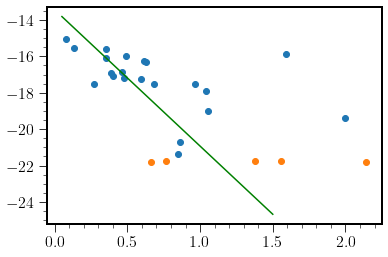

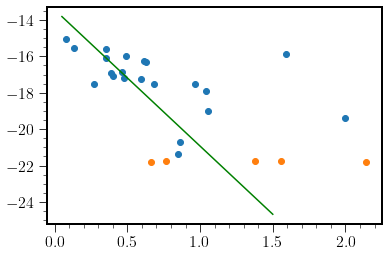

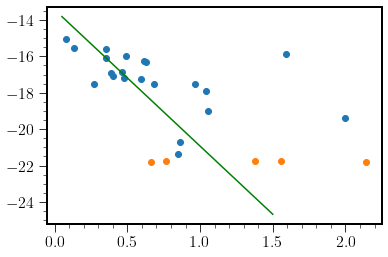

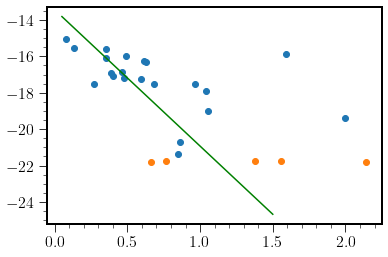

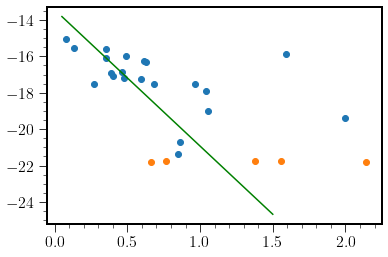

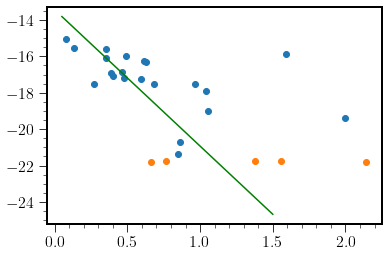

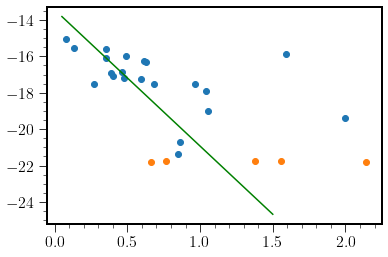

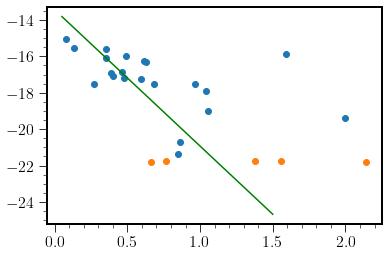

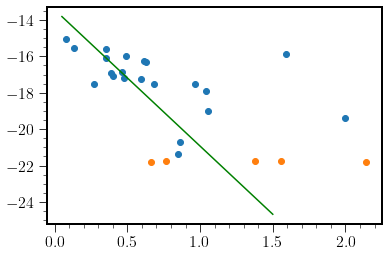

In [207]:
N = 5
sigma_intrinsic_start = 0
sigma_intrinsic = sigma_intrinsic_start
sigma_intrisic_list = [sigma_intrinsic]

for i in range(N):
    print("N = ", i)
    sig_y1_mi = np.array(NHI_abs_sigma/NHI_abs)
    sig_y1 = (sig_y1_mi**2 + sigma_intrinsic**2)**0.5
    LL_model_Hogg_total = minimize(logL_Hogg_total, np.array([-15,-4]), method='BFGS')
    print(LL_model_Hogg_total['x'])
    sigma_intrinsic = calc_sigma_intrisic(y1, model(LL_model_Hogg_total['x'], x1), sig_y1_mi)
    print(sigma_intrinsic)
    sigma_intrisic_list.append(sigma_intrinsic)

In [208]:
LL_model_Hogg_total

      fun: 27.105951903887632
 hess_inv: array([[ 0.71423973, -0.78959104],
       [-0.78959104,  1.13041194]])
      jac: array([1.90734863e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([-13.43680335,  -7.4947338 ])

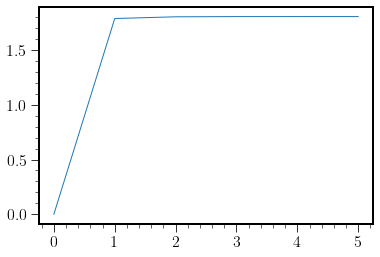

In [209]:
plt.plot(sigma_intrisic_list)

156.28710893311342 3346226.7715142868 28.545636311349668


(1e-10, 1e-06)

<Figure size 504x288 with 0 Axes>

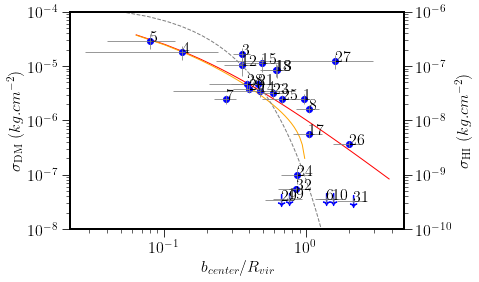

In [241]:
plt.figure(figsize = (7,4))

fig, ax1 = plt.subplots()
#plt.title("FoF groups ($N >= 5$)")
b = np.linspace(10, 600, 100)
mvir = 1e12
z = 1
rvir = gid.get_Rvir(mvir, z)
rho0, rs = gid.get_nfw_param(mvir, z)
print(rvir, rho0, rs)
rho = gid.nfw_rho(b, rho0, rs)
rho_column = []
rho_trunc = []
for bb in b:
    I = integrate.quad(nfw_rho_2, -np.pi/2, np.pi/2, args = (bb, rho0, rs))
    rho_column.append(float(I[0]))
    theta_lim = np.arccos(bb/rvir)
    I2 = integrate.quad(nfw_rho_2, -theta_lim, theta_lim, args = (bb, rho0, rs))
    rho_trunc.append(float(I2[0]))
#plt.plot(np.log10(b/r), np.log10(rho))
#plt.plot(np.log10(b/r), np.log10(rho_column))
#plt.plot(b/rvir, rho, linestyle = "--", color = "gray", linewidth = 1, label = "rho column")
rho_column = np.array(rho_column)
rho_trunc = np.array(rho_trunc)

convert1 = ((const.M_sun/((1*u.kpc)**2)).to(u.kg/((u.cm)**2))).value

plt.plot(b/rvir, rho_column*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.plot(b/rvir, rho_trunc*convert1, linestyle = "-", color = "orange", linewidth = 1)
#plt.plot(b/rvir, sig_dm*convert1, linestyle = "-", color = "red", linewidth = 1)
plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$\sigma_{\mathrm{DM}}$ $(kg.cm^{-2})$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-8, 1e-4))

    
# -----------------------------------------------------------------------

u_to_kg = 1.67355755e-27

ax2 = ax1.twinx()
NHI_abs = G5_abs["NHI"]*u_to_kg
NHI_abs_sigma = G5_abs["sigma_NHI"]*u_to_kg
NHI_noabs = G5_noabs["NHI_limit"]*u_to_kg
NHI_noabs_sigma = G5_noabs["sigma_NHI"]*u_to_kg

ax2.errorbar(G5_abs["b_center_kpc_norm2"], NHI_abs, xerr = G5_abs["b_center_kpc_norm2_err"], yerr =NHI_abs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_abs["b_center_kpc_norm2"], NHI_abs, marker = "o", label = "groups N >= 5", \
            c = "blue")
#plt.colorbar(label = "log($M/M_{\odot}$)")

ax2.errorbar(G5_noabs["b_center_kpc_norm2"], NHI_noabs, xerr = G5_noabs["b_center_kpc_norm2_err"],\
             yerr = NHI_noabs_sigma,\
            fmt = " ", color = "gray", linewidth = 0.8)
ax2.scatter(G5_noabs["b_center_kpc_norm2"], NHI_noabs,\
            marker = "$\downarrow$", s = 150, label = "groups N >= 5", \
             c = "blue")


X = np.linspace(0.05, 1.4, 50)
ax2.plot(X, np.exp(model(LL_model_Hogg_total['x'], X)), linewidth = 1.0, c = "gray", label = "best fit", \
         linestyle = "--")

#plt.colorbar(label = "bmin kpc")

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["NHI"]*u_to_kg)
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["NHI_limit"])*u_to_kg
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.ylabel("$\sigma_{\mathrm{HI}}$ $(kg.cm^{-2})$")

plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-10, 1e-6))

# Group metallicity

We can use Zn/Fe in the UVES spectra to investigate groups metallicity.

In [211]:
exp = G5[["group_id", "field_id", "N_gal", "center_z", "b_min_kpc", "b_center_kpc", "M_vel_disp"]]
exp

KeyError: "['M_vel_disp'] not in index"

In [ ]:
exp.to_csv("G5.csv", index = False)

We can look in Martin 2021 if some groups correspond to his sample: 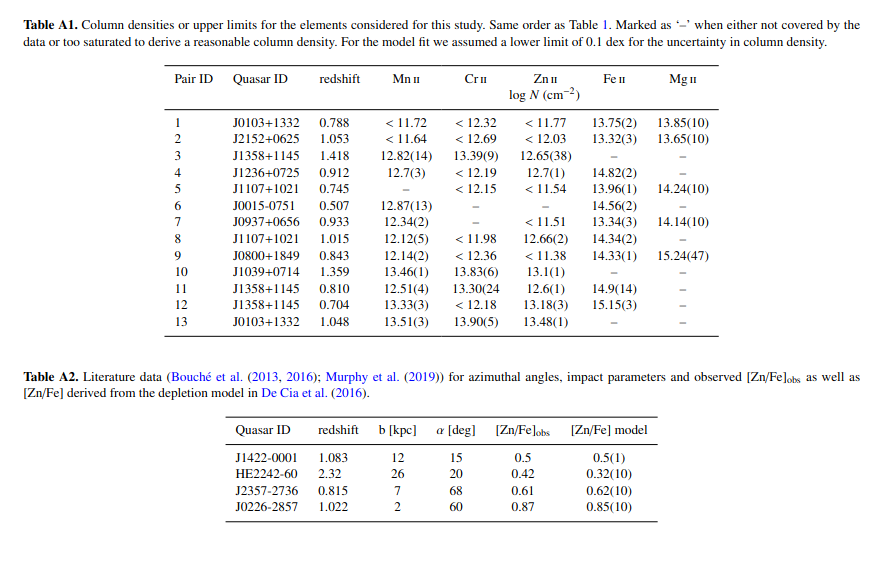

# Absorber kinematics

In [ ]:
fff = "J1039p0714"
"j"+fff[1:]

In [ ]:
grplist = G5["group_id"]
Abs = pd.read_csv("MgII_all_absorption")

In [ ]:
for i in range(len(G5)):
    gid.plot_group_absorption2(i, R, G5, Abs)

In [ ]:
KK = G5.head(1)
KK = KK.squeeze()
RR = R[R["group_id"] == KK["group_id"]]
plt.scatter(RR["RA"]*u.degree, RR["DEC"]*u.degree)


In [ ]:
#gid.plot_groups_2(R, G5_raw, Nmin = 5, save = True, filename="catalog_article")

# Covering fraction

In [131]:
folder = "run_17"

In [132]:
G5_bmin_lin = G5[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_lin = G5[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_norm_lin = G5[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bcenter_norm_lin = G5[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G5_bmin_lin = G5_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_lin = G5_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bmin_norm_lin = G5_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G5_bcenter_norm_lin = G5_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G5_bmin_log = G5_bmin_lin.copy()
G5_bcenter_log = G5_bcenter_lin.copy()
G5_bmin_norm_log = G5_bmin_norm_lin.copy()
G5_bcenter_norm_log = G5_bcenter_norm_lin.copy()
G5_bmin_log["log10(b)"] = np.log10(G5_bmin_lin["b"])
G5_bcenter_log["log10(b)"] = np.log10(G5_bcenter_lin["b"])
G5_bmin_norm_log["log10(b)"] = np.log10(G5_bmin_norm_lin["b"])
G5_bcenter_norm_log["log10(b)"] = np.log10(G5_bcenter_norm_lin["b"])
G5_bmin_norm_lin["log10(b)"] = G5_bmin_norm_lin["b"]
G5_bcenter_norm_lin["log10(b)"] = G5_bcenter_norm_lin["b"]

In [133]:
G3_bmin_lin = G3[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_lin = G3[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_norm_lin = G3[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bcenter_norm_lin = G3[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G3_bmin_lin = G3_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_lin = G3_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bmin_norm_lin = G3_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G3_bcenter_norm_lin = G3_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G3_bmin_log = G3_bmin_lin.copy()
G3_bcenter_log = G3_bcenter_lin.copy()
G3_bmin_norm_log = G3_bmin_norm_lin.copy()
G3_bcenter_norm_log = G3_bcenter_norm_lin.copy()
G3_bmin_log["log10(b)"] = np.log10(G3_bmin_lin["b"])
G3_bcenter_log["log10(b)"] = np.log10(G3_bcenter_lin["b"])
G3_bmin_norm_log["log10(b)"] = np.log10(G3_bmin_norm_lin["b"])
G3_bcenter_norm_log["log10(b)"] = np.log10(G3_bcenter_norm_lin["b"])
G3_bmin_norm_lin["log10(b)"] = G3_bmin_norm_lin["b"]
G3_bcenter_norm_lin["log10(b)"] = G3_bcenter_norm_lin["b"]

In [134]:
G5_bmin_lin.to_csv(folder + "/G5_mgii_bmin_lin.csv", index = False)
G5_bcenter_lin.to_csv(folder + "/G5_mgii_bcenter_lin.csv", index = False)
G5_bmin_log.to_csv(folder + "/G5_mgii_bmin_log.csv", index = False)
G5_bcenter_log.to_csv(folder + "/G5_mgii_bcenter_log.csv", index = False)
G5_bmin_norm_lin.to_csv(folder + "/G5_mgii_bmin_norm_lin.csv", index = False)
G5_bcenter_norm_lin.to_csv(folder + "/G5_mgii_bcenter_norm_lin.csv", index = False)
G5_bmin_norm_log.to_csv(folder + "/G5_mgii_bmin_norm_log.csv", index = False)
G5_bcenter_norm_log.to_csv(folder + "/G5_mgii_bcenter_norm_log.csv", index = False)

In [135]:
G3_bmin_lin.to_csv(folder + "/G3_mgii_bmin_lin.csv", index = False)
G3_bcenter_lin.to_csv(folder + "/G3_mgii_bcenter_lin.csv", index = False)
G3_bmin_log.to_csv(folder + "/G3_mgii_bmin_log.csv", index = False)
G3_bcenter_log.to_csv(folder + "/G3_mgii_bcenter_log.csv", index = False)
G3_bmin_norm_lin.to_csv(folder + "/G3_mgii_bmin_norm_lin.csv", index = False)
G3_bcenter_norm_lin.to_csv(folder + "/G3_mgii_bcenter_norm_lin.csv", index = False)
G3_bmin_norm_log.to_csv(folder + "/G3_mgii_bmin_norm_log.csv", index = False)
G3_bcenter_norm_log.to_csv(folder + "/G3_mgii_bcenter_norm_log.csv", index = False)

### fc for N>=5

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:06<00:00, 1476.05draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.842978 -11.972579 -8.647940 -5.579219 -2.996418 -1.297477
beta   2.152175   1.850988  2.000089  2.122219  2.308985  2.675890
f_out  0.182097   0.006922  0.042528  0.155715  0.339733  0.469888
p_out  0.604554   0.054364  0.283577  0.643668  0.906027  0.987415
alpha -5.6 [-11.97--1.30] (95\%) 
beta 2.1 [1.85-2.67] (95\%) 
f_out 0.2 [0.01-0.47] (95\%) 
p_out 0.6 [0.05-0.99] (95\%) 

WAIC 24.28 +/- 3.77 peff 1.16
WAIC deviance 21.968694795692823
LOO 24.29 +/- 3.77 peff 1.16
WBIC  32.09168687451354
Deviance Lmax 33.1783
DIC Lmax 42.8014 4.81
Deviance best 33.2301
DIC best 42.7496 4.76
|              WAIC |                LOO |              WBIC |               DIC |
| 24.28300805029773 | 24.294100151289545 | 32.09168687451354 | 42.74960841151069 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.842978 -11.972579 -8.64

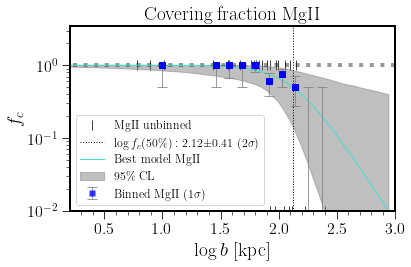

In [136]:
fc_G5_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [299]:
-11.97 +5.6

-6.370000000000001

In [300]:
-1.3 +5.6

4.3

In [301]:
1.85 - 2.1

-0.25

In [302]:
2.67 - 2.1

0.5699999999999998

In [304]:
0.47 - 0.2

0.26999999999999996

In [305]:
0.05 - 0.6

-0.5499999999999999

In [ ]:
alpha -5.6 [-11.97--1.30] (95\%) 
beta 2.1 [1.85-2.67] (95\%) 
f_out 0.2 [0.01-0.47] (95\%) 
p_out 0.6 [0.05-0.99] (95\%)

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:18<00:00, 498.88draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6897735132975223, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -5.054492 -12.541043 -8.422581 -4.891685 -1.904010   2.197662
beta    1.505719   0.314002  0.943712  1.502795  2.065599   2.761249
zalpha  2.771885  -8.225769  0.487851  2.523386  5.458175  12.863459
f_out   0.195818   0.005565  0.042139  0.172322  0.362958   0.477217
p_out   0.562235   0.046097  0.242907  0.584143  0.873730   0.979022
alpha -4.9 [-12.54-2.17] (95\%) 
beta 1.5 [0.31-2.76] (95\%) 
zalpha 2.5 [-8.23-12.84] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.05-0.98] (95\%) 

WAIC 25.29 +/- 4.19 peff 2.03
WAIC deviance 21.232953225628503
LOO 25.35 +/- 4.21 peff 2.06
WBIC  32.59433167414027
Deviance Lmax 32.2607
DIC Lmax 47.6653 7.70
Deviance best 33.1430
DIC best 46.7830 6.82
|               WAIC |                LOO |              WBIC |                DIC |
| 25.288018391542806 | 25.348972196771417 | 32.59433167414027 | 46.783021981028845 |
['alpha', 

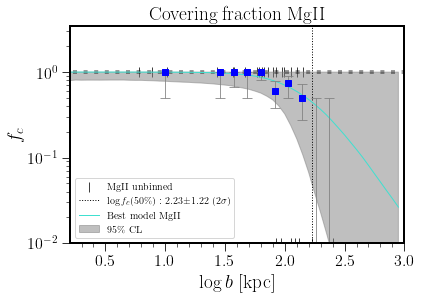

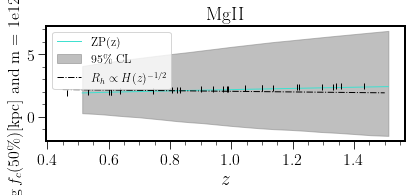

In [138]:
fc_G5_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:09<00:00, 983.83draws/s] 
The acceptance probability does not match the target. It is 0.9223282547778127, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.361153 -10.591032 -7.103328 -4.214221 -1.932285  1.450019
beta   2.389418   1.191442  2.226455  2.413443  2.655618  2.919197
f_out  0.225049   0.009284  0.061599  0.212164  0.397591  0.483465
p_out  0.613910   0.053124  0.296147  0.661604  0.901552  0.983987
alpha -4.2 [-10.59-1.45] (95\%) 
beta 2.4 [1.19-2.92] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.7 [0.05-0.98] (95\%) 

WAIC 28.67 +/- 4.01 peff 1.35
WAIC deviance 25.97273644432888
LOO 28.70 +/- 4.02 peff 1.36
WBIC  33.19195955949905
Deviance Lmax 37.3259
DIC Lmax 47.4744 5.07
Deviance best 37.3847
DIC best 47.4155 5.02
|              WAIC |                LOO |              WBIC |               DIC |
| 28.67280177019287 | 28.695112964813923 | 33.19195955949905 | 47.41548200870807 |
['alpha', 'beta', 'f_out', 'p_out']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.361153 -10.591032 -7.1033

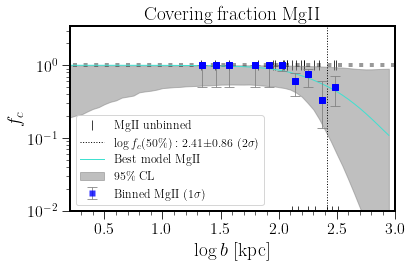

In [139]:
fc_G5_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

MgII_closest_only_redshiftRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, zalpha, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:18<00:00, 493.56draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5406922676528328, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta', 'zalpha', 'f_out', 'p_out']
            mean        2.5      16.0      50.0      84.0       97.5
alpha  -3.215381 -10.563806 -6.826157 -3.339052 -0.129240   6.371425
beta    1.590653   0.314028  0.943168  1.587868  2.260544   2.820031
zalpha  2.603746 -13.866699 -0.664604  3.356397  6.984006  13.312892
f_out   0.242999   0.011890  0.082382  0.238275  0.408861   0.485088
p_out   0.493897   0.033724  0.187012  0.474212  0.824071   0.970063
alpha -3.3 [-10.56-6.35] (95\%) 
beta 1.6 [0.31-2.82] (95\%) 
zalpha 3.4 [-13.87-13.31] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.5 [0.03-0.97] (95\%) 

WAIC 29.00 +/- 4.81 peff 2.04
WAIC deviance 24.92668506643772
LOO 29.05 +/- 4.83 peff 2.06
WBIC  33.3641749551022
Deviance Lmax 34.9130
DIC Lmax 51.3291 8.21
Deviance best 36.3905
DIC best 49.8516 6.73
|               WAIC |                LOO |             WBIC |                DIC |
| 28.999761492950352 | 29.054369322762092 | 33.3641749551022 | 49.851604750761666 |
['alpha', 'be

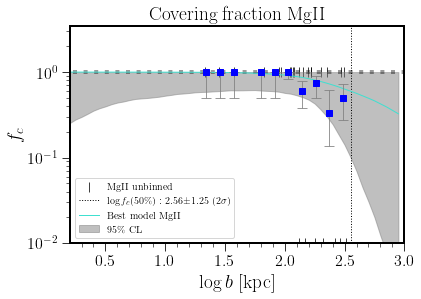

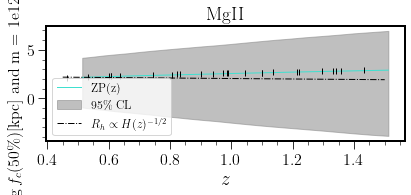

In [140]:
fc_G5_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

MgII_closest_only
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 1942.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.639049 -3.609999 -2.449052 -1.507613 -0.819861 -0.405645
beta   1.671282  0.991948  1.236054  1.587421  2.128350  2.777087
alpha -1.5 [-3.61--0.41] (95\%) 
beta 1.6 [0.99-2.78] (95\%) 

WAIC 29.61 +/- 5.52 peff 1.81
WAIC deviance 25.98708033560563
LOO 29.79 +/- 5.58 peff 1.90
WBIC  30.075465543057604
Deviance Lmax 28.5326
DIC Lmax 32.9686 2.22
Deviance best 28.5520
DIC best 32.9492 2.20
|              WAIC |               LOO |               WBIC |               DIC |
| 29.60508450378327 | 29.78867008616851 | 30.075465543057604 | 32.94922880360731 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.639049 -3.609999 -2.449052 -1.507613 -0.819861 -0.405645
beta   1.671282  0.991948  1.236054  1.587421  2.128350  2.777087


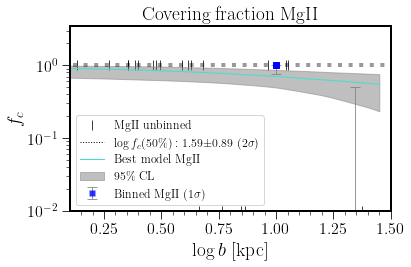

In [141]:
fc_G5_bcenter_norm_raw = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 1.5])

MgII_closest_onlyRobust_LR
Reading from None
LEN (Outcomes) 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [p_out, f_out, beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1642.16draws/s]
The acceptance probability does not match the target. It is 0.7120985772027598, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.148130 -9.540037 -5.386433 -2.436172 -1.097577 -0.401657
beta   1.609515  0.672055  0.990519  1.549373  2.251437  2.791600
f_out  0.263410  0.016671  0.100361  0.269124  0.420462  0.487455
p_out  0.579287  0.058583  0.263378  0.608388  0.877406  0.982349
alpha -2.4 [-9.54--0.40] (95\%) 
beta 1.5 [0.67-2.79] (95\%) 
f_out 0.3 [0.02-0.49] (95\%) 
p_out 0.6 [0.06-0.98] (95\%) 

WAIC 29.96 +/- 4.86 peff 1.79
WAIC deviance 26.38505398656685
LOO 30.02 +/- 4.87 peff 1.82
WBIC  33.03609577198269
Deviance Lmax 36.6583
DIC Lmax 46.8514 5.10
Deviance best 37.1085
DIC best 46.4012 4.65
|               WAIC |               LOO |              WBIC |               DIC |
| 29.963350987774746 | 30.02248094803073 | 33.03609577198269 | 46.40120403670804 |
['alpha', 'beta', 'f_out', 'p_out']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.148130 -9.540037 -5.386433 -2.4

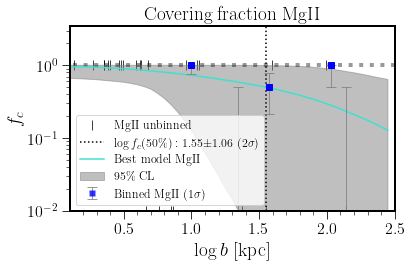

In [179]:
fc_G5_bcenter_norm = run_covering_2.mgii(run = True, filename = folder + "/G5_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, with_outliers = 'Robust_LR', xlim = [0.1, 2.5])

In [291]:
9.54 - 2.4

7.139999999999999

In [ ]:
9.54 - 2.4

In [292]:
1.5 - 0.67

0.83

In [293]:
2.79 - 1.5

1.29

In [295]:
0.02 - 0.3

-0.27999999999999997

In [296]:
0.49 - 0.3

0.19

In [297]:
0.06 - 0.6

-0.54

In [298]:
0.98 - 0.6

0.38

In [ ]:
alpha -2.4 [-9.54--0.40] (95\%) 
beta 1.5 [0.67-2.79] (95\%) 
f_out 0.3 [0.02-0.49] (95\%) 
p_out 0.6 [0.06-0.98] (95\%)

### fc for N>=3

In [ ]:
fc_G3_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
fc_G3_bmin_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bmin_log.csv", redshift = True, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = False, with_outliers = 'Robust_LR')

In [ ]:
#fc_G3_bcenter_z = run_covering_2.mgii(run = True, filename = folder + "/G3_mgii_bcenter_log.csv", redshift = True, with_outliers = 'Robust_LR')

## Comparison with other results

In [245]:
logb = np.linspace(0.5, 3, 50)
logb_norm = np.linspace(0.05, 4)

#### Dutta 2020

In [183]:
Dutta_2020 = pd.read_csv("Dutta_2020.csv", index_col = False)

#### Schroetter 2020

In [184]:
def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.6, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 1.2)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

#### Nielsen 2013

In [185]:
Niels_b = [12.5, 37.5, 75, 150]
Niels_01 = [1, 0.94, 0.61, 0.29]
Niels_03 = [0.96, 0.79, 0.40, 0.25]
Niels_1 = [0.39, 0.31, 0.13, 0.06]
Niels = np.array([Niels_b, Niels_01, Niels_03, Niels_1])
Nielsen_2013 = pd.DataFrame(Niels.T, columns = ["b", "fc01", "fc03", "fc1"])

#### Bordoloi 2011

In [186]:
bordoloi_b = [20 ,50, 70, 100, 140, 180]
bordoloi_rew_group = [0.33 , 0.46, 0.39, 0.16, 0.15, 0.046] #upper limit for the last value
bordoloi_rew_nongroup = [0.48 , 0.38, 0.18, 0.04, 0.012, 0] #upper limit for the last value
bordoloi_sig_group = [0.09 , 0.07, 0.05, 0.04, 0.03, 0]
bordoloi_sig_nongroup = [0.05 , 0.05, 0.05, 0.02, 0, 0]
d = np.array([bordoloi_b, bordoloi_rew_group, bordoloi_rew_nongroup, bordoloi_sig_group, bordoloi_sig_nongroup])
bordoloi = pd.DataFrame(d.T, columns = ["bcenter_kpc", "rew_group", "rew_nongroup", "sigma_group", "sigma_nongroup"])
bordoloi

bcenter_kpc  rew_group  rew_nongroup  sigma_group  sigma_nongroup
0         20.0      0.330         0.480         0.09            0.05
1         50.0      0.460         0.380         0.07            0.05
2         70.0      0.390         0.180         0.05            0.05
3        100.0      0.160         0.040         0.04            0.02
4        140.0      0.150         0.012         0.03            0.00
5        180.0      0.046         0.000         0.00            0.00

#### Huang 2021

In [187]:
Huang_b = [20, 70, 200, 500]
Huang_all = [0.87, 0.49, 0.19, 0.06]
Huang_all_sigma = [0.05, 0.06, 0.12, 0.06]
Huang_blue = [0.92, 0.56, 0.19, 0.08]
Huang_red = [0.67, 0.41, 0.09, 0.04]
Huang = np.array([Huang_b, Huang_all, Huang_all_sigma, Huang_blue, Huang_red])
Huang_2021 = pd.DataFrame(Huang.T, columns = ["b", "all","all_sigma", "blue", "red"])

In [246]:
pbest, plow, phigh = fc_G5_bcenter_norm.predict_2d(logb_norm, 1.0, params=fc_G5_bcenter_norm.trace)

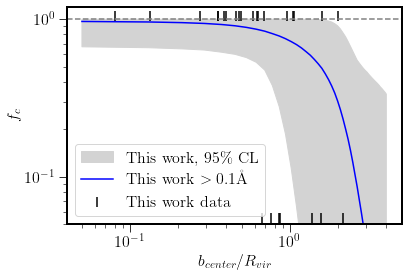

In [247]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightgray', label = "This work, 95\% CL")
plt.plot(logb_norm, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(fc_G5_bcenter_norm.log_flux, fc_G5_bcenter_norm.outcomes+0.055, marker = "|", color = "black", s = 100, label = "This work data")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.05,1.2))
plt.yscale("log")
plt.xlabel("$b_{center}/ R_{vir}$")
plt.ylabel("$f_c$")
plt.xscale("log")

In [190]:
#pbest, plow, phigh = fc_G3_bmin_noz.predict_2d(logb, 1.0, params=fc_G3_bmin_noz.trace)

NameError: name 'fc_G3_bmin_noz' is not defined

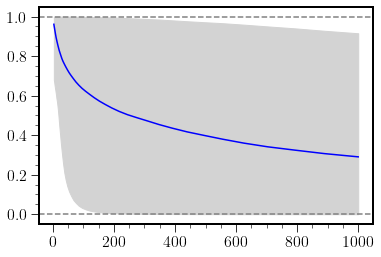

In [152]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G3_bmin_noz.log_flux, fc_G3_bmin_noz.outcomes+0.01, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2021, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.01,2))
plt.xlim((1, 500))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("distance to closest galaxy (kpc)")
plt.ylabel("$f_c$")

In [174]:
pbest, plow, phigh = fc_G5_bmin_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

Text(0, 0.5, '$f_c$')

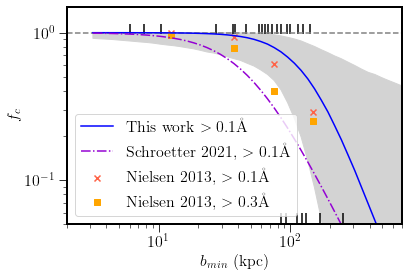

In [175]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.055, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2021, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.05,1.5))
plt.xlim((2, 700))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

In [155]:
pbest, plow, phigh = fc_G5_center_noz.predict_2d(logb, 1.0, params=fc_G5_bmin_noz.trace)

NameError: name 'fc_G5_center_noz' is not defined

In [ ]:
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow, phigh, color = 'lightgray')
plt.plot(10**logb, pbest, label= "This work $> 0.1$\AA", color = "blue")
plt.scatter(10**fc_G5_bmin_noz.log_flux, fc_G5_bmin_noz.outcomes+0.01, marker = "|", color = "black", s = 100)
#plt.scatter(np.log10(G3["b_min_kpc"]), G3["bool_absorption"])

#Dutta 2020
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)

#Schroetter 2020
#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")

#Nielsen 2013
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc01"],  color = "tomato", marker = "x", label = "Nielsen 2013, $> 0.1$\AA")
plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
#plt.errorbar(np.log10(Huang_2021["b"]), Huang_2021["all"], yerr= Huang_2021["all_sigma"], linestyle = '', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend()
plt.ylim((0.01,2))
plt.xlim((1, 500))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$b_{min}$ (kpc)")
plt.ylabel("$f_c$")

In [219]:
r = np.linspace(1, 300, 100)*u.kpc
gid.NFW_escape_vel_from_Mvir(r, 1e12*u.solMass, z = 1)

<Quantity [544.95285002, 530.60374759, 517.74148256, 506.10359994,
           495.49070009, 485.74780459, 476.75212521, 468.40476599,
           460.62493294, 453.34579426, 446.51145755, 440.07472094,
           433.99537239, 428.2388844 , 422.77539883, 417.5789279 ,
           412.62671851, 407.89874137, 403.37727679, 399.04657598,
           394.89258197, 390.90269806, 387.0655943 , 383.37104492,
           379.80979088, 376.37342302, 373.05428229, 369.84537412,
           366.74029458, 363.73316646, 360.81858377, 357.99156325,
           355.24750194, 352.58213998, 349.99152769, 347.47199662,
           345.02013377, 342.63275875, 340.30690336, 338.0397934 ,
           335.82883235, 333.67158673, 331.56577288, 329.50924512,
           327.49998501, 325.5360916 , 323.61577263, 321.73733652,
           319.89918509, 318.09980689, 316.33777112, 314.61172211,
           312.92037422, 311.26250715, 309.63696167, 308.04263568,
           306.47848056, 304.94349784, 303.43673608, 301.95728

0 1
7630926424594.758 solMass 0.98865
2 2
52363276744655.98 solMass 0.83365
3 3
772387856111.7029 solMass 0.7446964065548093
4 4
7003574915764.192 solMass 0.6374065778224187
5 5
1601218844317.4268 solMass 0.90074
6 6
10457008028936.066 solMass 0.60754
7 7
2852293820493.872 solMass 1.33047
9 8
1918422028466.2893 solMass 1.099868635824513
11 9
13227998300847.953 solMass 1.4313177399384789
12 10
3862758387973.112 solMass 1.21499
13 11
676010157781.5927 solMass 0.9407119945275554
14 12
4428373954468.009 solMass 1.1365884653627396
16 13
659971644754.4443 solMass 0.8240299999999999
17 14
1743329244756.8462 solMass 0.97172
18 15
2063768921656.0383 solMass 1.35627
19 16
5324949382160.916 solMass 0.60601
20 17
138708291007.01407 solMass 0.9868911209436086
22 18
699490880165.5964 solMass 0.80705
23 19
15754711755195.44 solMass 1.09848
24 20
983597577681.67 solMass 1.2952344095662225
25 21
1561282816723.0022 solMass 1.34027
26 22
381859455389.9831 solMass 1.2213495019243523
27 23
21466854071466.5

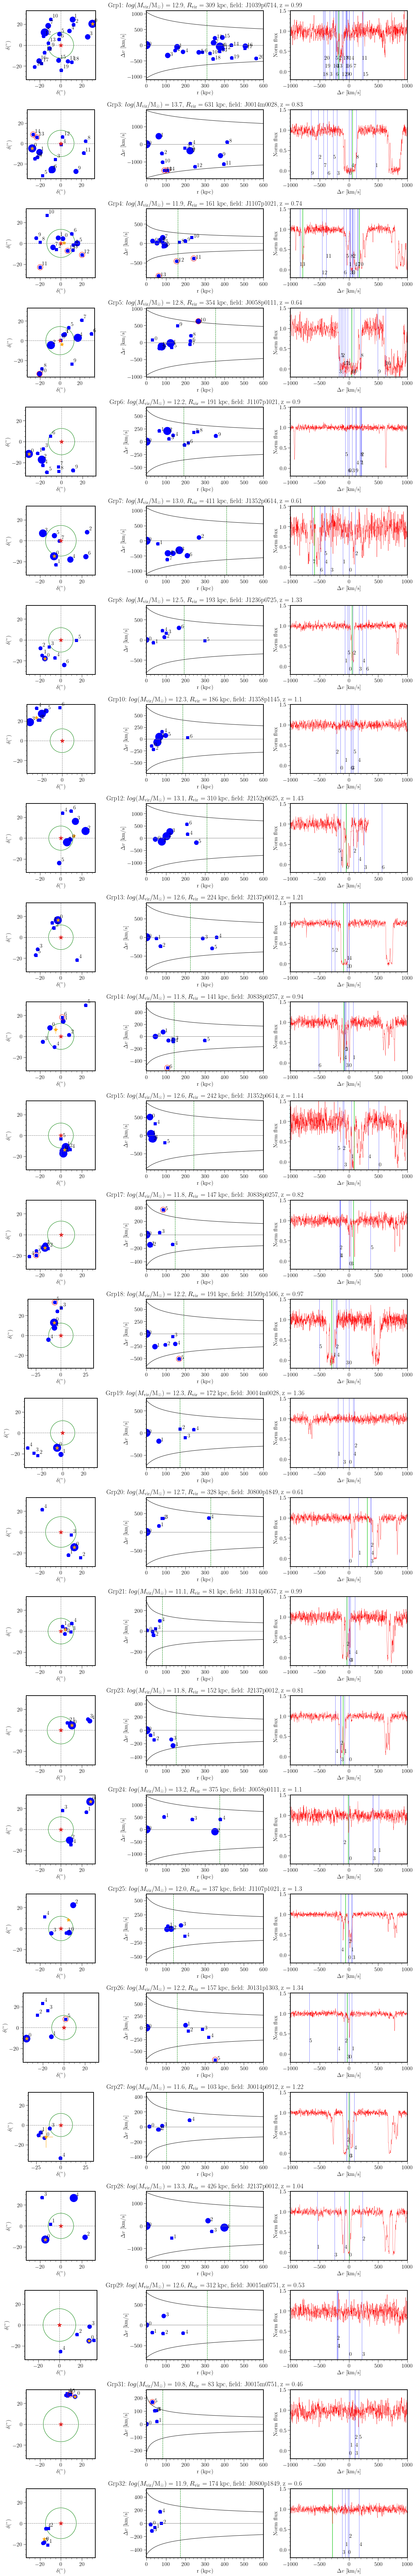

In [220]:
gid.plot_groups_2(R, G5, Nmin = 5, save = True, filename = "group_catalog.pdf")

In [ ]:
G.columns

In [ ]:
3727*(1+0.988)

In [ ]:
const.c.to(u.km/u.s)

In [ ]:
gid.plot_groups(R, G, Nmin = 5)

In [ ]:
grp = G5[G5["ID"] == 10]
grp

In [ ]:
rr = R[R["group"] == 267]
rr[["ID", "Psat"]]

In [ ]:
plt.scatter(rr["r_to_gcenter"], rr["vlos_to_gcenter"], c = rr["Psat"], vmin = 0, vmax = 1)

In [54]:
GG = G[G["N_gal"]>=5]
GG = GG[["ID", "group_id", "field_id", "center_z", "mean_z", "vlos_spread", "z_min", "z_max", "lambda_oii_a"]]
GG["min_oii"] = 3727*(1+GG["z_min"])
GG["max_oii"] = 3727*(1+GG["z_max"])
GG

ID  group_id    field_id  center_z    mean_z  vlos_spread    z_min  \
0    1       605  J1039p0714  0.988650  0.987775   685.920440  0.98572   
1    2       842  J0145p1056  0.937800  0.937542  1135.554052  0.93317   
2    3      1274  J0014m0028  0.833650  0.831174  1737.950988  0.82581   
3    4       544  J1107p1021  0.744696  0.744963   245.717945  0.74418   
4    5      1065  J0058p0111  0.637407  0.637529   664.616008  0.63647   
5    6       549  J1107p1021  0.900740  0.901378   277.594372  0.90033   
6    7       315  J1352p0614  0.607540  0.606026   729.181551  0.60420   
7    8       438  J1236p0725  1.330470  1.331220   365.338571  1.32994   
8    9       248  J1358p1145  1.484000  1.482316   646.895159  1.47896   
9   10       247  J1358p1145  1.099869  1.099736   378.333197  1.09831   
10  11      1153  J0015m0751  0.873060  0.872727   240.082372  0.87209   
11  12        13  J2152p0625  1.431318  1.432120   747.225369  1.42982   
12  13        50  J2137p0012  1.214990  1.214250   299.117076  1.21279   
13  14       733  J0838p0257  0.940712  0.940495   156.020256  0.94017   
14  15       316  J1352p0614  1.136588  1.137177   705.777499  1.13519   
15  16       192  J1425p1209       NaN  0.260037   499.562907  0.25887   
16  17       741  J0838p0257  0.824030  0.823512   190.654348  0.82306   
17  18       112  J1509p1506  0.971720  0.970740   261.519398  0.97000   
18  19      1283  J0014m0028  1.356270  1.356080   279.909946  1.35480   
19  20       796  J0800p1849  0.606010  0.607382   375.204912  0.60601   
20  21       399  J1314p0657  0.986891  0.987006   138.814381  0.98663   
21  22       554  J1107p1021  3.549020  3.547924   474.613406  3.54240   
22  23        59  J2137p0012  0.807050  0.806336   232.262218  0.80565   
23  24      1054  J0058p0111  1.098480  1.100206   604.305067  1.09782   
24  25       542  J1107p1021  1.295234  1.295142   193.310468  1.29418   
25  26       949  J0131p1303  1.340270  1.339878   248.517209  1.33873   
26  27      1219  J0014p0912  1.221350  1.221390   125.512435  1.22107   
27  28        51  J2137p0012  1.043970  1.043106   771.492893  1.04028   
28  29      1140  J0015m0751  0.533490  0.533110   428.138092  0.53243   
29  30      1162  J0015m0751  0.629700  0.630146   364.232108  0.62891   
30  31      1144  J0015m0751  0.464000  0.464324   104.435897  0.46400   
31  32       825  J0800p1849  0.600017  0.599996   290.420891  0.59940   

      z_max  lambda_oii_a      min_oii      max_oii  
0   0.99027   7408.637090   7400.77844   7417.73629  
1   0.94051   7221.414208   7204.92459   7232.28077  
2   0.83644   6824.968042   6804.79387   6844.41188  
3   0.74561   6503.650581   6500.55886   6505.88847  
4   0.64010   6103.234336   6099.12369   6112.65270  
5   0.90209   7086.625944   7082.52991   7089.08943  
6   0.60811   5985.820436   5978.85340   5993.42597  
7   1.33278   8688.690062   8683.68638   8694.27106  
8   1.48432   9251.838899   9239.08392   9259.06064  
9   1.10096   7825.924981   7820.40137   7830.27792  
10  0.87359   6979.841334   6977.27943   6982.86993  
11  1.43588   9064.754452   9055.93914   9078.52476  
12  1.21500   8252.731175   8247.06833   8255.30500  
13  0.94118   7232.418914   7231.01359   7234.77786  
14  1.14022   7965.471154   7957.85313   7976.59994  
15  0.26097   4696.282660   4691.80849   4699.63519  
16  0.82422   6796.411575   6794.54462   6798.86794  
17  0.97172   7345.145054   7342.19000   7348.60044  
18  1.35700   8781.345768   8776.33960   8784.53900  
19  0.60802   5990.873452   5985.59927   5993.09054  
20  0.98755   7405.770063   7404.17001   7407.59885  
21  3.54960  16950.567540  16929.52480  16956.35920  
22  0.80705   6732.394906   6729.65755   6734.87535  
23  1.10205   7827.677783   7818.57514   7834.34035  
24  1.29566   8554.223748   8550.40886   8555.92482  
25  1.34067   8720.959294   8716.44671   8723.67709  
26  1.22200   8279.342669   8277.92789   8281.39400  
27  1.04554   7614.860373   7604.12356   7623.727

In [55]:
GG.to_csv("G5_for_oii_maps2.csv", index = False)

In [ ]:
R[R["group"] == 190]

In [ ]:
G.columns

In [ ]:
G[["field_id", "ID",  "N_gal", "REW_2796", "center_z", "zqso_sdss","QSO_is_behind"]].head(30)

In [ ]:
G3.head(50)

In [ ]:
plt.scatter(G5["REW_2796"], np.log10(G5["M_vel_disp"]))

In [ ]:
alpha -4.8 [-11.74--0.53] (95\%) 
beta 2.1 [1.54-2.85] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.7 - 4.8)
print(0.53-4.8)

In [ ]:
print(2.1 - 1.54)
print(2.85-2.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
print(0.6 - 0.04)
print(0.6 - 0.98)

In [ ]:
alpha -4.6 [-11.38--0.45] (95\%) 
beta 1.1 [0.63-2.43] (95\%) 
f_out 0.2 [0.01-0.48] (95\%) 
p_out 0.6 [0.04-0.98] (95\%)

In [ ]:
print(11.38 - 4.6)
print(0.45 - 4.6)

In [ ]:
print(1.1 - 0.63)
print(2.43-1.1)

In [ ]:
print(0.2 - 0.01)
print(0.48 - 0.2)

In [ ]:
gid.plot_groups_2(R, G5)

In [ ]:
len(G5)

In [ ]:
cosmo.H0

In [ ]:
from astropy.cosmology import Planck18

In [ ]:
G5["Rvir"]

In [ ]:
len(G5)

In [ ]:
G5.columns

In [177]:
G5["logM"] = np.log10(G5["Mvir_sigma2"])

In [290]:
G5[["ID", "N_gal", "center_z", "center_ra", "center_dec", "logM", "Rvir_sigma2", "REW_2796",\
    "detection_limit","m1_m2_ratio", "b_center_kpc_norm2", "b_min_kpc"]]

ID  N_gal  center_z   center_ra  center_dec       logM  Rvir_sigma2  \
0    1     21  0.988650  159.911199    7.246590  12.882577   309.353476   
2    3     13  0.833650    3.714539   -0.475704  13.719027   631.156048   
3    4     11  0.744696  166.928890   10.357421  11.887835   161.236529   
4    5     10  0.637407   14.732846    1.190286  12.845320   354.375663   
5    6     10  0.900740  166.919438   10.354043  12.204451   191.087752   
6    7      8  0.607540  208.071812    6.238443  13.019407   411.481673   
7    8      7  1.330470  189.097396    7.426033  12.455194   193.136825   
9   10      7  1.099869  209.532346   11.772470  12.282944   186.001701   
11  12      7  1.431318  328.003643    6.421810  13.121494   309.768349   
12  13      6  1.214990  324.451050    0.210079  12.586898   223.931821   
13  14      6  0.940712  129.715520    2.952859  11.829953   140.838793   
14  15      6  1.136588  208.074648    6.238782  12.646244   241.965494   
16  17      5  0.824030  129.712612    2.947514  11.819525   147.408766   
17  18      5  0.971720  227.248608   15.113219  12.241379   190.545621   
18  19      5  1.356270    3.720885   -0.478305  12.314661   171.710701   
19  20      5  0.606010  120.022546   18.822366  12.726315   328.364774   
20  21      5  0.986891  198.524619    6.956554  11.142102    81.366242   
22  23      5  0.807050  324.454787    0.206850  11.844782   151.509704   
23  24      5  1.098480   14.740144    1.198629  13.197410   375.190869   
24  25      5  1.295234  166.930115   10.359595  11.992817   137.382405   
25  26      5  1.340270   22.891924   13.055707  12.193482   157.453640   
26  27      5  1.221350    3.717479    9.201543  11.581904   103.241080   
27  28      5  1.043970  324.447723    0.201932  13.331768   426.260917   
28  29      5  0.533490    3.904431   -7.855066  12.608819   311.630076   
30  31      5  0.464000    3.900337   -7.843566  10.839912    83.099043   
31  32      5  0.600017  120.014566   18.822183  11.890482   173.525347   

    REW_2796  detection_limit  m1_m2_ratio  b_center_kpc_norm2  b_min_kpc  
0      0.627         0.050285     2.286081            0.963220      46.37  
2      2.085         0.054536     4.836325            0.354076       7.77  
3      2.336         0.057317     1.383304            0.133495      36.59  
4      3.335         0.061072     1.019722            0.080058       6.04  
5      0.000         0.052611     3.038092            1.376444      93.01  
6      0.779         0.062207     1.745389            0.272635      10.36  
7      0.407         0.042910     2.597963            1.044039     113.48  
9      0.000         0.047622     1.162311            1.553791     253.48  
11     1.150         0.041130     1.371557            0.353980      60.96  
12     1.133         0.045147    29.250179            0.629321      95.16  
13     0.774         0.051527     1.411848            0.476293      64.36  
14     1.399         0.046804     1.417323            0.492148      27.24  
16     0.284         0.054824     2.387023            1.053020     141.71  
17     1.303         0.050717    15.319936            0.617855      79.59  
18     0.000         0.042440     9.771232            0.763724     131.18  
19     1.020         0.062266    43.803657            0.400024      67.41  
20     0.911         0.050330     1.404777            0.462009      37.77  
22     0.797         0.055339    17.781447            0.590455      72.37  
23     0.088         0.047654     2.928343            0.864856     111.71  
24     0.527         0.043569     1.246849            0.682625      58.22  
25     0.169         0.042730     4.771231            1.994111     125.53  
26     1.427         0.045018     1.027550            1.594393      99.21  
27     0.869         0.048924     3.350082            0.385689      84.85  
28     0.000         0.065211     1.936681            0.665717     122.64  
30     0.000         0.068306     3.363299            2.143133     167.37  
31

In [207]:
len(G5[G5["REW_2796"]>=1])

9

In [208]:
len(G5[G5["REW_2796"]>=0.1])

19